In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import FunctionTransformer
import logging


# Sklearn and TensorFlow related imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import FeatureUnion
# CatBoost and TensorFlow Decis
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from catboost import CatBoostRegressor

from sklearn.preprocessing import OrdinalEncoder  # For tree-based models
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

import optuna
import json
pd.set_option('display.max_rows', None)
import gc
import traceback

In [2]:
#Load datasets
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
pd.set_option('display.max_rows', None)

print(df.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


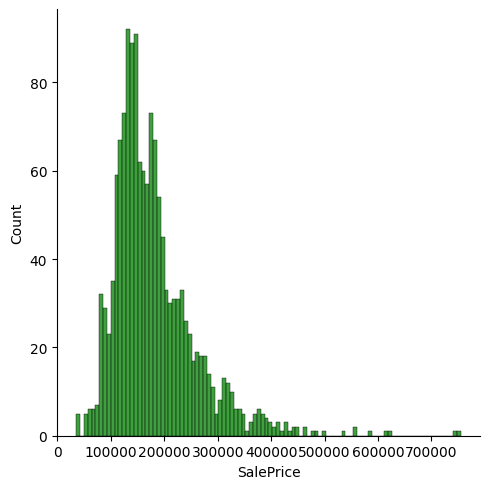

In [4]:
#Print the statistics and plot the target column = SalePrice
print(df.SalePrice.describe())
sns.displot(df["SalePrice"], color= 'g', bins = 100)

array([[<AxesSubplot: title={'center': 'MSSubClass'}>,
        <AxesSubplot: title={'center': 'LotFrontage'}>,
        <AxesSubplot: title={'center': 'LotArea'}>,
        <AxesSubplot: title={'center': 'OverallQual'}>,
        <AxesSubplot: title={'center': 'OverallCond'}>,
        <AxesSubplot: title={'center': 'YearBuilt'}>],
       [<AxesSubplot: title={'center': 'YearRemodAdd'}>,
        <AxesSubplot: title={'center': 'MasVnrArea'}>,
        <AxesSubplot: title={'center': 'BsmtFinSF1'}>,
        <AxesSubplot: title={'center': 'BsmtFinSF2'}>,
        <AxesSubplot: title={'center': 'BsmtUnfSF'}>,
        <AxesSubplot: title={'center': 'TotalBsmtSF'}>],
       [<AxesSubplot: title={'center': '1stFlrSF'}>,
        <AxesSubplot: title={'center': '2ndFlrSF'}>,
        <AxesSubplot: title={'center': 'LowQualFinSF'}>,
        <AxesSubplot: title={'center': 'GrLivArea'}>,
        <AxesSubplot: title={'center': 'BsmtFullBath'}>,
        <AxesSubplot: title={'center': 'BsmtHalfBath'}>],
     

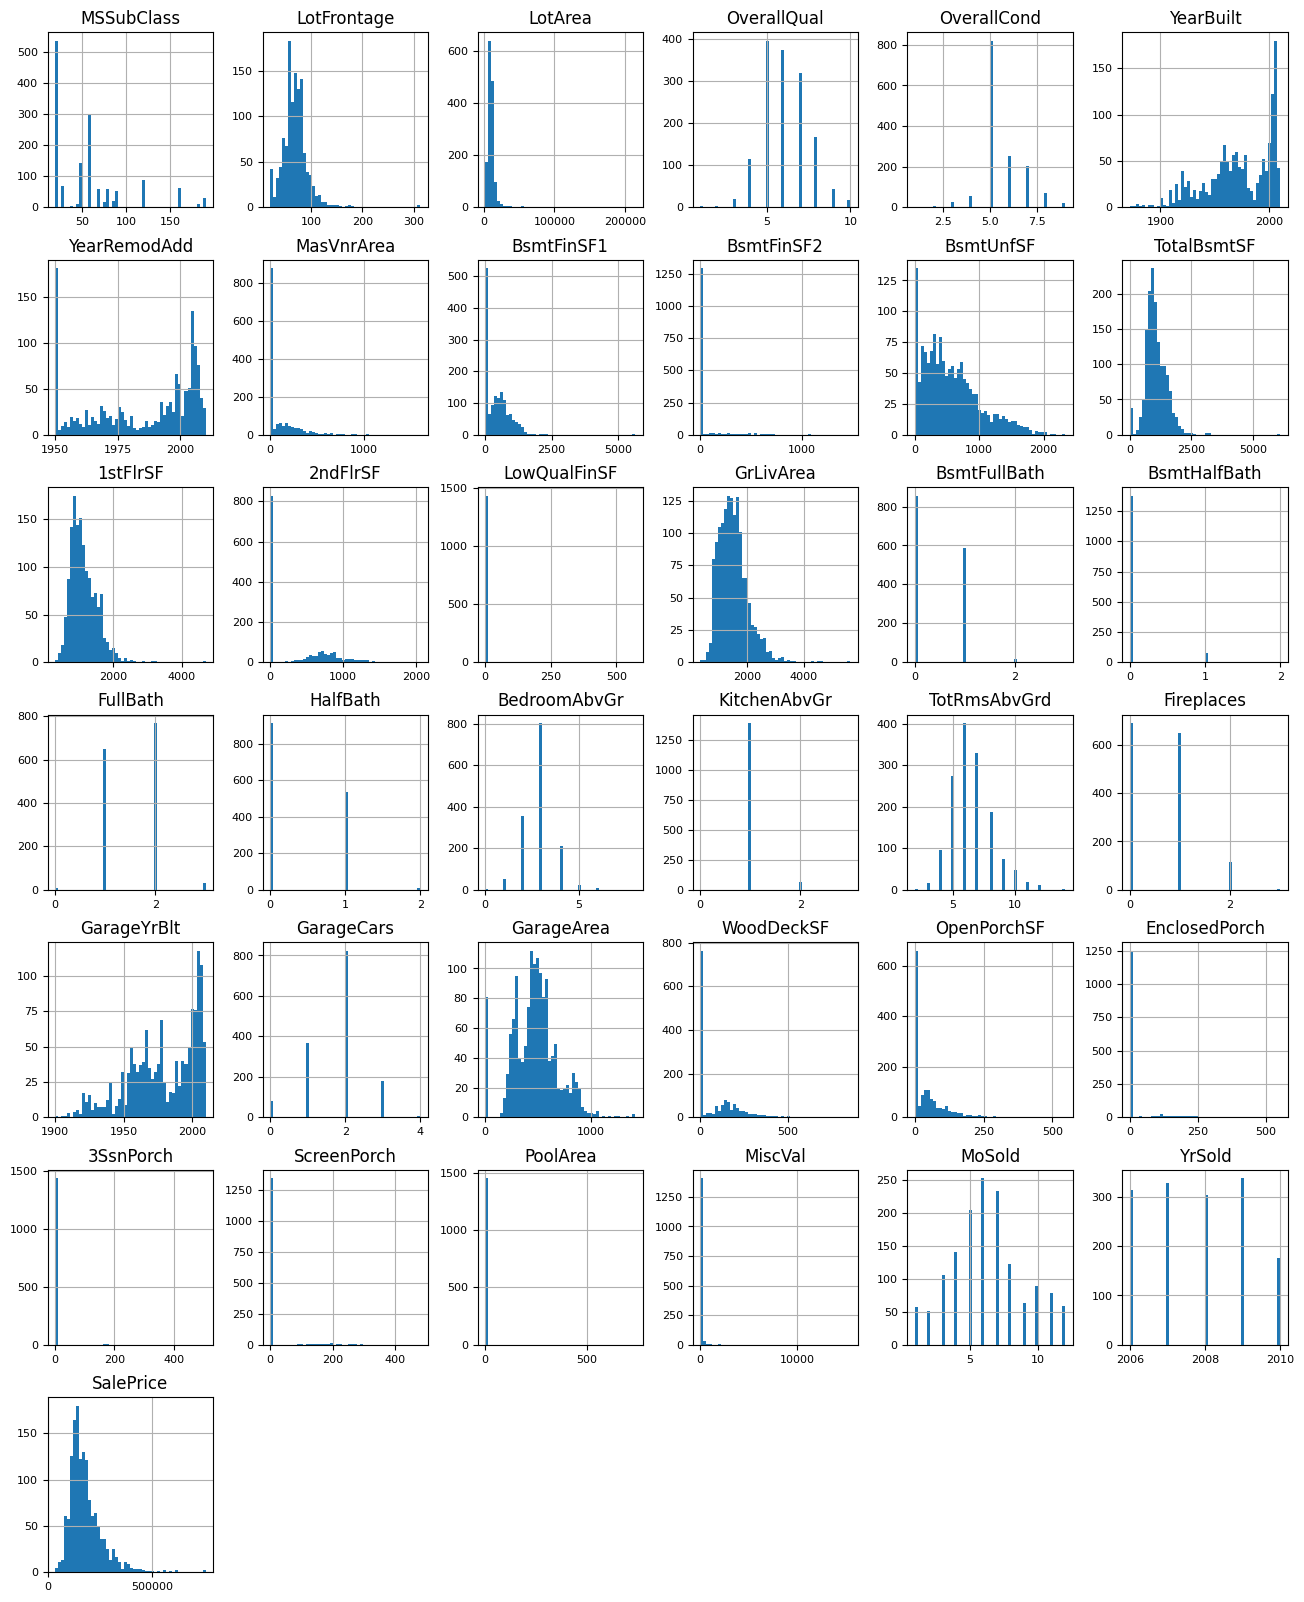

In [5]:
#Plot all the catgorical variables
df_num = df.select_dtypes(include=['float64','int64'])
df_num = df_num.drop(columns = ['Id'])
df_num.hist(figsize=(16,20), bins =50, xlabelsize =8, ylabelsize=8)

In [6]:
#Calculate mutual information
def mutualInfo(X, y):
    # Calculate mutual information
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X_numeric = X[numeric_cols]
    # Calculate mutual information for numeric columns only
    mi_scores = mutual_info_regression(X_numeric, y, random_state=42)
    mi_df = pd.DataFrame({'Feature': X_numeric.columns, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by='MI Score', ascending=False)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mi_df.head(20), x='MI Score', y='Feature',palette='viridis')
    plt.title('Mutual Information Scores')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [7]:
#Create the preprocessor for mutual info
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

cat_columns = X.select_dtypes(include=['object']).columns.tolist()
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

def preprocessorTreeMI(cat_columns,num_columns):
    preprocessor_mi = ColumnTransformer(
        transformers=[
            ('cat', Pipeline(steps=[
                ('fillna', SimpleImputer(strategy='constant', fill_value="nan")),
                ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  
            ]), cat_columns),

            ('num', Pipeline(steps=[
                ('fillna', SimpleImputer(strategy='constant', fill_value=0))
            ]), num_columns)  
        ]
    )
    return preprocessor_mi

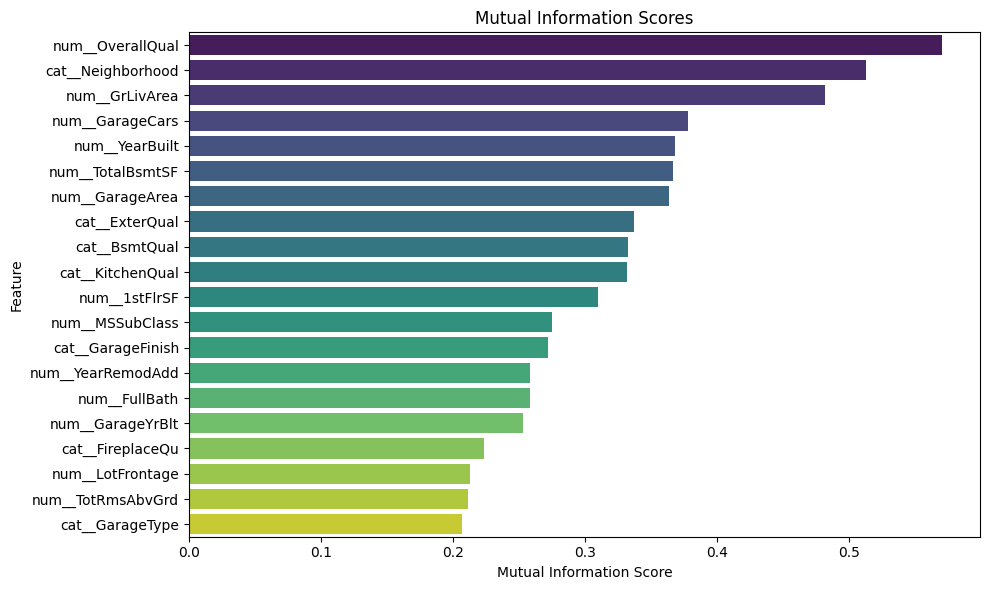

In [8]:
#Apply preprocessor for mutual info and calculate mutual info
preprocessor = preprocessorTreeMI(cat_columns,num_columns)
df_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
X_transformed = pd.DataFrame(df_transformed, columns=feature_names)
mutualInfo(X_transformed,y)


-----Feature engineering for df2--------

In [9]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names, is_tree_model, model_name):
        self.column_names = column_names
        self.is_tree_model = is_tree_model
        self.model_name = model_name

    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        columns = [name.replace('cat__', '').replace('num__', '') for name in self.column_names ]
        X_df = pd.DataFrame(X,columns = columns)

        numeric_cols = ['LotArea', 'GrLivArea', 'OverallQual', 'GarageArea', 'GarageCars',
                       '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF',
                       'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
        
        for col in numeric_cols:
            X_df[col] = X_df[col].astype(float)
        
        # Create new features
        new_features = pd.DataFrame()
        new_features['log_lotArea'] = np.log1p(X_df['LotArea']).astype(float)
        new_features["CarSpace"] = (X_df['GarageArea'] * X_df['GarageCars']).astype(float)
        new_features["LivLotRatio"] = (X_df['GrLivArea'] / X_df['LotArea'].replace(0, 1)).astype(float)
        new_features["Spaciousness"] = ((X_df["1stFlrSF"] + X_df["2ndFlrSF"]) / 
                                      X_df['TotRmsAbvGrd'].replace(0, 1)).astype(float)
        new_features["TotalOutsideSF"] = (X_df['WoodDeckSF'] + X_df['OpenPorchSF'] + 
                                         X_df['EnclosedPorch'] + X_df['3SsnPorch'] + 
                                         X_df['ScreenPorch']).astype(float)

        if self.is_tree_model:
            
            X_df['Neighborhood'] = X_df['Neighborhood'].astype(float)
            new_features["GrLivArea_Neigh"] = (X_df['GrLivArea'] * X_df['Neighborhood']).astype(float)
            new_features["OverallQual_Neigh"] = X_df['OverallQual'].astype(float) * X_df['Neighborhood'].astype(float)
            new_features['CombinedCondition'] = X_df['Condition1'].astype(str) + "_" + X_df['Condition2'].astype(str)
        
        if self.model_name != "TensorFlow Decision Forest" and self.is_tree_model:
            le = LabelEncoder()
            new_features['CombinedCondition'] = le.fit_transform(new_features['CombinedCondition'].astype(str))

        result = pd.concat([X_df, new_features], axis=1)
        return result
    

    def get_feature_names_out(self, feature_names_in=None):
        base_features = ["log_lotArea", "CarSpace", "LivLotRatio", 
                        "Spaciousness", "TotalOutsideSF"]
        if self.is_tree_model:
            tree_features = ["GrLivArea_Neigh", "OverallQual_Neigh", "CombinedCondition"]
            new_feature_names = np.concatenate([self.column_names, base_features, tree_features])
        else:
            new_feature_names = np.concatenate([self.column_names, base_features])

        return new_feature_names


In [10]:
preprocessor.fit(X)
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.replace('cat__', '').replace('num__', '') for name in feature_names]


In [11]:
# Create pipeline2
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_engineering', FeatureEngineer(feature_names, True, 'name'))
])

# Transform data
df2_transformed = pipeline2.fit_transform(X)

# Get all feature names
new_feature_names = ["log_lotArea", "GrLivArea_Neigh", "OverallQual_Neigh",
                    "CarSpace", "CombinedCondition", "LivLotRatio",
                    "Spaciousness", "TotalOutsideSF"]

all_feature_names = np.concatenate([feature_names, new_feature_names])

# Create final dataframe with explicit dtypes
df2_trans = pd.DataFrame(df2_transformed, columns=all_feature_names)

# Convert numeric columns to float64
le = LabelEncoder()
df2_trans["CombinedCondition"] = le.fit_transform(df2_trans["CombinedCondition"].astype(str))

numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
df2_trans[numeric_cols] = df2_trans[numeric_cols].astype('float64')
# Try explicit conversion
df2_trans['GrLivArea_Neigh'] = df2_trans['GrLivArea_Neigh'].map(float)
df2_trans['OverallQual_Neigh'] = df2_trans['OverallQual_Neigh'].map(float)
df2_trans['CarSpace'] = df2_trans['CarSpace'].map(float)
# Concatenate with target
df2 = pd.concat([df2_trans, y], axis=1)

In [12]:

print("\nDataframe dtypes:")
print(df2.dtypes)
print("\nSample of GrLivArea_Neigh values:")
print(df2['GrLivArea_Neigh'].head())

print("\nSample of OverallQual_Neigh values:")
print(df2['OverallQual_Neigh'].head())

print(df2.isna().sum())


Dataframe dtypes:
MSZoning             float64
Street               float64
Alley                float64
LotShape             float64
LandContour          float64
Utilities            float64
LotConfig            float64
LandSlope            float64
Neighborhood         float64
Condition1           float64
Condition2           float64
BldgType             float64
HouseStyle           float64
RoofStyle            float64
RoofMatl             float64
Exterior1st          float64
Exterior2nd          float64
MasVnrType           float64
ExterQual            float64
ExterCond            float64
Foundation           float64
BsmtQual             float64
BsmtCond             float64
BsmtExposure         float64
BsmtFinType1         float64
BsmtFinType2         float64
Heating              float64
HeatingQC            float64
CentralAir           float64
Electrical           float64
KitchenQual          float64
Functional           float64
FireplaceQu          float64
GarageType           flo

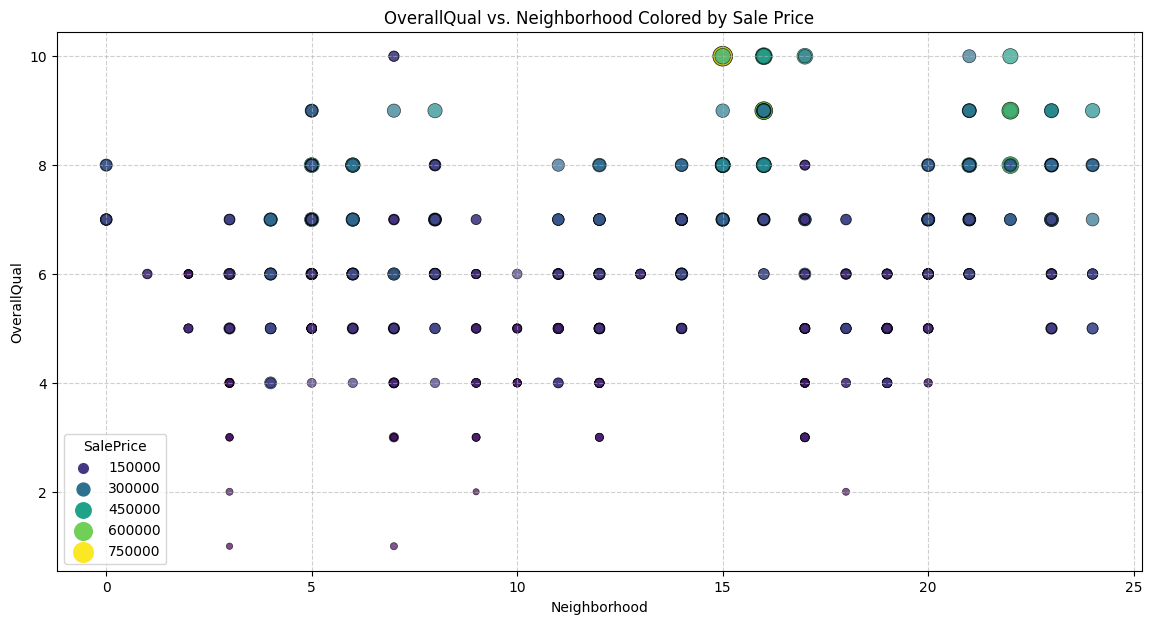

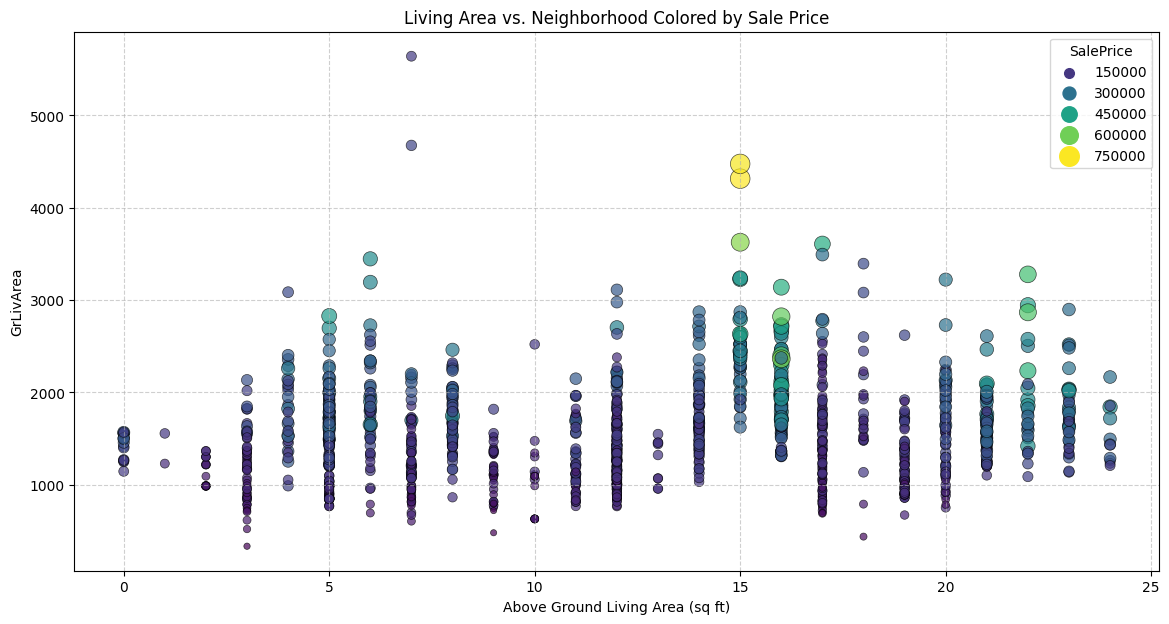

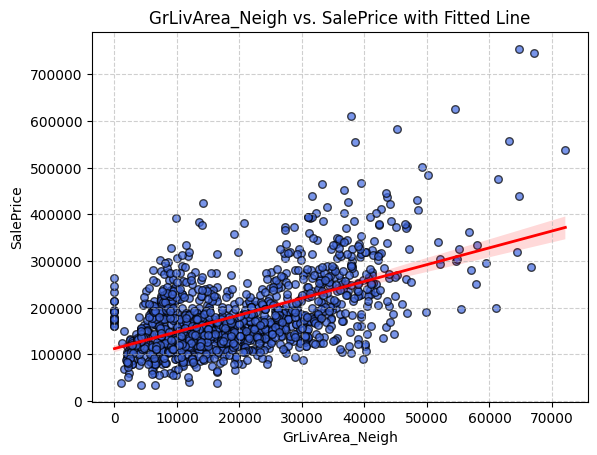

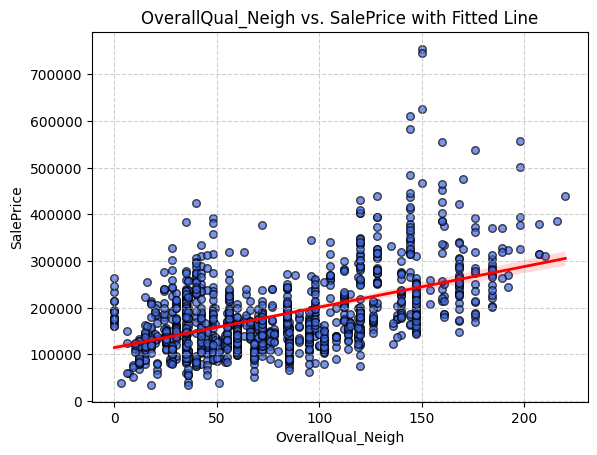

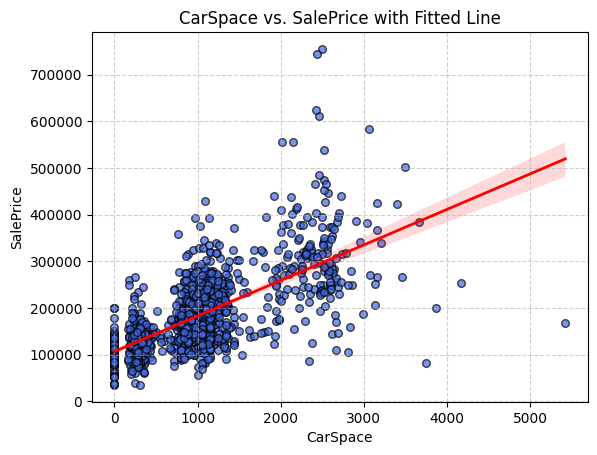

0


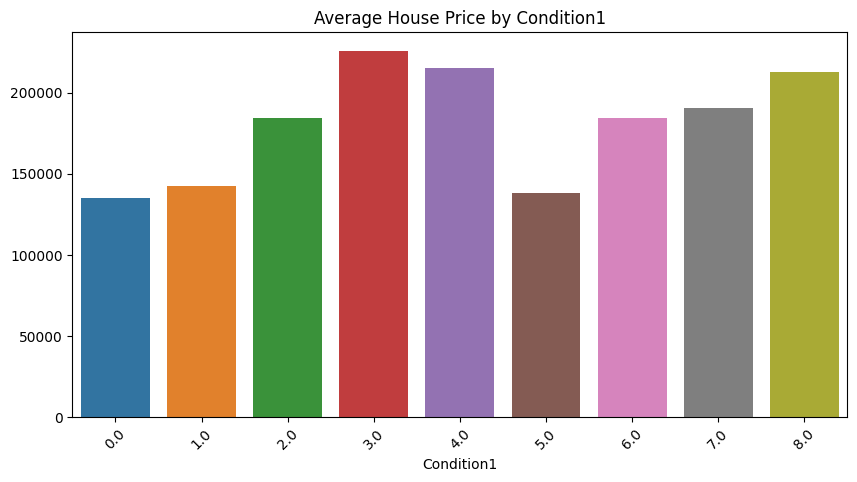

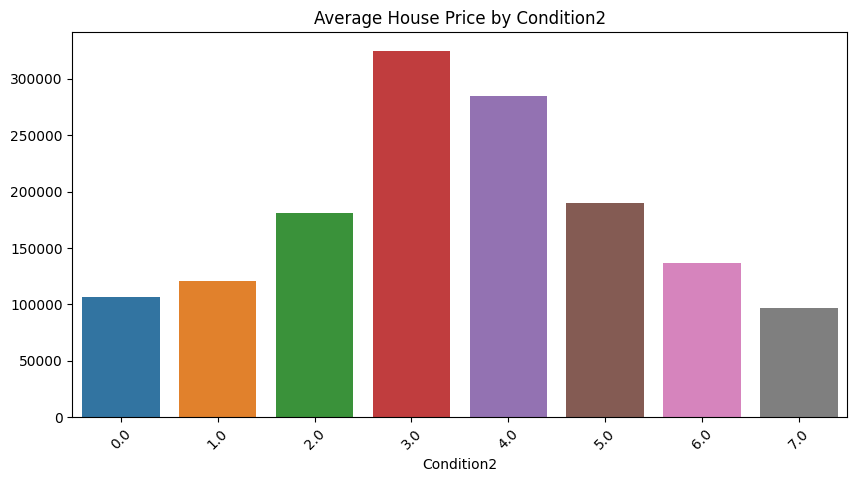

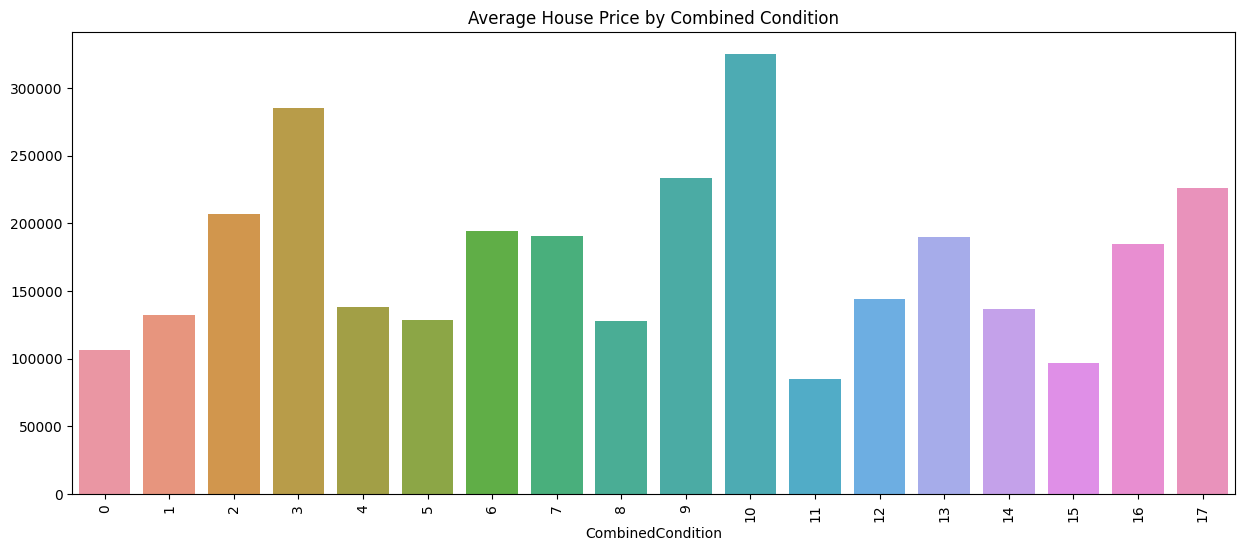

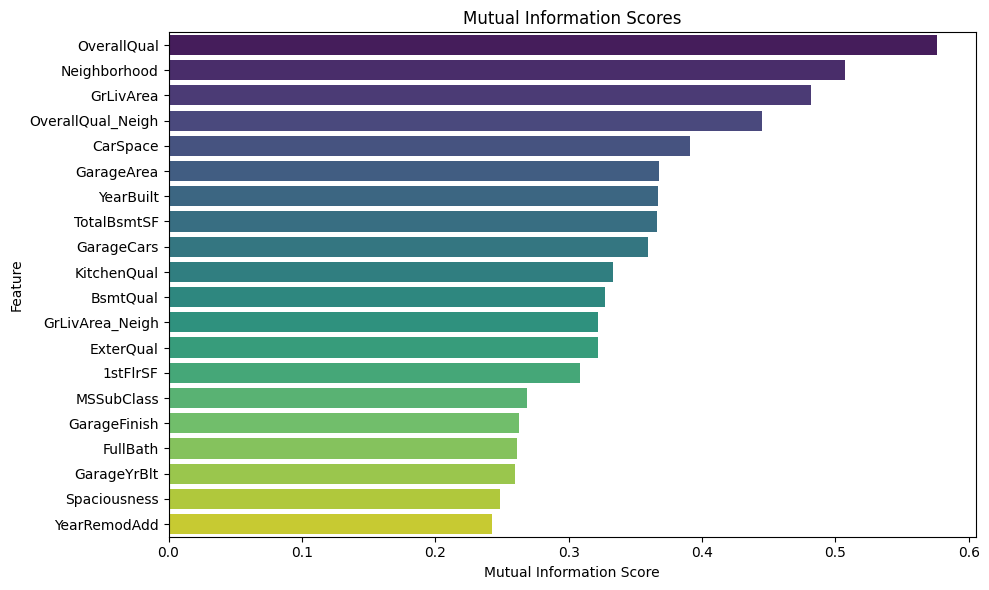

In [13]:
def plotScatter(x,y,hue,size,title,xlabel):
    plt.figure(figsize=(14, 7))
    sns.scatterplot(
    data=df2, 
    x=x, 
    y=y, 
    hue=hue, 
    palette='viridis', 
    size=size,
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='k'
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plotReg(x,y,title,xlabel):
    sns.regplot(
    data=df2, 
    x=x, 
    y=y, 
    scatter_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},  
    line_kws={'color': 'red', 'linewidth': 2},  
    color='royalblue',  
    logistic=False,
)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

#OverallQuality + Neighborhood VS SalePrice
plotScatter('Neighborhood','OverallQual','SalePrice','SalePrice', 'OverallQual vs. Neighborhood Colored by Sale Price','Neighborhood')
#GRLivArea + Neighborhood VS SalePrice
plotScatter('Neighborhood','GrLivArea','SalePrice','SalePrice', 'Living Area vs. Neighborhood Colored by Sale Price','Above Ground Living Area (sq ft)')

# Scatterplot with regression line
plotReg('GrLivArea_Neigh','SalePrice','GrLivArea_Neigh vs. SalePrice with Fitted Line','GrLivArea_Neigh' )
plotReg('OverallQual_Neigh','SalePrice', 'OverallQual_Neigh vs. SalePrice with Fitted Line','OverallQual_Neigh')
plotReg('CarSpace','SalePrice', 'CarSpace vs. SalePrice with Fitted Line','CarSpace')

print(df2['Condition1'].isna().sum())
# Analyze Condition1
cond1_prices = df2.groupby('Condition1')['SalePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=cond1_prices.index, y=cond1_prices.values)
plt.title('Average House Price by Condition1')
plt.xticks(rotation=45)
plt.show()

# Analyze Condition2
cond2_prices = df2.groupby('Condition2')['SalePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=cond2_prices.index, y=cond2_prices.values)
plt.title('Average House Price by Condition2')
plt.xticks(rotation=45)
plt.show()

# Combine both conditions
combined_prices = df2.groupby('CombinedCondition')['SalePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(x=combined_prices.index, y=combined_prices.values)
plt.title('Average House Price by Combined Condition')
plt.xticks(rotation=90)
plt.show()

mutualInfo(df2_trans,y)

-----Define models, train, evaluate, find the best params--------

In [14]:
#Defining the models
models = {
    "Logistic Regression": LogisticRegression(),
     "Random Forest": RandomForestClassifier(),
     "Gradient Boosting": GradientBoostingClassifier(),
     "SVM": SVC(),
     "KNN": KNeighborsClassifier(),
     "Decision Tree": DecisionTreeClassifier(),
    "TensorFlow Decision Forest": tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION),
    "Cat Boost": CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100)
}

model_linear = {
    "Logistic Regression": LogisticRegression(),
     "SVM": SVC(),
     "KNN": KNeighborsClassifier()
}
model_tree = {
    "Decision Tree": DecisionTreeClassifier(),
    "TensorFlow Decision Forest": tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION),
    "Cat Boost": CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

datasets = {
    "Original Dataset": df,
}

dataset2 = {
    "Dataset 2": df2, 
}

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkn1905rk as temporary training directory
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3knsbmo7 as temporary training directory


In [15]:
def basicPreprocessor(model_name, categorical_columns, numerical_columns, model_tree = model_tree):
    if model_name in model_tree:
        is_tree_model=True
        return is_tree_model, Pipeline(steps = [
            ('tree_preprocessor',preprocessorTreeMI(categorical_columns,numerical_columns))
        ])
    else:
        is_tree_model=False
        return is_tree_model, ColumnTransformer(
            transformers=[
                ('cat', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value="nan")),
                    ('encoder', OneHotEncoder( drop='first', handle_unknown='ignore',sparse_output=False))  # OneHot encoding
                ]), categorical_columns),
                ('num', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value=0)),  # Handle missing values
                    ('scaler', StandardScaler())  # Standard scaling for numerical features
                ]), numerical_columns)
            ],
            remainder='passthrough'
        )

def fullPreprocessor(model_name, categorical_columns, numerical_columns, transformer2=False):
    is_tree_model, basic_preprocessor = basicPreprocessor(model_name, categorical_columns, numerical_columns)

    if transformer2 and is_tree_model:
        # Define the pipeline with the preprocessor
        pipeline = Pipeline(steps=[
            ('preprocessor', basic_preprocessor),
        ])

        # Fit the pipeline (which will fit the preprocessor)
        pipeline.fit(X)

        # After fitting, we can safely get the transformed feature names
        transformed_feature_names = pipeline.get_feature_names_out()

        # Clean the feature names (remove 'cat__' and 'num__' prefixes)
        transformed_feature_names = [name.replace('cat__', '').replace('num__', '') for name in transformed_feature_names]

        # Return the pipeline with feature engineering step
        return Pipeline(steps=[
            ('preprocessor', basic_preprocessor),
            ('feature_engineering', FeatureEngineer(transformed_feature_names, is_tree_model, model_name)),
        ])
    elif transformer2 and not is_tree_model:
        # If transformer2 is not True, just return the preprocessor
        return Pipeline(steps=[
            ('feature_engineering', FeatureEngineer(X.columns, is_tree_model,model_name)),
            ('preprocessor', basic_preprocessor),
        ])
    else:
        return basic_preprocessor


In [16]:
#split the dataset
def split_dataset(dataset, test_ratio=0.30):
  np.random.seed(42)
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

def train_and_evaluate_models(models_dict, df, transform2=True):
    
    results = {}

    X = df.drop(columns=["SalePrice"])  # Features
    y = df["SalePrice"]  # Target variable

    categorical_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()
    numerical_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for transform2 in [False, True]:
        data_results = {}
        print('Dataset ', transform2)
        for model_name, model in models_dict.items():
            print(f"Training {model_name}...")
            preprocessor = fullPreprocessor(model_name,categorical_columns, numerical_columns,transformer2=transform2)
            pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])
            if model_name == "TensorFlow Decision Forest":
                df_transformed = pipeline.named_steps['preprocessor'].fit_transform(df)
                if isinstance(df_transformed, np.ndarray):
                    df_transformed = pd.DataFrame(df_transformed, columns=preprocessor.get_feature_names_out())
                df_transformed["SalePrice"] = y.values
                train_ds_pd, valid_ds_pd = split_dataset(df_transformed)
                train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
                valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
                model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
                model.fit(train_ds)
                y_pred = model.predict(valid_ds)
                y_pred = np.array([pred[0] for pred in y_pred])
                rmse = np.sqrt(mean_squared_error(valid_ds_pd["SalePrice"], y_pred))
            else: 
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

                
            data_results[model_name] = rmse
            print(f"{model_name} - Score: {rmse:.4f}")

            print(f"{model_name} - RMSE: {rmse:.4f}")

        # Store results for the dataset
        results[transform2] = data_results

    return results


In [17]:
def printResults(results): 
    print("\nModel Performance across different datasets:")
    for dataset_name, dataset_results in results.items():
        print(f"\nResults for {dataset_name}:")
        for model_name, score in dataset_results.items():
            print(f"{model_name}: {score:.4f}")

In [18]:
# Calling: Train and evaluate models on multiple datasets
results = train_and_evaluate_models(models, df)
printResults(results)

Dataset  False
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 43323.9499
Logistic Regression - RMSE: 43323.9499
Training Random Forest...
Random Forest - Score: 39297.4776
Random Forest - RMSE: 39297.4776
Training Gradient Boosting...
Gradient Boosting - Score: 69300.0094
Gradient Boosting - RMSE: 69300.0094
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 66520.1997
SVM - RMSE: 66520.1997
Training KNN...
KNN - Score: 56653.4566
KNN - RMSE: 56653.4566
Training Decision Tree...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Decision Tree - Score: 51977.3908
Decision Tree - RMSE: 51977.3908
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphhshzhzo as temporary training directory
Reading training dataset...


2025-02-25 12:24:48.012767: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 12:24:48.012801: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 12:24:48.012804: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:02.441787. Found 1001 examples.
Training model...


I0000 00:00:1740482690.499829 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740482690.500784 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740482690.500792 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740482690.503079 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740482690.503085 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740482690.504039 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "cat__Alley" NUMERICAL mean:1.91009 min:0 max:2 sd:0.37

Model trained in 0:00:00.496439
Compiling model...


I0000 00:00:1740482690.967183 10055596 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33690.5
2025-02-25 12:24:50.967203: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 82
2025-02-25 12:24:50.970755: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2025-02-25 12:24:50.970907: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:53 valid-loss:33690.531250 valid-rmse:33690.531250
I0000 00:00:1740482690.972043 10055596 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphhshzhzo with prefix e01bf0f179384fa6
I0000 00:00:1740482690.973132 10055596 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 71ms/step
TensorFlow Decision Forest - Score: 21212.2143
TensorFlow Decision Forest - RMSE: 21212.2143
Training Cat Boost...
0:	learn: 72973.9133222	total: 62.7ms	remaining: 31.3s
100:	learn: 15454.4215422	total: 187ms	remaining: 738ms
200:	learn: 9856.2472198	total: 293ms	remaining: 436ms
300:	learn: 6958.4447382	total: 416ms	remaining: 275ms
400:	learn: 5011.3097360	total: 547ms	remaining: 135ms
499:	learn: 3597.6854655	total: 656ms	remaining: 0us
Cat Boost - Score: 25353.8696
Cat Boost - RMSE: 25353.8696
Dataset  True
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 77579.8176
Logistic Regression - RMSE: 77579.8176
Training Random Forest...
Random Forest - Score: 39334.4753
Random Forest - RMSE: 39334.4753
Training Gradient Boosting...
Gradient Boosting - Score: 70422.1841
Gradient Boosting - RMSE: 70422.1841
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 70132.2950
SVM - RMSE: 70132.2950
Training KNN...
KNN - Score: 76983.6744
KNN - RMSE: 76983.6744
Training Decision Tree...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Decision Tree - Score: 56951.0246
Decision Tree - RMSE: 56951.0246
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2aigz2mr as temporary training directory
Reading training dataset...


2025-02-25 12:31:24.750032: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 12:31:24.750283: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 12:31:24.750291: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.616890. Found 1001 examples.
Training model...


I0000 00:00:1740483085.398130 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740483085.399138 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740483085.399147 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740483085.402406 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740483085.402415 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740483085.403955 10050045 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1740483085.404817 10050045 kernel.cc:802] Training dataset:
Nu

Model trained in 0:00:00.884168
Compiling model...


I0000 00:00:1740483086.243308 10060019 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32784.1
2025-02-25 12:31:26.243336: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 114
2025-02-25 12:31:26.247615: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 85 tree(s) i.e. 85  iteration(s).
2025-02-25 12:31:26.247816: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:85 valid-loss:32784.066406 valid-rmse:32784.066406
I0000 00:00:1740483086.248858 10060019 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2aigz2mr with prefix d0938ac3c26d43b7
I0000 00:00:1740483086.251046 10060019 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 82ms/step
TensorFlow Decision Forest - Score: 22765.8095
TensorFlow Decision Forest - RMSE: 22765.8095
Training Cat Boost...
0:	learn: 72862.1096647	total: 4.52ms	remaining: 2.25s
100:	learn: 15651.3751349	total: 129ms	remaining: 511ms
200:	learn: 9841.6515485	total: 251ms	remaining: 374ms
300:	learn: 6740.0558984	total: 376ms	remaining: 249ms
400:	learn: 4702.0769929	total: 501ms	remaining: 124ms
499:	learn: 3386.8439683	total: 624ms	remaining: 0us
Cat Boost - Score: 24536.0365
Cat Boost - RMSE: 24536.0365

Model Performance across different datasets:

Results for False:
Logistic Regression: 43323.9499
Random Forest: 39297.4776
Gradient Boosting: 69300.0094
SVM: 66520.1997
KNN: 56653.4566
Decision Tree: 51977.3908
TensorFlow Decision Forest: 21212.2143
Cat Boost: 25353.8696

Results for True:
Logistic Regression: 77579.8176
Random Forest: 39334.4753
Gradient Boosting: 70422.1841
SVM: 70132.2950
KNN: 76983.6744
Decision Tree: 56

In [19]:
# Save to a JSON file
updated_data = {
    'Original dataset' if key == False else 'dataset2': value
    for key, value in results.items()
}

with open("results2.json", "w") as file:
    json.dump(updated_data, file, indent=4)

print("Results saved to results.json")

Results saved to results.json


In [20]:
#Plot the results
def plot_results(results):
    # Flatten results into a single list of (model, rmse) with dataset appended
    combined_results = [(f"{dataset} - {model}", score) 
                        for dataset, models in results.items() 
                        for model, score in models.items()]
    
    # Sort results by RMSE in descending order
    combined_results = sorted(combined_results, key=lambda x: x[1], reverse=False)
    
    models, scores = zip(*combined_results)
    
    plt.figure(figsize=(12, 7))
    plt.barh(models, scores, color='blue')
    plt.xlabel('RMSE')
    plt.ylabel('Model (Dataset)')
    plt.title('Model Performance (RMSE) Across Datasets')
    plt.gca().invert_yaxis()  # Highest score on top
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



{'Original dataset': {'Logistic Regression': 43323.94993668558, 'Random Forest': 39297.47758229592, 'Gradient Boosting': 69300.00935374557, 'SVM': 66520.19972131375, 'KNN': 56653.456598027326, 'Decision Tree': 51977.390778154906, 'TensorFlow Decision Forest': 21212.21426421208, 'Cat Boost': 25353.86961851577}, 'dataset2': {'Logistic Regression': 77579.81755844639, 'Random Forest': 39334.475324978266, 'Gradient Boosting': 70422.184125718, 'SVM': 70132.29496777849, 'KNN': 76983.67440568162, 'Decision Tree': 56951.02460477991, 'TensorFlow Decision Forest': 22765.809463668276, 'Cat Boost': 24536.036452332213}}


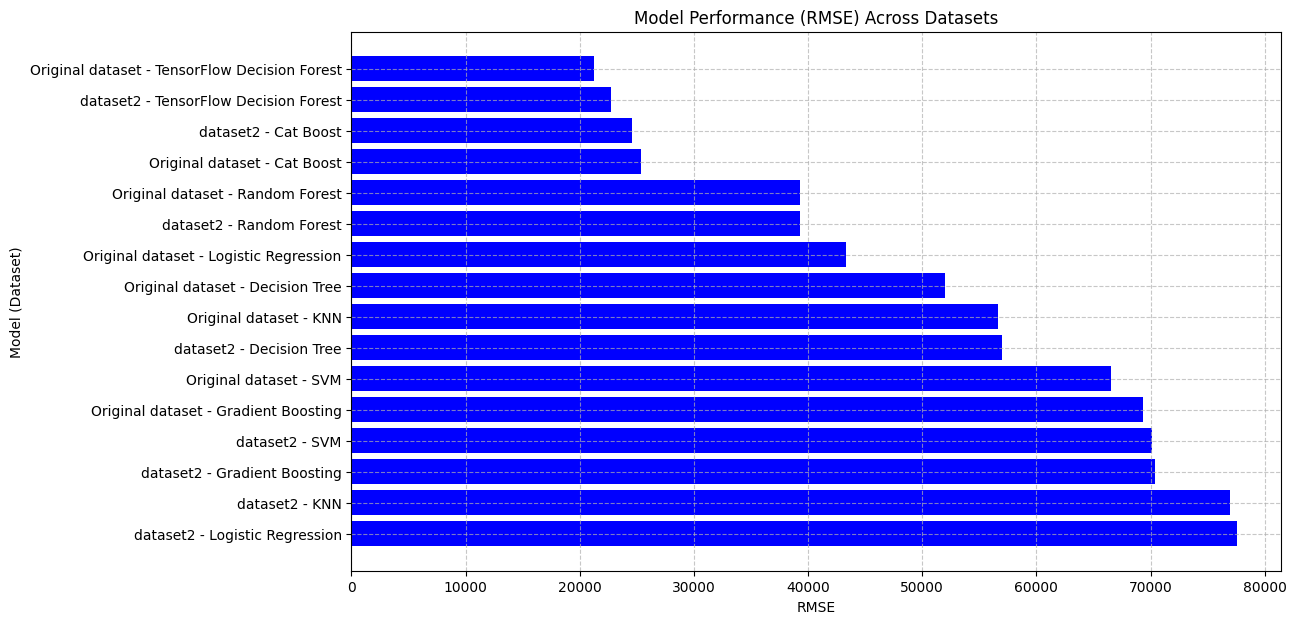

In [21]:
#Call: plot results
updated_data = {
    'Original dataset' if key == False else 'dataset2': value
    for key, value in results.items()
}
print(updated_data)
plot_results(updated_data)

------Fine Tunning TensorFLow--------

In [36]:
#Fine tunning TFDF with Optuna
# Define the Early Stopping mechanism
def objective(trial):
    try:
        # Suggest hyperparameters
        num_trees = trial.suggest_int('num_trees', 100, 600, step=50)
        max_depth = trial.suggest_int('max_depth', 4, 7)
        min_examples = trial.suggest_int('min_examples', 3, 7)
        shrinkage = trial.suggest_float('shrinkage', 0.05, 0.15)
        honest = trial.suggest_categorical('honest', [False])

        # Create model with suggested parameters
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=num_trees,
            max_depth=max_depth,
            min_examples=min_examples,
            shrinkage=shrinkage,
            honest=honest
        )

        # Prepare dataset: split df into train and validation
        train_ds_pd, valid_ds_pd = split_dataset(df)  # Use one consistent split
        
        # Separate features and target
        X_train = train_ds_pd.drop(columns=["SalePrice"])
        y_train = train_ds_pd["SalePrice"]
        X_valid = valid_ds_pd.drop(columns=["SalePrice"])
        y_valid = valid_ds_pd["SalePrice"]

        # Define transformation columns
        categorical_columns = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
        numerical_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

        # Build and fit preprocessor on training data only
        preprocessor = fullPreprocessor("TensorFlow Decision Forest", categorical_columns, numerical_columns, transformer2=False)
        preprocessor.fit(X_train)

        # Transform training and validation data
        X_train_transformed = preprocessor.transform(X_train)
        X_valid_transformed = preprocessor.transform(X_valid)

        X_train_transformed = pd.DataFrame(X_train_transformed, index=X_train.index, columns=[f'feat_{i}' for i in range(X_train_transformed.shape[1])])
        X_valid_transformed = pd.DataFrame(X_valid_transformed, index=X_valid.index, columns=[f'feat_{i}' for i in range(X_valid_transformed.shape[1])])


        # Convert to TF datasets
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
            pd.concat([X_train_transformed, y_train], axis=1),
            label="SalePrice",
            task=tfdf.keras.Task.REGRESSION)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
            pd.concat([X_valid_transformed, y_valid], axis=1),
            label="SalePrice",
            task=tfdf.keras.Task.REGRESSION)

        # Train model
        history = model.fit(train_ds)

        # Predict and evaluate
        predictions = model.predict(valid_ds)
        predictions = [p[0] for p in predictions]
        rmse = np.sqrt(mean_squared_error(y_valid, predictions))

        # Clear memory after trial
        del model, train_ds, valid_ds
        gc.collect()
        tf.keras.backend.clear_session()

        return rmse

    except MemoryError as e:
        print("Memory error occurred:", e)
        tf.keras.backend.clear_session()
        gc.collect()
        return float('inf')
    
    except Exception as e:
        print("An error occurred:", e)
        traceback.print_exc()
        tf.keras.backend.clear_session()
        gc.collect()
        return float('inf')



tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Step 1: Broad Exploration (Random Search)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=100)
print("\nPhase 1 - Random Search: ", study.best_params)

# Step 2: Focused Search (TPE)
study.sampler = optuna.samplers.TPESampler()
study.optimize(objective, n_trials=100)
print("\nPhase 2 - TPE Optimization: ", study.best_params)

# Step 3: Final Fine-Tuning (Bayesian)
study.sampler = optuna.samplers.CmaEsSampler()
study.optimize(objective, n_trials=50)
print("\nPhase 3 - Bayesian Optimization: ", study.best_params)

# Best result
print("\nBest RMSE: ", study.best_value)
print("Best Hyperparameters: ", study.best_params)


[I 2025-02-25 16:30:09,617] A new study created in memory with name: no-name-9500a701-1db3-47cc-82b0-15105375c813


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpngsz99hy as temporary training directory


2025-02-25 16:30:10.061339: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:10.061502: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:10.061505: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:02.077160. Found 1001 examples.
Training model...


I0000 00:00:1740497413.728473 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497413.729905 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497413.729916 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497413.733415 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497413.733421 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497413.734653 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.308721
Compiling model...


I0000 00:00:1740497413.992811 10434695 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 37124.9
2025-02-25 16:30:13.992833: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 73
2025-02-25 16:30:13.995624: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 44 tree(s) i.e. 44  iteration(s).
2025-02-25 16:30:13.995772: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:44 valid-loss:37124.898438 valid-rmse:37124.898438
I0000 00:00:1740497413.996469 10434695 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpngsz99hy with prefix 4898b887cbfb402e
I0000 00:00:1740497413.998134 10434695 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 264ms/step


[I 2025-02-25 16:30:19,478] Trial 0 finished with value: 22036.70901001104 and parameters: {'num_trees': 300, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.1401901247947885, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1mj4e8vx as temporary training directory


2025-02-25 16:30:19.490687: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:19.490764: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:19.490768: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.990698. Found 1001 examples.
Training model...


I0000 00:00:1740497422.105807 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497422.105977 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497422.105982 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497422.106623 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497422.106627 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497422.107300 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.293395
Compiling model...


I0000 00:00:1740497422.383034 10435491 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35571.4
2025-02-25 16:30:22.383062: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 132
2025-02-25 16:30:22.387223: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 103 tree(s) i.e. 103  iteration(s).
2025-02-25 16:30:22.387306: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:103 valid-loss:35571.363281 valid-rmse:35571.363281
I0000 00:00:1740497422.388024 10435491 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1mj4e8vx with prefix fceda05758964bed
I0000 00:00:1740497422.388908 10435491 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 99ms/step


[I 2025-02-25 16:30:24,241] Trial 1 finished with value: 23175.600665363956 and parameters: {'num_trees': 300, 'max_depth': 4, 'min_examples': 7, 'shrinkage': 0.05804750509339294, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpee3v5rrh as temporary training directory


2025-02-25 16:30:24.247615: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:24.247635: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:24.247638: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.745376. Found 1001 examples.
Training model...


I0000 00:00:1740497426.310220 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497426.310240 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497426.310251 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497426.310451 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497426.310457 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497426.311125 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.491106
Compiling model...


I0000 00:00:1740497426.786096 10436722 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34461.8
2025-02-25 16:30:26.786114: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 63
2025-02-25 16:30:26.787597: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 34 tree(s) i.e. 34  iteration(s).
2025-02-25 16:30:26.787749: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:34 valid-loss:34461.847656 valid-rmse:34461.847656
I0000 00:00:1740497426.788422 10436722 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpee3v5rrh with prefix 7ef6a0900537458a
I0000 00:00:1740497426.790395 10436722 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:30:30,817] Trial 2 finished with value: 23467.373169087507 and parameters: {'num_trees': 250, 'max_depth': 7, 'min_examples': 7, 'shrinkage': 0.09414865611816814, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpz2x19y2d as temporary training directory


2025-02-25 16:30:30.838324: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:30.838341: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:30.838345: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.647980. Found 1001 examples.
Training model...


I0000 00:00:1740497432.834651 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497432.834670 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497432.834677 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497432.835204 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497432.835214 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497432.835890 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.263751
Compiling model...


I0000 00:00:1740497433.084443 10437407 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34833.6
2025-02-25 16:30:33.084465: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 41
2025-02-25 16:30:33.085583: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
2025-02-25 16:30:33.085785: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:12 valid-loss:34833.636719 valid-rmse:34833.636719
I0000 00:00:1740497433.086153 10437407 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpz2x19y2d with prefix 513a5ed9a76d4287
I0000 00:00:1740497433.087128 10437407 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:30:35,357] Trial 3 finished with value: 28126.456343617006 and parameters: {'num_trees': 250, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.14397215009900186, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpns2zl7ho as temporary training directory


2025-02-25 16:30:35.371031: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:35.371049: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:35.371053: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.622701. Found 1001 examples.
Training model...


I0000 00:00:1740497437.426961 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497437.426975 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497437.426980 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497437.427179 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497437.427183 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497437.427871 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.489657
Compiling model...


I0000 00:00:1740497437.903984 10437841 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34654.8
2025-02-25 16:30:37.904017: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-25 16:30:37.905426: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-25 16:30:37.905659: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:34654.804688 valid-rmse:34654.804688
I0000 00:00:1740497437.906207 10437841 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpns2zl7ho with prefix 57cca71ac7844b74
I0000 00:00:1740497437.907032 10437841 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:30:40,321] Trial 4 finished with value: 25924.748441114887 and parameters: {'num_trees': 550, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.1130665547681502, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl0h83t3y as temporary training directory


2025-02-25 16:30:40.335367: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:40.335398: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:40.335407: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.657820. Found 1001 examples.
Training model...


I0000 00:00:1740497442.336479 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497442.336498 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497442.336503 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497442.336704 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497442.336710 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497442.337364 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.694763
Compiling model...


I0000 00:00:1740497443.013756 10438321 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35155.6
2025-02-25 16:30:43.013782: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 127
2025-02-25 16:30:43.016298: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 98 tree(s) i.e. 98  iteration(s).
2025-02-25 16:30:43.016504: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:98 valid-loss:35155.566406 valid-rmse:35155.566406
I0000 00:00:1740497443.017336 10438321 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl0h83t3y with prefix 9dc611d439804d67
I0000 00:00:1740497443.018641 10438321 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:30:45,559] Trial 5 finished with value: 23343.69883558912 and parameters: {'num_trees': 450, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.1263444449645269, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps30rbz_f as temporary training directory


2025-02-25 16:30:45.576221: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:45.576258: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:45.576319: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.617093. Found 1001 examples.
Training model...


I0000 00:00:1740497447.509582 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497447.509597 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497447.509604 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497447.509791 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497447.509796 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497447.510460 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.492271
Compiling model...


I0000 00:00:1740497447.987827 10439464 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34631.6
2025-02-25 16:30:47.987849: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 71
2025-02-25 16:30:47.989446: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 42 tree(s) i.e. 42  iteration(s).
2025-02-25 16:30:47.989722: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:42 valid-loss:34631.582031 valid-rmse:34631.582031
I0000 00:00:1740497447.990344 10439464 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps30rbz_f with prefix 1ddb8e36788643d9
I0000 00:00:1740497447.991800 10439464 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:30:50,765] Trial 6 finished with value: 22175.833721948016 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.0850401138982603, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_o5cm3ip as temporary training directory


2025-02-25 16:30:50.781482: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:50.781502: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:50.781505: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.634452. Found 1001 examples.
Training model...


I0000 00:00:1740497452.716551 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497452.716569 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497452.716576 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497452.716779 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497452.716784 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497452.717457 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.359628
Compiling model...


I0000 00:00:1740497453.063839 10440137 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34738.9
2025-02-25 16:30:53.063859: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 96
2025-02-25 16:30:53.065156: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 67 tree(s) i.e. 67  iteration(s).
2025-02-25 16:30:53.065297: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:67 valid-loss:34738.898438 valid-rmse:34738.898438
I0000 00:00:1740497453.065851 10440137 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_o5cm3ip with prefix b88e706a1a7c4662
I0000 00:00:1740497453.066727 10440137 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:30:55,646] Trial 7 finished with value: 22232.611774927267 and parameters: {'num_trees': 350, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.10912120930218056, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt_ftuo8f as temporary training directory


2025-02-25 16:30:55.660473: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:55.660490: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:30:55.660531: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.595134. Found 1001 examples.
Training model...


I0000 00:00:1740497457.577980 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497457.577998 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497457.578002 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497457.578199 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497457.578204 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497457.578887 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.281061
Compiling model...


I0000 00:00:1740497457.847635 10440997 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36424.1
2025-02-25 16:30:57.847655: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 109
2025-02-25 16:30:57.849157: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 80 tree(s) i.e. 80  iteration(s).
2025-02-25 16:30:57.849263: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:80 valid-loss:36424.125000 valid-rmse:36424.125000
I0000 00:00:1740497457.849784 10440997 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt_ftuo8f with prefix dc01a4f9a27e49ee
I0000 00:00:1740497457.850555 10440997 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:31:00,316] Trial 8 finished with value: 23454.92429582525 and parameters: {'num_trees': 600, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.056401636683046166, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj8y0a972 as temporary training directory


2025-02-25 16:31:00.334896: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:00.335023: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:00.335106: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.579819. Found 1001 examples.
Training model...


I0000 00:00:1740497462.235677 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497462.235696 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497462.235705 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497462.235941 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497462.235947 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497462.236639 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.447426
Compiling model...


I0000 00:00:1740497462.668326 10441970 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34895.8
2025-02-25 16:31:02.668354: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-25 16:31:02.670107: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-25 16:31:02.670392: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:34895.832031 valid-rmse:34895.832031
I0000 00:00:1740497462.670943 10441970 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj8y0a972 with prefix 844b61c1b9504794
I0000 00:00:1740497462.671836 10441970 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:31:05,417] Trial 9 finished with value: 26083.460224105995 and parameters: {'num_trees': 450, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.09942762815546866, 'honest': False}. Best is trial 0 with value: 22036.70901001104.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpri3x2_ku as temporary training directory


2025-02-25 16:31:05.430662: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:05.430689: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:05.430692: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.685956. Found 1001 examples.
Training model...


I0000 00:00:1740497467.422261 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497467.422283 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497467.422293 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497467.422506 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497467.422512 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497467.423176 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.646917
Compiling model...


I0000 00:00:1740497468.052211 10442486 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35914
2025-02-25 16:31:08.052231: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 173
2025-02-25 16:31:08.053991: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 144 tree(s) i.e. 144  iteration(s).
2025-02-25 16:31:08.054124: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:144 valid-loss:35914.031250 valid-rmse:35914.031250
I0000 00:00:1740497468.054949 10442486 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpri3x2_ku with prefix 475167a27e354433
I0000 00:00:1740497468.056268 10442486 kernel.cc:944] Save model in resources

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:31:10,733] Trial 10 finished with value: 21273.47308981705 and parameters: {'num_trees': 550, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.0925072162425894, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6y9ay_xg as temporary training directory


2025-02-25 16:31:10.754831: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:10.754849: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:10.754853: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.618481. Found 1001 examples.
Training model...


I0000 00:00:1740497472.704870 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497472.704895 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497472.704900 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497472.705135 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497472.705140 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497472.705796 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.497135
Compiling model...


I0000 00:00:1740497473.187793 10444017 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35168.3
2025-02-25 16:31:13.187825: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 89
2025-02-25 16:31:13.189348: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 60 tree(s) i.e. 60  iteration(s).
2025-02-25 16:31:13.189522: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:60 valid-loss:35168.335938 valid-rmse:35168.335938
I0000 00:00:1740497473.190184 10444017 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6y9ay_xg with prefix c689f23ada9e4479
I0000 00:00:1740497473.191223 10444017 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 92ms/step


[I 2025-02-25 16:31:16,039] Trial 11 finished with value: 21597.086267246017 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.12281595337305458, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9zzdthou as temporary training directory


2025-02-25 16:31:16.060309: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:16.060326: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:16.060330: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.575171. Found 1001 examples.
Training model...


I0000 00:00:1740497477.954587 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497477.954600 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497477.954604 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497477.954784 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497477.954789 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497477.955430 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.307101
Compiling model...


I0000 00:00:1740497478.250055 10444854 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35207.2
2025-02-25 16:31:18.250083: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-25 16:31:18.251230: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-25 16:31:18.251363: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:35207.171875 valid-rmse:35207.171875
I0000 00:00:1740497478.251868 10444854 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9zzdthou with prefix d971cf888e2a492c
I0000 00:00:1740497478.252635 10444854 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:31:20,602] Trial 12 finished with value: 23786.290958409845 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.1039810164284837, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxn0v_eh0 as temporary training directory


2025-02-25 16:31:20.616313: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:20.616346: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:20.616349: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.580097. Found 1001 examples.
Training model...


I0000 00:00:1740497482.525953 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497482.525972 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497482.525982 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497482.526182 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497482.526187 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497482.526813 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.358743
Compiling model...


I0000 00:00:1740497482.872675 10445403 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34676.4
2025-02-25 16:31:22.872699: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:31:22.873960: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:31:22.874148: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:34676.414062 valid-rmse:34676.414062
I0000 00:00:1740497482.874614 10445403 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxn0v_eh0 with prefix f8787267c6174892
I0000 00:00:1740497482.875375 10445403 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:31:25,132] Trial 13 finished with value: 25060.446869331216 and parameters: {'num_trees': 300, 'max_depth': 7, 'min_examples': 7, 'shrinkage': 0.13883602870174483, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_pxeivf as temporary training directory


2025-02-25 16:31:25.149767: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:25.149784: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:25.149788: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.587589. Found 1001 examples.
Training model...


I0000 00:00:1740497487.073134 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497487.073150 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497487.073155 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497487.073364 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497487.073368 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497487.074060 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.673548
Compiling model...


I0000 00:00:1740497487.730098 10445886 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33606.4
2025-02-25 16:31:27.730125: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 89
2025-02-25 16:31:27.731956: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 60 tree(s) i.e. 60  iteration(s).
2025-02-25 16:31:27.732206: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:60 valid-loss:33606.449219 valid-rmse:33606.449219
I0000 00:00:1740497487.733001 10445886 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_pxeivf with prefix 35647f7147044580
I0000 00:00:1740497487.734725 10445886 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-25 16:31:29,737] Trial 14 finished with value: 21743.733263584803 and parameters: {'num_trees': 250, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.07214114283099028, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp97olqvuu as temporary training directory


2025-02-25 16:31:29.745970: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:29.745990: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:29.745994: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.596044. Found 1001 examples.
Training model...


I0000 00:00:1740497491.674640 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497491.674731 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497491.674739 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497491.675123 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497491.675128 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497491.675777 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.378736
Compiling model...


I0000 00:00:1740497492.028773 10446690 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34477.8
2025-02-25 16:31:32.028795: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-25 16:31:32.030989: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-25 16:31:32.031249: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:34477.800781 valid-rmse:34477.800781
I0000 00:00:1740497492.031763 10446690 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp97olqvuu with prefix cded2194c70a47c6
I0000 00:00:1740497492.032498 10446690 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:31:34,346] Trial 15 finished with value: 27875.056842346326 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.1416223759376689, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn5_mrlz_ as temporary training directory


2025-02-25 16:31:34.356049: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:34.356063: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:34.356123: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.583038. Found 1001 examples.
Training model...


I0000 00:00:1740497496.289436 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497496.289446 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497496.289450 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497496.289647 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497496.289651 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497496.290299 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.584980
Compiling model...


I0000 00:00:1740497496.859629 10447125 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34669.9
2025-02-25 16:31:36.859649: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 127
2025-02-25 16:31:36.861766: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 98 tree(s) i.e. 98  iteration(s).
2025-02-25 16:31:36.861890: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:98 valid-loss:34669.875000 valid-rmse:34669.875000
I0000 00:00:1740497496.862591 10447125 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn5_mrlz_ with prefix e453d70e2a854d83
I0000 00:00:1740497496.863762 10447125 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-25 16:31:38,955] Trial 16 finished with value: 22325.1266490971 and parameters: {'num_trees': 200, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.06914766152269476, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp66ipv17n as temporary training directory


2025-02-25 16:31:38.972820: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:38.972858: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:38.972861: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.633193. Found 1001 examples.
Training model...


I0000 00:00:1740497500.925874 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497500.925896 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497500.925903 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497500.926096 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497500.926103 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497500.926762 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.297812
Compiling model...


I0000 00:00:1740497501.211327 10448237 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35245.5
2025-02-25 16:31:41.211345: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 78
2025-02-25 16:31:41.212488: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 49 tree(s) i.e. 49  iteration(s).
2025-02-25 16:31:41.212634: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:49 valid-loss:35245.460938 valid-rmse:35245.460938
I0000 00:00:1740497501.213122 10448237 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp66ipv17n with prefix 97224fdfa4ff4a9b
I0000 00:00:1740497501.213904 10448237 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:31:43,653] Trial 17 finished with value: 22451.64975546681 and parameters: {'num_trees': 300, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.14638025082384248, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpeiiz32do as temporary training directory


2025-02-25 16:31:43.665687: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:43.665704: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:43.665708: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.549318. Found 1001 examples.
Training model...


I0000 00:00:1740497505.538529 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497505.538548 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497505.538552 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497505.538747 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497505.538752 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497505.539405 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.690870
Compiling model...


I0000 00:00:1740497506.211763 10448944 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35015.2
2025-02-25 16:31:46.211784: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:31:46.214680: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-25 16:31:46.214932: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:35015.156250 valid-rmse:35015.156250
I0000 00:00:1740497506.215801 10448944 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpeiiz32do with prefix 39a36697aba3424e
I0000 00:00:1740497506.217382 10448944 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 94ms/step


[I 2025-02-25 16:31:48,544] Trial 18 finished with value: 21669.717636976766 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.05697470140945307, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp29nsvs7g as temporary training directory


2025-02-25 16:31:48.569758: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:48.569793: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:48.569882: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.649861. Found 1001 examples.
Training model...


I0000 00:00:1740497510.544028 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497510.544043 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497510.544050 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497510.544251 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497510.544256 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497510.544894 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.382340
Compiling model...


I0000 00:00:1740497510.913370 10449834 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35067
2025-02-25 16:31:50.913389: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 70
2025-02-25 16:31:50.914700: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 41 tree(s) i.e. 41  iteration(s).
2025-02-25 16:31:50.914876: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:41 valid-loss:35067.023438 valid-rmse:35067.023438
I0000 00:00:1740497510.915407 10449834 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp29nsvs7g with prefix 149cef9dc1ec43f4
I0000 00:00:1740497510.916268 10449834 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:31:53,032] Trial 19 finished with value: 22441.185455854888 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.12016523742819624, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp31uh9hgl as temporary training directory


2025-02-25 16:31:53.042109: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:53.042123: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:53.042126: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.546085. Found 1001 examples.
Training model...


I0000 00:00:1740497514.917476 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497514.917534 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497514.917541 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497514.917965 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497514.917970 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497514.918664 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.267657
Compiling model...


I0000 00:00:1740497515.173106 10450474 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36038.5
2025-02-25 16:31:55.173135: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 68
2025-02-25 16:31:55.174286: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 39 tree(s) i.e. 39  iteration(s).
2025-02-25 16:31:55.174421: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:39 valid-loss:36038.480469 valid-rmse:36038.480469
I0000 00:00:1740497515.174870 10450474 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp31uh9hgl with prefix a3202e4325e84c11
I0000 00:00:1740497515.175776 10450474 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:31:57,500] Trial 20 finished with value: 23925.557432063688 and parameters: {'num_trees': 450, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.08455463515966026, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmvym8kmm as temporary training directory


2025-02-25 16:31:57.509074: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:57.509092: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:31:57.509096: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.547866. Found 1001 examples.
Training model...


I0000 00:00:1740497519.374757 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497519.374770 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497519.374775 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497519.374966 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497519.374971 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497519.375627 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.609897
Compiling model...


I0000 00:00:1740497519.966587 10451107 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34969.8
2025-02-25 16:31:59.966607: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 168
2025-02-25 16:31:59.969626: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 139 tree(s) i.e. 139  iteration(s).
2025-02-25 16:31:59.969764: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:139 valid-loss:34969.832031 valid-rmse:34969.832031
I0000 00:00:1740497519.970611 10451107 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmvym8kmm with prefix 02679ca2ae1d446f
I0000 00:00:1740497519.972619 10451107 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:32:02,150] Trial 21 finished with value: 21486.534459973936 and parameters: {'num_trees': 300, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.06248700114169688, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgq7eh00e as temporary training directory


2025-02-25 16:32:02.171022: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:02.171049: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:02.171052: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.562179. Found 1001 examples.
Training model...


I0000 00:00:1740497524.067083 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497524.067100 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497524.067105 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497524.067302 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497524.067306 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497524.067956 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.211985
Compiling model...


2025-02-25 16:32:04.268499: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:13926.254883 train-rmse:13926.254883 valid-loss:35813.167969 valid-rmse:35813.167969
2025-02-25 16:32:04.268515: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:32:04.269927: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-25 16:32:04.269998: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:35567.117188 valid-rmse:35567.117188
I0000 00:00:1740497524.270440 10452548 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgq7eh00e with prefix e906fb09e6a24c9b
I0

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:32:06,627] Trial 22 finished with value: 21965.961088859985 and parameters: {'num_trees': 100, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.11583476818631167, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdmxt75g5 as temporary training directory


2025-02-25 16:32:06.642287: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:06.642316: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:06.642319: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.526165. Found 1001 examples.
Training model...


I0000 00:00:1740497528.502291 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497528.502311 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497528.502317 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497528.502547 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497528.502554 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497528.503184 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:01.352751
Compiling model...


2025-02-25 16:32:09.826493: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:150 train-loss:3147.473877 train-rmse:3147.473877 valid-loss:34513.820312 valid-rmse:34513.820312
2025-02-25 16:32:09.826508: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 150
2025-02-25 16:32:09.831868: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 136 tree(s) i.e. 136  iteration(s).
2025-02-25 16:32:09.832030: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:136 valid-loss:34450.996094 valid-rmse:34450.996094
I0000 00:00:1740497529.833608 10453437 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdmxt75g5 with prefix 2e1e1b0cecb64707
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:32:12,154] Trial 23 finished with value: 22269.817656237843 and parameters: {'num_trees': 150, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.09429148048942113, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpir5kzq7j as temporary training directory


2025-02-25 16:32:12.171357: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:12.171392: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:12.171396: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.821663. Found 1001 examples.
Training model...


I0000 00:00:1740497534.357798 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497534.357818 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497534.357825 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497534.358013 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497534.358018 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497534.358699 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.492874
Compiling model...


I0000 00:00:1740497534.838351 10454782 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33851.3
2025-02-25 16:32:14.838373: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 40
2025-02-25 16:32:14.839847: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
2025-02-25 16:32:14.840243: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:297] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shr

Model compiled.
1/1 [==============================] - 0s 110ms/step


[I 2025-02-25 16:32:17,420] Trial 24 finished with value: 28200.86895697738 and parameters: {'num_trees': 450, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.14631250018936529, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphvelc442 as temporary training directory


2025-02-25 16:32:17.434127: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:17.434155: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:17.434158: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.678414. Found 1001 examples.
Training model...


I0000 00:00:1740497539.444977 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497539.444991 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497539.444998 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497539.445215 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497539.445220 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497539.445894 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.392714
Compiling model...


I0000 00:00:1740497539.823074 10455201 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35715
2025-02-25 16:32:19.823093: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:32:19.825594: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-25 16:32:19.825751: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:35714.992188 valid-rmse:35714.992188
I0000 00:00:1740497539.826322 10455201 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphvelc442 with prefix d47afab3004c498d
I0000 00:00:1740497539.827271 10455201 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:32:22,066] Trial 25 finished with value: 22591.72766641047 and parameters: {'num_trees': 150, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.06886522075771154, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfb0r9u3t as temporary training directory


2025-02-25 16:32:22.076229: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:22.076249: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:22.076252: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.689453. Found 1001 examples.
Training model...


I0000 00:00:1740497544.117464 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497544.117480 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497544.117491 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497544.117687 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497544.117692 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497544.118329 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.375369
Compiling model...


I0000 00:00:1740497544.480928 10456094 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35412.4
2025-02-25 16:32:24.480949: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 53
2025-02-25 16:32:24.482318: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 24 tree(s) i.e. 24  iteration(s).
2025-02-25 16:32:24.482581: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:24 valid-loss:35412.371094 valid-rmse:35412.371094
I0000 00:00:1740497544.483058 10456094 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfb0r9u3t with prefix ad053293ef72406a
I0000 00:00:1740497544.483834 10456094 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:32:26,814] Trial 26 finished with value: 23174.24558219471 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.12288383144733446, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb8zhegee as temporary training directory


2025-02-25 16:32:26.823227: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:26.823246: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:26.823250: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.541151. Found 1001 examples.
Training model...


I0000 00:00:1740497548.693132 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497548.693145 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497548.693150 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497548.693368 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497548.693373 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497548.694008 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.567044
Compiling model...


I0000 00:00:1740497549.244387 10456617 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34586.8
2025-02-25 16:32:29.244406: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 81
2025-02-25 16:32:29.247321: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 52 tree(s) i.e. 52  iteration(s).
2025-02-25 16:32:29.247608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:52 valid-loss:34586.777344 valid-rmse:34586.777344
I0000 00:00:1740497549.248327 10456617 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb8zhegee with prefix 25ce9abc6b1c4b0e
I0000 00:00:1740497549.249446 10456617 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-25 16:32:31,549] Trial 27 finished with value: 22542.49421197686 and parameters: {'num_trees': 450, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.061503723121966, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0w1e0l4n as temporary training directory


2025-02-25 16:32:31.559158: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:31.559477: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:31.559548: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.561619. Found 1001 examples.
Training model...


I0000 00:00:1740497553.470457 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497553.470472 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497553.470476 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497553.470663 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497553.470668 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497553.471312 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.311773
Compiling model...


I0000 00:00:1740497553.770299 10457349 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34332.7
2025-02-25 16:32:33.770317: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 59
2025-02-25 16:32:33.771597: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 30 tree(s) i.e. 30  iteration(s).
2025-02-25 16:32:33.771738: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:30 valid-loss:34332.714844 valid-rmse:34332.714844
I0000 00:00:1740497553.772220 10457349 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0w1e0l4n with prefix bf0e5c1859584445
I0000 00:00:1740497553.773268 10457349 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:32:36,280] Trial 28 finished with value: 24455.57517226503 and parameters: {'num_trees': 250, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.09796248377308268, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7w3po1b4 as temporary training directory


2025-02-25 16:32:36.288457: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:36.288488: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:36.288491: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.609513. Found 1001 examples.
Training model...


I0000 00:00:1740497558.266995 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497558.267009 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497558.267019 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497558.267217 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497558.267223 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497558.267903 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.271363
Compiling model...


I0000 00:00:1740497558.525510 10457910 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34401.4
2025-02-25 16:32:38.525531: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-25 16:32:38.526894: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-25 16:32:38.527081: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:34401.394531 valid-rmse:34401.394531
I0000 00:00:1740497558.527491 10457910 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7w3po1b4 with prefix 1b5223809eac4bcb
I0000 00:00:1740497558.528603 10457910 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 94ms/step


[I 2025-02-25 16:32:41,009] Trial 29 finished with value: 26506.38894447972 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.14143535928894552, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpy4bt8urx as temporary training directory


2025-02-25 16:32:41.018630: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:41.018648: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:41.018651: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.659934. Found 1001 examples.
Training model...


I0000 00:00:1740497563.024892 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497563.024905 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497563.024910 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497563.025089 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497563.025093 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497563.025770 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.323747
Compiling model...


I0000 00:00:1740497563.335414 10458355 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35860.3
2025-02-25 16:32:43.335436: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 61
2025-02-25 16:32:43.337502: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 32 tree(s) i.e. 32  iteration(s).
2025-02-25 16:32:43.337629: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:32 valid-loss:35860.324219 valid-rmse:35860.324219
I0000 00:00:1740497563.338149 10458355 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpy4bt8urx with prefix 08e7e3a83b0e4c2f
I0000 00:00:1740497563.338988 10458355 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 98ms/step


[I 2025-02-25 16:32:45,549] Trial 30 finished with value: 23146.514852331664 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.1023250550217694, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqml5jqrl as temporary training directory


2025-02-25 16:32:45.564795: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:45.564821: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:45.564825: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.570514. Found 1001 examples.
Training model...


I0000 00:00:1740497567.475330 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497567.475343 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497567.475347 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497567.475534 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497567.475539 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497567.476199 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.554139
Compiling model...


I0000 00:00:1740497568.012836 10458928 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34751
2025-02-25 16:32:48.012856: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 98
2025-02-25 16:32:48.015852: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 69 tree(s) i.e. 69  iteration(s).
2025-02-25 16:32:48.015990: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:69 valid-loss:34751.000000 valid-rmse:34751.000000
I0000 00:00:1740497568.016775 10458928 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqml5jqrl with prefix 82b4990b1cb9433c
I0000 00:00:1740497568.018030 10458928 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:32:50,413] Trial 31 finished with value: 23169.79500564358 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.052649127520058014, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk9i0rjur as temporary training directory


2025-02-25 16:32:50.429942: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:50.429963: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:50.429966: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.555505. Found 1001 examples.
Training model...


I0000 00:00:1740497572.310898 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497572.310910 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497572.310914 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497572.311093 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497572.311097 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497572.311739 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.712366
Compiling model...


I0000 00:00:1740497573.003824 10459817 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34959.2
2025-02-25 16:32:53.003850: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 121
2025-02-25 16:32:53.007994: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 92 tree(s) i.e. 92  iteration(s).
2025-02-25 16:32:53.008228: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:92 valid-loss:34959.230469 valid-rmse:34959.230469
I0000 00:00:1740497573.009117 10459817 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk9i0rjur with prefix 0de9078613e34bf3
I0000 00:00:1740497573.010542 10459817 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:32:55,333] Trial 32 finished with value: 22391.09985722492 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.12823930868206446, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpza8dirx0 as temporary training directory


2025-02-25 16:32:55.354934: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:55.355096: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:55.355099: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.567420. Found 1001 examples.
Training model...


I0000 00:00:1740497577.259237 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497577.259250 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497577.259254 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497577.259431 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497577.259436 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497577.260059 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.232619
Compiling model...


I0000 00:00:1740497577.474831 10460871 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35948.4
2025-02-25 16:32:57.474851: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 103
2025-02-25 16:32:57.476615: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 74 tree(s) i.e. 74  iteration(s).
2025-02-25 16:32:57.476696: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:74 valid-loss:35948.371094 valid-rmse:35948.371094
I0000 00:00:1740497577.477155 10460871 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpza8dirx0 with prefix 313c98aabd904067
I0000 00:00:1740497577.478323 10460871 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:32:59,769] Trial 33 finished with value: 23602.324576079925 and parameters: {'num_trees': 300, 'max_depth': 4, 'min_examples': 4, 'shrinkage': 0.0645571220096165, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb02co5e9 as temporary training directory


2025-02-25 16:32:59.777721: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:59.777740: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:32:59.777743: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.568699. Found 1001 examples.
Training model...


I0000 00:00:1740497581.668617 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497581.668629 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497581.668637 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497581.668817 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497581.668822 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497581.669471 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.336672
Compiling model...


I0000 00:00:1740497581.994247 10461778 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34993.7
2025-02-25 16:33:01.994270: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-25 16:33:01.995550: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-25 16:33:01.995784: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:34993.714844 valid-rmse:34993.714844
I0000 00:00:1740497581.996278 10461778 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb02co5e9 with prefix 7b657889e6a248f2
I0000 00:00:1740497581.996978 10461778 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:33:04,319] Trial 34 finished with value: 27774.54802878082 and parameters: {'num_trees': 400, 'max_depth': 7, 'min_examples': 7, 'shrinkage': 0.1342978147920671, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpub_o1_z3 as temporary training directory


2025-02-25 16:33:04.338249: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:04.338268: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:04.338271: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.668173. Found 1001 examples.
Training model...


I0000 00:00:1740497586.332430 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497586.332444 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497586.332449 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497586.332647 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497586.332653 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497586.333320 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.731354
Compiling model...


I0000 00:00:1740497587.046107 10462198 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35234.8
2025-02-25 16:33:07.046136: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 168
2025-02-25 16:33:07.048049: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 139 tree(s) i.e. 139  iteration(s).
2025-02-25 16:33:07.048174: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:139 valid-loss:35234.769531 valid-rmse:35234.769531
I0000 00:00:1740497587.049107 10462198 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpub_o1_z3 with prefix 1c2963609f6a43a8
I0000 00:00:1740497587.050499 10462198 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 93ms/step


[I 2025-02-25 16:33:09,407] Trial 35 finished with value: 21788.495272531494 and parameters: {'num_trees': 200, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.054981156875242854, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpje222w5q as temporary training directory


2025-02-25 16:33:09.432733: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:09.432760: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:09.432763: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.546886. Found 1001 examples.
Training model...


I0000 00:00:1740497591.307321 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497591.307334 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497591.307338 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497591.307551 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497591.307556 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497591.308188 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.585086
Compiling model...


I0000 00:00:1740497591.876362 10463667 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35118.5
2025-02-25 16:33:11.876385: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-25 16:33:11.879543: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-25 16:33:11.879963: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:35118.500000 valid-rmse:35118.500000
I0000 00:00:1740497591.880591 10463667 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpje222w5q with prefix 3ab64d6689004f90
I0000 00:00:1740497591.881578 10463667 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:33:14,436] Trial 36 finished with value: 28961.35428176088 and parameters: {'num_trees': 550, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.07256969359618332, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_99fses_ as temporary training directory


2025-02-25 16:33:14.454243: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:14.454341: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:14.454526: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.557736. Found 1001 examples.
Training model...


I0000 00:00:1740497596.350564 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497596.350608 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497596.350620 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497596.351077 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497596.351085 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497596.351739 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.642562
Compiling model...


I0000 00:00:1740497596.976161 10464203 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34808
2025-02-25 16:33:16.976181: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 62
2025-02-25 16:33:16.978050: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 33 tree(s) i.e. 33  iteration(s).
2025-02-25 16:33:16.978356: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:33 valid-loss:34808.015625 valid-rmse:34808.015625
I0000 00:00:1740497596.979111 10464203 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_99fses_ with prefix 92924b04a6c14a7b
I0000 00:00:1740497596.980335 10464203 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:33:19,350] Trial 37 finished with value: 26006.266989499953 and parameters: {'num_trees': 200, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.06178271333570154, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpthpekr8v as temporary training directory


2025-02-25 16:33:19.359465: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:19.359488: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:19.359491: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.579117. Found 1001 examples.
Training model...


I0000 00:00:1740497601.274921 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497601.274936 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497601.274945 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497601.275143 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497601.275149 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497601.275800 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.203123
Compiling model...


I0000 00:00:1740497601.475609 10050045 abstract_model.cc:1404] Engine "GradientBoostedTreesQuickScorerExtended" built
2025-02-25 16:33:21.475632: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:33:23,480] Trial 38 finished with value: 24071.431866399555 and parameters: {'num_trees': 350, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.12510335998615735, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8di0xkgj as temporary training directory


2025-02-25 16:33:23.488910: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:23.488923: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:23.488926: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.631575. Found 1001 examples.
Training model...


I0000 00:00:1740497605.445656 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497605.445669 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497605.445674 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497605.445863 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497605.445868 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497605.446528 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.505784
Compiling model...


I0000 00:00:1740497605.938014 10465611 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34877.1
2025-02-25 16:33:25.938042: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-25 16:33:25.939553: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-25 16:33:25.939917: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:34877.078125 valid-rmse:34877.078125
I0000 00:00:1740497605.940390 10465611 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8di0xkgj with prefix f2e74c9487264a00
I0000 00:00:1740497605.941131 10465611 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:33:28,190] Trial 39 finished with value: 27732.08012496873 and parameters: {'num_trees': 450, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.11298554123874836, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpenarx0ui as temporary training directory


2025-02-25 16:33:28.202523: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:28.202559: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:28.202562: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.564985. Found 1001 examples.
Training model...


I0000 00:00:1740497610.129588 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497610.129602 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497610.129608 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497610.129798 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497610.129802 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497610.130476 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.494772
Compiling model...


I0000 00:00:1740497610.611203 10466053 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34844
2025-02-25 16:33:30.611230: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:33:30.613201: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:33:30.613625: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:34843.953125 valid-rmse:34843.953125
I0000 00:00:1740497610.614127 10466053 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpenarx0ui with prefix 1b048b7bcd2f47d0
I0000 00:00:1740497610.615182 10466053 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:33:33,099] Trial 40 finished with value: 25898.24798696455 and parameters: {'num_trees': 200, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.12921532146940817, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm7yexkx1 as temporary training directory


2025-02-25 16:33:33.109031: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:33.109045: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:33.109048: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.585828. Found 1001 examples.
Training model...


I0000 00:00:1740497615.020502 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497615.020515 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497615.020523 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497615.020714 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497615.020718 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497615.021341 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.349433
Compiling model...


I0000 00:00:1740497615.357120 10466500 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35908.4
2025-02-25 16:33:35.357141: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 90
2025-02-25 16:33:35.358476: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 61 tree(s) i.e. 61  iteration(s).
2025-02-25 16:33:35.358608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:61 valid-loss:35908.363281 valid-rmse:35908.363281
I0000 00:00:1740497615.359147 10466500 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm7yexkx1 with prefix 2768fc502caf45c5
I0000 00:00:1740497615.360018 10466500 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-25 16:33:37,612] Trial 41 finished with value: 22797.289207826925 and parameters: {'num_trees': 200, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.07447124308236656, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4o3sghzq as temporary training directory


2025-02-25 16:33:37.625630: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:37.625663: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:37.625666: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.681576. Found 1001 examples.
Training model...


I0000 00:00:1740497619.656166 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497619.656186 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497619.656192 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497619.656427 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497619.656433 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497619.657104 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.362267
Compiling model...


I0000 00:00:1740497620.004773 10467299 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36343.1
2025-02-25 16:33:40.004799: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:33:40.006066: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-25 16:33:40.006211: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:36343.140625 valid-rmse:36343.140625
I0000 00:00:1740497620.006767 10467299 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4o3sghzq with prefix 65ae911614da4b63
I0000 00:00:1740497620.007648 10467299 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:33:42,424] Trial 42 finished with value: 21642.420378962368 and parameters: {'num_trees': 550, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.13970364828687873, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp05ieh2_b as temporary training directory


2025-02-25 16:33:42.439678: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:42.439695: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:42.439698: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.603243. Found 1001 examples.
Training model...


I0000 00:00:1740497624.432319 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497624.432332 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497624.432338 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497624.432538 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497624.432544 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497624.433185 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.244112
Compiling model...


I0000 00:00:1740497624.664683 10468187 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35199.6
2025-02-25 16:33:44.664731: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:33:44.666808: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:33:44.666964: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:35199.625000 valid-rmse:35199.625000
I0000 00:00:1740497624.667358 10468187 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp05ieh2_b with prefix 0d07c5885acb4adf
I0000 00:00:1740497624.668420 10468187 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:33:46,993] Trial 43 finished with value: 25838.348219711883 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.14452981350019922, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps_of59p4 as temporary training directory


2025-02-25 16:33:47.009836: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:47.009854: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:47.009858: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.548274. Found 1001 examples.
Training model...


I0000 00:00:1740497628.890972 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497628.890983 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497628.890987 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497628.891177 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497628.891182 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497628.891830 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.207565
Compiling model...


I0000 00:00:1740497629.091330 10050045 abstract_model.cc:914] Model self evaluation:
Number of predictions (with weights): 1
Task: REGRESSION
Loss (SQUARED_ERROR): 35638.7

RMSE: 188.782
Default RMSE: : 0

2025-02-25 16:33:49.094636: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps_of59p4/model/ with prefix 2db87323dcd84fc0
I0000 00:00:1740497629.096112 10050045 abstract_model.cc:1404] Engine "GradientBoostedTreesQuickScorerExtended" built
2025-02-25 16:33:49.096136: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:33:51,474] Trial 44 finished with value: 23449.499166299327 and parameters: {'num_trees': 500, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.1129155198958592, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbw0tzpau as temporary training directory


2025-02-25 16:33:51.483813: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:51.483830: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:51.483834: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.540847. Found 1001 examples.
Training model...


I0000 00:00:1740497633.370576 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497633.370591 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497633.370595 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497633.370764 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497633.370769 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497633.371418 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.362479
Compiling model...


I0000 00:00:1740497633.720666 10469462 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35104.9
2025-02-25 16:33:53.720692: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-25 16:33:53.723148: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-25 16:33:53.723409: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:35104.917969 valid-rmse:35104.917969
I0000 00:00:1740497633.723875 10469462 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbw0tzpau with prefix 295800902cdf41de
I0000 00:00:1740497633.724605 10469462 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:33:56,104] Trial 45 finished with value: 26467.902033186292 and parameters: {'num_trees': 450, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.08904370837868265, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgnhfk787 as temporary training directory


2025-02-25 16:33:56.114034: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:56.114058: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:33:56.114061: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.625407. Found 1001 examples.
Training model...


I0000 00:00:1740497638.132595 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497638.132609 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497638.132614 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497638.132825 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497638.132829 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497638.133489 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.864116
Compiling model...


I0000 00:00:1740497638.979830 10469984 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34472.4
2025-02-25 16:33:58.979859: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-25 16:33:58.982057: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-25 16:33:58.982455: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:34472.363281 valid-rmse:34472.363281
I0000 00:00:1740497638.983250 10469984 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgnhfk787 with prefix 063b8e13aed349ce
I0000 00:00:1740497638.984518 10469984 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:34:01,343] Trial 46 finished with value: 22972.798975784885 and parameters: {'num_trees': 200, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.07793077466988546, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpozadw7uy as temporary training directory


2025-02-25 16:34:01.357284: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:01.357322: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:01.357325: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.676089. Found 1001 examples.
Training model...


I0000 00:00:1740497643.376519 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497643.376535 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497643.376540 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497643.376736 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497643.376741 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497643.377382 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.325180
Compiling model...


I0000 00:00:1740497643.677008 10470610 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35669.7
2025-02-25 16:34:03.677029: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 145
2025-02-25 16:34:03.678920: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 116 tree(s) i.e. 116  iteration(s).
2025-02-25 16:34:03.679004: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:116 valid-loss:35669.742188 valid-rmse:35669.742188
I0000 00:00:1740497643.679611 10470610 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpozadw7uy with prefix b9c1895ce6a34063
I0000 00:00:1740497643.680819 10470610 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:34:06,042] Trial 47 finished with value: 22762.627839103694 and parameters: {'num_trees': 550, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.06341569104353603, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_2gl316s as temporary training directory


2025-02-25 16:34:06.057963: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:06.057980: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:06.057983: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.561724. Found 1001 examples.
Training model...


I0000 00:00:1740497647.951298 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497647.951313 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497647.951317 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497647.951526 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497647.951530 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497647.952180 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.504299
Compiling model...


I0000 00:00:1740497648.441290 10471868 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35644.7
2025-02-25 16:34:08.441313: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 88
2025-02-25 16:34:08.442859: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 59 tree(s) i.e. 59  iteration(s).
2025-02-25 16:34:08.443012: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:59 valid-loss:35644.714844 valid-rmse:35644.714844
I0000 00:00:1740497648.443671 10471868 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_2gl316s with prefix ac6819502cdd48f8
I0000 00:00:1740497648.444688 10471868 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:34:10,917] Trial 48 finished with value: 22614.892524353036 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.08999478928747308, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphw8em_q7 as temporary training directory


2025-02-25 16:34:10.932667: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:10.932697: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:10.932701: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.597011. Found 1001 examples.
Training model...


I0000 00:00:1740497652.883013 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497652.883025 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497652.883030 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497652.883226 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497652.883230 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497652.883877 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.238439
Compiling model...


I0000 00:00:1740497653.111055 10472706 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36062.1
2025-02-25 16:34:13.111076: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 60
2025-02-25 16:34:13.112223: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
2025-02-25 16:34:13.112371: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:31 valid-loss:36062.070312 valid-rmse:36062.070312
I0000 00:00:1740497653.112776 10472706 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphw8em_q7 with prefix be2949e1e45340ec
I0000 00:00:1740497653.113449 10472706 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:34:15,966] Trial 49 finished with value: 23442.742610016394 and parameters: {'num_trees': 350, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.1375738534543134, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1h0198qq as temporary training directory


2025-02-25 16:34:15.976557: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:15.976577: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:15.976581: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.611166. Found 1001 examples.
Training model...


I0000 00:00:1740497657.909985 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497657.910046 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497657.910054 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497657.910361 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497657.910366 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497657.911072 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.417794
Compiling model...


I0000 00:00:1740497658.313343 10473302 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35524.3
2025-02-25 16:34:18.313366: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 172
2025-02-25 16:34:18.315677: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 143 tree(s) i.e. 143  iteration(s).
2025-02-25 16:34:18.315757: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:143 valid-loss:35524.300781 valid-rmse:35524.300781
I0000 00:00:1740497658.316429 10473302 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1h0198qq with prefix cf744526f1f54091
I0000 00:00:1740497658.317568 10473302 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:34:20,720] Trial 50 finished with value: 22320.186179615754 and parameters: {'num_trees': 200, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.05997676168885048, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl1yltuqf as temporary training directory


2025-02-25 16:34:20.732454: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:20.732499: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:20.732504: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.559221. Found 1001 examples.
Training model...


I0000 00:00:1740497662.667610 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497662.667625 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497662.667630 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497662.667833 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497662.667838 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497662.668467 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.313494
Compiling model...


I0000 00:00:1740497662.970045 10474766 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35455.8
2025-02-25 16:34:22.970064: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 85
2025-02-25 16:34:22.971304: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 56 tree(s) i.e. 56  iteration(s).
2025-02-25 16:34:22.971440: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:56 valid-loss:35455.769531 valid-rmse:35455.769531
I0000 00:00:1740497662.971926 10474766 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl1yltuqf with prefix 97c3e95f32ea43fd
I0000 00:00:1740497662.972693 10474766 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:34:25,424] Trial 51 finished with value: 22122.83211437303 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.12585541091306224, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppocfoiki as temporary training directory


2025-02-25 16:34:25.440032: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:25.440053: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:25.440056: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.590832. Found 1001 examples.
Training model...


I0000 00:00:1740497667.380900 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497667.380917 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497667.380923 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497667.381118 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497667.381122 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497667.381763 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.395219
Compiling model...


I0000 00:00:1740497667.762667 10475540 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34564.6
2025-02-25 16:34:27.762688: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 73
2025-02-25 16:34:27.764090: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 44 tree(s) i.e. 44  iteration(s).
2025-02-25 16:34:27.764215: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:44 valid-loss:34564.601562 valid-rmse:34564.601562
I0000 00:00:1740497667.764781 10475540 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppocfoiki with prefix 199bb6d040c94ac3
I0000 00:00:1740497667.765716 10475540 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:34:30,317] Trial 52 finished with value: 22427.301605763892 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.07903841694232497, 'honest': False}. Best is trial 10 with value: 21273.47308981705.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcbmkyy47 as temporary training directory


2025-02-25 16:34:30.331675: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:30.331694: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:30.331697: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.546799. Found 1001 examples.
Training model...


I0000 00:00:1740497672.211726 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497672.211742 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497672.211746 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497672.211938 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497672.211945 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497672.212608 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.468684
Compiling model...


I0000 00:00:1740497672.665404 10476217 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33957.6
2025-02-25 16:34:32.665431: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 84
2025-02-25 16:34:32.666962: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 55 tree(s) i.e. 55  iteration(s).
2025-02-25 16:34:32.667146: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:55 valid-loss:33957.597656 valid-rmse:33957.597656
I0000 00:00:1740497672.667763 10476217 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcbmkyy47 with prefix 5216e082d295436c
I0000 00:00:1740497672.670916 10476217 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:34:35,112] Trial 53 finished with value: 21233.170849312664 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1255740948517588, 'honest': False}. Best is trial 53 with value: 21233.170849312664.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp473fo7qw as temporary training directory


2025-02-25 16:34:35.136225: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:35.136257: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:35.136261: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.678192. Found 1001 examples.
Training model...


I0000 00:00:1740497677.170209 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497677.170224 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497677.170228 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497677.170421 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497677.170426 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497677.171050 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.687958
Compiling model...


I0000 00:00:1740497677.842289 10477004 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33150.3
2025-02-25 16:34:37.842310: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 92
2025-02-25 16:34:37.844540: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 63 tree(s) i.e. 63  iteration(s).
2025-02-25 16:34:37.844763: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:63 valid-loss:33150.328125 valid-rmse:33150.328125
I0000 00:00:1740497677.845485 10477004 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp473fo7qw with prefix 7444ef764354417d
I0000 00:00:1740497677.846667 10477004 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:34:40,210] Trial 54 finished with value: 22045.66684518191 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.12699624662630787, 'honest': False}. Best is trial 53 with value: 21233.170849312664.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4zba0161 as temporary training directory


2025-02-25 16:34:40.221744: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:40.221832: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:40.221883: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.579775. Found 1001 examples.
Training model...


I0000 00:00:1740497682.155158 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497682.155176 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497682.155180 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497682.155377 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497682.155385 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497682.156046 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.713126
Compiling model...


I0000 00:00:1740497682.851139 10477832 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35034.7
2025-02-25 16:34:42.851165: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 63
2025-02-25 16:34:42.853792: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 34 tree(s) i.e. 34  iteration(s).
2025-02-25 16:34:42.854128: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:34 valid-loss:35034.699219 valid-rmse:35034.699219
I0000 00:00:1740497682.854873 10477832 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4zba0161 with prefix d46b9979c4f44b98
I0000 00:00:1740497682.856062 10477832 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:34:45,364] Trial 55 finished with value: 28006.73935508523 and parameters: {'num_trees': 250, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.05385756346236631, 'honest': False}. Best is trial 53 with value: 21233.170849312664.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptqiw6g90 as temporary training directory


2025-02-25 16:34:45.372704: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:45.372721: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:45.372725: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.545462. Found 1001 examples.
Training model...


I0000 00:00:1740497687.268015 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497687.268928 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497687.268937 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497687.269584 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497687.269589 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497687.270236 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.298542
Compiling model...


I0000 00:00:1740497687.553906 10478426 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33845.2
2025-02-25 16:34:47.553925: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 77
2025-02-25 16:34:47.555175: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 48 tree(s) i.e. 48  iteration(s).
2025-02-25 16:34:47.555324: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:48 valid-loss:33845.179688 valid-rmse:33845.179688
I0000 00:00:1740497687.555779 10478426 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptqiw6g90 with prefix bb89f961305a4c76
I0000 00:00:1740497687.556536 10478426 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:34:49,951] Trial 56 finished with value: 22366.16311162074 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.11930306855725413, 'honest': False}. Best is trial 53 with value: 21233.170849312664.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2frr3bxu as temporary training directory


2025-02-25 16:34:49.975507: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:49.975528: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:49.975531: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.663879. Found 1001 examples.
Training model...


I0000 00:00:1740497691.968058 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497691.968073 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497691.968082 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497691.968296 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497691.968300 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497691.968992 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.547581
Compiling model...


I0000 00:00:1740497692.500363 10479124 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33817
2025-02-25 16:34:52.500381: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 92
2025-02-25 16:34:52.502927: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 63 tree(s) i.e. 63  iteration(s).
2025-02-25 16:34:52.503112: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:63 valid-loss:33816.996094 valid-rmse:33816.996094
I0000 00:00:1740497692.503776 10479124 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2frr3bxu with prefix e2a72ce2c25a4c93
I0000 00:00:1740497692.504845 10479124 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:34:54,899] Trial 57 finished with value: 21024.88489330439 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11482949795985856, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4_kr5iz6 as temporary training directory


2025-02-25 16:34:54.925196: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:54.925214: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:54.925218: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.556132. Found 1001 examples.
Training model...


I0000 00:00:1740497696.818884 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497696.818894 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497696.818902 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497696.819102 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497696.819109 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497696.819730 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.266300
Compiling model...


I0000 00:00:1740497697.073398 10479956 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35232.1
2025-02-25 16:34:57.073419: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:34:57.074845: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:34:57.075027: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:35232.082031 valid-rmse:35232.082031
I0000 00:00:1740497697.075459 10479956 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4_kr5iz6 with prefix 83cf9b85cb6f4cfe
I0000 00:00:1740497697.077066 10479956 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:34:59,546] Trial 58 finished with value: 26076.390035137283 and parameters: {'num_trees': 450, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.1298945132084139, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5cwuyzd5 as temporary training directory


2025-02-25 16:34:59.557032: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:59.557069: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:34:59.557084: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.596357. Found 1001 examples.
Training model...


I0000 00:00:1740497701.490290 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497701.490303 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497701.490307 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497701.490497 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497701.490502 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497701.491147 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.369119
Compiling model...


I0000 00:00:1740497701.847119 10480406 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35526.1
2025-02-25 16:35:01.847142: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 54
2025-02-25 16:35:01.849271: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 25 tree(s) i.e. 25  iteration(s).
2025-02-25 16:35:01.849521: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:25 valid-loss:35526.070312 valid-rmse:35526.070312
I0000 00:00:1740497701.849982 10480406 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5cwuyzd5 with prefix 919e38a806144a39
I0000 00:00:1740497701.850750 10480406 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:35:04,261] Trial 59 finished with value: 25073.82570942371 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.09528244776216457, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpys6kroo6 as temporary training directory


2025-02-25 16:35:04.271046: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:04.271069: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:04.271078: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.671966. Found 1001 examples.
Training model...
Model trained in 0:00:00.158406
Compiling model...


I0000 00:00:1740497706.264389 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497706.264411 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497706.264417 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497706.264636 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497706.264642 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497706.265323 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:35:08,809] Trial 60 finished with value: 24531.683798957718 and parameters: {'num_trees': 100, 'max_depth': 4, 'min_examples': 5, 'shrinkage': 0.10044963524616268, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4eoijzv1 as temporary training directory


2025-02-25 16:35:08.817505: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:08.817540: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:08.817543: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.550586. Found 1001 examples.
Training model...
Model trained in 0:00:00.161133
Compiling model...


I0000 00:00:1740497710.707987 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497710.708000 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497710.708004 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497710.708199 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497710.708204 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497710.708873 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:35:13,360] Trial 61 finished with value: 24589.999223027848 and parameters: {'num_trees': 450, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.1320932749451848, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3px_v3di as temporary training directory


2025-02-25 16:35:13.375868: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:13.375984: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:13.375992: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.573371. Found 1001 examples.
Training model...


I0000 00:00:1740497715.279279 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497715.279299 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497715.279308 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497715.279509 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497715.279514 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497715.280195 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.394210
Compiling model...


I0000 00:00:1740497715.657199 10482260 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36208
2025-02-25 16:35:15.657229: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 108
2025-02-25 16:35:15.661329: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 79 tree(s) i.e. 79  iteration(s).
2025-02-25 16:35:15.661457: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:79 valid-loss:36208.031250 valid-rmse:36208.031250
I0000 00:00:1740497715.662016 10482260 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3px_v3di with prefix 30cb048f94584214
I0000 00:00:1740497715.662955 10482260 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-25 16:35:18,312] Trial 62 finished with value: 22125.98728491419 and parameters: {'num_trees': 350, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.12861073242430798, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprolgl7fe as temporary training directory


2025-02-25 16:35:18.321514: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:18.321530: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:18.321533: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.713579. Found 1001 examples.
Training model...


I0000 00:00:1740497720.356670 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497720.356686 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497720.356691 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497720.356888 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497720.356893 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497720.357568 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.213541
Compiling model...


2025-02-25 16:35:20.559015: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:14804.456055 train-rmse:14804.456055 valid-loss:35182.195312 valid-rmse:35182.195312
2025-02-25 16:35:20.559028: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:35:20.560300: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-25 16:35:20.560380: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:35014.136719 valid-rmse:35014.136719
I0000 00:00:1740497720.560829 10483208 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprolgl7fe with prefix 85454502516840d5
I0

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:35:24,313] Trial 63 finished with value: 22847.710008230948 and parameters: {'num_trees': 100, 'max_depth': 4, 'min_examples': 7, 'shrinkage': 0.09493462203750347, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt46cdkwu as temporary training directory


2025-02-25 16:35:24.324369: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:24.324388: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:24.324391: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.709556. Found 1001 examples.
Training model...


I0000 00:00:1740497726.414883 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497726.414902 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497726.414911 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497726.415110 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497726.415115 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497726.415781 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.561618
Compiling model...


2025-02-25 16:35:26.960039: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:9505.324219 train-rmse:9505.324219 valid-loss:34591.613281 valid-rmse:34591.613281
2025-02-25 16:35:26.960058: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:35:26.961710: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 95 tree(s) i.e. 95  iteration(s).
2025-02-25 16:35:26.961749: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:95 valid-loss:34564.492188 valid-rmse:34564.492188
I0000 00:00:1740497726.962620 10484231 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt46cdkwu with prefix ac73b7e4ce10495c
I000

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:35:29,411] Trial 64 finished with value: 21493.811476013827 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.07131308086697673, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl1rs3lv9 as temporary training directory


2025-02-25 16:35:29.420247: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:29.420263: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:29.420266: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.555911. Found 1001 examples.
Training model...


I0000 00:00:1740497731.310866 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497731.310883 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497731.310888 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497731.311057 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497731.311063 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497731.311714 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.486276
Compiling model...


I0000 00:00:1740497731.780938 10485111 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34497.3
2025-02-25 16:35:31.780960: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 128
2025-02-25 16:35:31.783336: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 99 tree(s) i.e. 99  iteration(s).
2025-02-25 16:35:31.783475: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:99 valid-loss:34497.281250 valid-rmse:34497.281250
I0000 00:00:1740497731.784229 10485111 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl1rs3lv9 with prefix 133ce92c6b6e4e8a
I0000 00:00:1740497731.786108 10485111 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:35:34,277] Trial 65 finished with value: 21834.336573156117 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.06749208232355255, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfdnzzrs6 as temporary training directory


2025-02-25 16:35:34.288584: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:34.288601: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:34.288604: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.587887. Found 1001 examples.
Training model...


I0000 00:00:1740497736.232335 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497736.232348 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497736.232353 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497736.232542 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497736.232547 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497736.233191 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.485170
Compiling model...


I0000 00:00:1740497736.700737 10486225 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34297.8
2025-02-25 16:35:36.700773: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 72
2025-02-25 16:35:36.702442: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 43 tree(s) i.e. 43  iteration(s).
2025-02-25 16:35:36.702690: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:43 valid-loss:34297.808594 valid-rmse:34297.808594
I0000 00:00:1740497736.703323 10486225 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfdnzzrs6 with prefix e7aa682c38114fb4
I0000 00:00:1740497736.704438 10486225 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:35:39,099] Trial 66 finished with value: 21235.371352674727 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.1081986220233218, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmhf0kk0l as temporary training directory


2025-02-25 16:35:39.118691: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:39.118715: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:39.118718: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.773768. Found 1001 examples.
Training model...


I0000 00:00:1740497741.253284 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497741.253302 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497741.253311 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497741.253519 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497741.253523 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497741.254180 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.239558
Compiling model...


I0000 00:00:1740497741.481562 10486886 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35373.4
2025-02-25 16:35:41.481585: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-25 16:35:41.482748: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-25 16:35:41.482914: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:35373.398438 valid-rmse:35373.398438
I0000 00:00:1740497741.483321 10486886 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmhf0kk0l with prefix 782808fd22a44f82
I0000 00:00:1740497741.484653 10486886 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:35:43,917] Trial 67 finished with value: 26902.842162398196 and parameters: {'num_trees': 250, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.1446428950774736, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjxmd1rcd as temporary training directory


2025-02-25 16:35:43.928972: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:43.929018: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:43.929022: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.574445. Found 1001 examples.
Training model...


I0000 00:00:1740497745.849795 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497745.849810 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497745.849816 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497745.850005 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497745.850012 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497745.850651 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.522547
Compiling model...


I0000 00:00:1740497746.358839 10487328 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34401.6
2025-02-25 16:35:46.358863: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:35:46.362143: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:35:46.362375: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:34401.558594 valid-rmse:34401.558594
I0000 00:00:1740497746.362887 10487328 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjxmd1rcd with prefix 3f30cd73267a4453
I0000 00:00:1740497746.363682 10487328 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:35:48,829] Trial 68 finished with value: 25489.657918964047 and parameters: {'num_trees': 200, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.1314689782710703, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpehucdlki as temporary training directory


2025-02-25 16:35:48.846995: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:48.847013: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:48.847016: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.662914. Found 1001 examples.
Training model...


I0000 00:00:1740497750.834981 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497750.834999 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497750.835005 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497750.835231 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497750.835237 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497750.835902 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:01.005600
Compiling model...


I0000 00:00:1740497751.819413 10487777 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35426.5
2025-02-25 16:35:51.819439: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 182
2025-02-25 16:35:51.822476: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 153 tree(s) i.e. 153  iteration(s).
2025-02-25 16:35:51.822673: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:153 valid-loss:35426.484375 valid-rmse:35426.484375
I0000 00:00:1740497751.823789 10487777 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpehucdlki with prefix 2faf7189c6f9467e
I0000 00:00:1740497751.825579 10487777 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:35:54,238] Trial 69 finished with value: 22216.87089910567 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.07347407439367284, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjc4w34xh as temporary training directory


2025-02-25 16:35:54.258109: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:54.258140: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:54.258144: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.610699. Found 1001 examples.
Training model...


I0000 00:00:1740497756.265115 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497756.265130 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497756.265137 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497756.265330 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497756.265335 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497756.265992 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.438052
Compiling model...


I0000 00:00:1740497756.688765 10489333 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36130.6
2025-02-25 16:35:56.688789: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 127
2025-02-25 16:35:56.691102: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 98 tree(s) i.e. 98  iteration(s).
2025-02-25 16:35:56.691243: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:98 valid-loss:36130.648438 valid-rmse:36130.648438
I0000 00:00:1740497756.691901 10489333 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjc4w34xh with prefix f2dd75d23d374209
I0000 00:00:1740497756.692928 10489333 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:35:58,992] Trial 70 finished with value: 22039.419767508836 and parameters: {'num_trees': 150, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.114399601023301, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd8pcz9l7 as temporary training directory


2025-02-25 16:35:59.008989: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:59.009010: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:35:59.009013: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.666909. Found 1001 examples.
Training model...


I0000 00:00:1740497761.035422 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497761.035435 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497761.035443 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497761.035655 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497761.035662 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497761.036343 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.360994
Compiling model...


I0000 00:00:1740497761.383890 10490439 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34107.7
2025-02-25 16:36:01.383911: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:36:01.385263: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:36:01.385470: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:34107.726562 valid-rmse:34107.726562
I0000 00:00:1740497761.385963 10490439 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd8pcz9l7 with prefix f6415738e8d5453d
I0000 00:00:1740497761.387416 10490439 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:36:03,648] Trial 71 finished with value: 25890.424950730536 and parameters: {'num_trees': 150, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.125726090336586, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqgaushp3 as temporary training directory


2025-02-25 16:36:03.657389: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:03.657405: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:03.657409: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.600018. Found 1001 examples.
Training model...


I0000 00:00:1740497765.581624 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497765.581639 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497765.581645 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497765.581853 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497765.581858 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497765.582529 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.424927
Compiling model...


I0000 00:00:1740497765.994986 10490885 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36289.2
2025-02-25 16:36:05.995016: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-25 16:36:05.997340: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-25 16:36:05.997611: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:36289.175781 valid-rmse:36289.175781
I0000 00:00:1740497765.998015 10490885 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqgaushp3 with prefix 72d1ee44ea294caf
I0000 00:00:1740497765.998620 10490885 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:36:08,227] Trial 72 finished with value: 29064.172989687064 and parameters: {'num_trees': 250, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.1288458036834047, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj238dax1 as temporary training directory


2025-02-25 16:36:08.235057: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:08.235077: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:08.235080: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.557172. Found 1001 examples.
Training model...


I0000 00:00:1740497770.152083 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497770.152095 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497770.152100 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497770.152289 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497770.152295 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497770.152943 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.498468
Compiling model...


I0000 00:00:1740497770.637400 10491322 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34455.2
2025-02-25 16:36:10.637420: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:36:10.639039: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:36:10.639451: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:34455.160156 valid-rmse:34455.160156
I0000 00:00:1740497770.639971 10491322 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj238dax1 with prefix fe51991beebb4af9
I0000 00:00:1740497770.641398 10491322 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-25 16:36:13,208] Trial 73 finished with value: 24663.737380293802 and parameters: {'num_trees': 450, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.14613879349661002, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvexjp0ht as temporary training directory


2025-02-25 16:36:13.218791: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:13.218810: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:13.218813: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.585789. Found 1001 examples.
Training model...


I0000 00:00:1740497775.135014 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497775.135028 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497775.135036 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497775.135230 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497775.135235 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497775.135881 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.378874
Compiling model...


I0000 00:00:1740497775.502117 10491779 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34594.4
2025-02-25 16:36:15.502140: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 41
2025-02-25 16:36:15.503524: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
2025-02-25 16:36:15.503805: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:12 valid-loss:34594.449219 valid-rmse:34594.449219
I0000 00:00:1740497775.504224 10491779 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvexjp0ht with prefix 615cb57b24e240e9
I0000 00:00:1740497775.505377 10491779 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:36:18,086] Trial 74 finished with value: 28599.547168001805 and parameters: {'num_trees': 250, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.1368002917727213, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp37uoen20 as temporary training directory


2025-02-25 16:36:18.096545: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:18.096688: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:18.096695: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.579225. Found 1001 examples.
Training model...


I0000 00:00:1740497780.017900 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497780.017917 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497780.017921 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497780.018096 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497780.018100 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497780.018758 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.471853
Compiling model...


I0000 00:00:1740497780.445580 10492222 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35544.6
2025-02-25 16:36:20.445603: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 200
2025-02-25 16:36:20.447260: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 171 tree(s) i.e. 171  iteration(s).
2025-02-25 16:36:20.447363: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:171 valid-loss:35544.582031 valid-rmse:35544.582031
I0000 00:00:1740497780.448128 10492222 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp37uoen20 with prefix 879a78b717ff4810
I0000 00:00:1740497780.449949 10492222 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:36:23,147] Trial 75 finished with value: 22721.03059600377 and parameters: {'num_trees': 250, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.10509270919251432, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9g5uab05 as temporary training directory


2025-02-25 16:36:23.168547: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:23.168564: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:23.168568: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.578943. Found 1001 examples.
Training model...


I0000 00:00:1740497785.082391 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497785.082404 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497785.082409 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497785.082612 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497785.082620 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497785.083281 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.334144
Compiling model...


I0000 00:00:1740497785.405017 10493916 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36680.3
2025-02-25 16:36:25.405039: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 53
2025-02-25 16:36:25.406319: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 24 tree(s) i.e. 24  iteration(s).
2025-02-25 16:36:25.406518: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:24 valid-loss:36680.316406 valid-rmse:36680.316406
I0000 00:00:1740497785.406986 10493916 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9g5uab05 with prefix ab5af6a426bb4b9c
I0000 00:00:1740497785.407755 10493916 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:36:27,882] Trial 76 finished with value: 27142.50193363423 and parameters: {'num_trees': 450, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.08712940952655682, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl9spuv74 as temporary training directory


2025-02-25 16:36:27.893761: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:27.893876: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:27.893881: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.563745. Found 1001 examples.
Training model...


I0000 00:00:1740497789.785378 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497789.785394 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497789.785398 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497789.785588 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497789.785592 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497789.786240 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.249671
Compiling model...


I0000 00:00:1740497790.022631 10494452 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35889.6
2025-02-25 16:36:30.022656: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 115
2025-02-25 16:36:30.025144: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 86 tree(s) i.e. 86  iteration(s).
2025-02-25 16:36:30.025234: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:86 valid-loss:35889.566406 valid-rmse:35889.566406
I0000 00:00:1740497790.025709 10494452 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl9spuv74 with prefix a027658661464311
I0000 00:00:1740497790.026450 10494452 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:36:32,504] Trial 77 finished with value: 22659.707108269085 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.12133545424753604, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc41nfzvd as temporary training directory


2025-02-25 16:36:32.514655: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:32.514668: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:32.514671: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.582608. Found 1001 examples.
Training model...


I0000 00:00:1740497794.432474 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497794.432487 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497794.432492 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497794.432682 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497794.432686 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497794.433334 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.404438
Compiling model...


2025-02-25 16:36:34.824408: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:8705.397461 train-rmse:8705.397461 valid-loss:36823.414062 valid-rmse:36823.414062
2025-02-25 16:36:34.824424: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:36:34.825734: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 72 tree(s) i.e. 72  iteration(s).
2025-02-25 16:36:34.825857: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:72 valid-loss:36476.542969 valid-rmse:36476.542969
I0000 00:00:1740497794.826414 10495451 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc41nfzvd with prefix b81427276bec47b3
I000

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:36:37,267] Trial 78 finished with value: 21607.33075913509 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.14395444632767407, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp72dqf8dj as temporary training directory


2025-02-25 16:36:37.281892: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:37.281918: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:37.281922: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.574112. Found 1001 examples.
Training model...


I0000 00:00:1740497799.279126 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497799.279138 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497799.279142 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497799.279362 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497799.279367 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497799.280043 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.384083
Compiling model...


I0000 00:00:1740497799.650657 10496335 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35597.7
2025-02-25 16:36:39.650677: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 66
2025-02-25 16:36:39.652082: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
2025-02-25 16:36:39.652280: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:37 valid-loss:35597.687500 valid-rmse:35597.687500
I0000 00:00:1740497799.652844 10496335 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp72dqf8dj with prefix ddf15e5b2885497c
I0000 00:00:1740497799.653694 10496335 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:36:43,128] Trial 79 finished with value: 22144.24655903737 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11275327759838961, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplh5m_oa6 as temporary training directory


2025-02-25 16:36:43.143789: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:43.143807: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:43.143810: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.614107. Found 1001 examples.
Training model...


I0000 00:00:1740497805.086036 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497805.086052 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497805.086056 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497805.086238 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497805.086245 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497805.086898 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.726752
Compiling model...


I0000 00:00:1740497805.794054 10496962 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35127.5
2025-02-25 16:36:45.794084: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-25 16:36:45.797491: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-25 16:36:45.797847: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:35127.542969 valid-rmse:35127.542969
I0000 00:00:1740497805.798796 10496962 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplh5m_oa6 with prefix bd9fada8790546bd
I0000 00:00:1740497805.800725 10496962 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:36:48,388] Trial 80 finished with value: 25262.917354340036 and parameters: {'num_trees': 450, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.05998318469182467, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmfeqmj43 as temporary training directory


2025-02-25 16:36:48.410117: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:48.410176: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:48.410180: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.577887. Found 1001 examples.
Training model...


I0000 00:00:1740497810.430773 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497810.430788 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497810.430799 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497810.431004 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497810.431009 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497810.431665 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.309227
Compiling model...


I0000 00:00:1740497810.729579 10497583 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35993.3
2025-02-25 16:36:50.729611: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 43
2025-02-25 16:36:50.730733: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 14 tree(s) i.e. 14  iteration(s).
2025-02-25 16:36:50.730917: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:14 valid-loss:35993.339844 valid-rmse:35993.339844
I0000 00:00:1740497810.731304 10497583 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmfeqmj43 with prefix f9957685a8784c36
I0000 00:00:1740497810.732275 10497583 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:36:53,193] Trial 81 finished with value: 26563.971738441167 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.14790720013509015, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt65rjbk8 as temporary training directory


2025-02-25 16:36:53.203107: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:53.203128: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:53.203131: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.679746. Found 1001 examples.
Training model...


I0000 00:00:1740497815.214530 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497815.214544 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497815.214552 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497815.214756 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497815.214760 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497815.215435 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.671028
Compiling model...


I0000 00:00:1740497815.869453 10498035 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34961.6
2025-02-25 16:36:55.869474: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 98
2025-02-25 16:36:55.872252: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 69 tree(s) i.e. 69  iteration(s).
2025-02-25 16:36:55.872486: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:69 valid-loss:34961.605469 valid-rmse:34961.605469
I0000 00:00:1740497815.873180 10498035 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt65rjbk8 with prefix dc36761b81de41aa
I0000 00:00:1740497815.874464 10498035 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:36:58,394] Trial 82 finished with value: 21573.0204445957 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.14961587608321586, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3viyzq5m as temporary training directory


2025-02-25 16:36:58.426832: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:58.426863: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:36:58.426866: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.674215. Found 1001 examples.
Training model...


I0000 00:00:1740497820.427728 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497820.427744 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497820.427752 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497820.427947 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497820.427952 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497820.428603 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.342231
Compiling model...


I0000 00:00:1740497820.755824 10498915 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34448.3
2025-02-25 16:37:00.755845: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 165
2025-02-25 16:37:00.757920: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 136 tree(s) i.e. 136  iteration(s).
2025-02-25 16:37:00.758010: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:136 valid-loss:34448.343750 valid-rmse:34448.343750
I0000 00:00:1740497820.758808 10498915 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3viyzq5m with prefix 9e8aa32f3d6a4557
I0000 00:00:1740497820.759737 10498915 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:37:03,336] Trial 83 finished with value: 21899.96850523411 and parameters: {'num_trees': 250, 'max_depth': 4, 'min_examples': 5, 'shrinkage': 0.14718952710420305, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm2erh43j as temporary training directory


2025-02-25 16:37:03.348862: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:03.349001: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:03.349155: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.695280. Found 1001 examples.
Training model...


I0000 00:00:1740497825.380651 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497825.380669 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497825.380676 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497825.380873 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497825.380878 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497825.381548 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.525686
Compiling model...


I0000 00:00:1740497825.891680 10500332 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35430.8
2025-02-25 16:37:05.891704: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 83
2025-02-25 16:37:05.893255: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 54 tree(s) i.e. 54  iteration(s).
2025-02-25 16:37:05.893391: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:54 valid-loss:35430.792969 valid-rmse:35430.792969
I0000 00:00:1740497825.894064 10500332 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm2erh43j with prefix b0706fd9052c46fc
I0000 00:00:1740497825.895157 10500332 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:37:09,096] Trial 84 finished with value: 23681.60402835919 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.06679573964142616, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn494i9t1 as temporary training directory


2025-02-25 16:37:09.121568: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:09.121621: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:09.121680: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.689245. Found 1001 examples.
Training model...


I0000 00:00:1740497831.337713 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497831.337744 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497831.337749 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497831.337987 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497831.337993 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497831.338659 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.615620
Compiling model...


I0000 00:00:1740497831.937495 10501179 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33720
2025-02-25 16:37:11.937517: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-25 16:37:11.940936: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-25 16:37:11.941373: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:33720.007812 valid-rmse:33720.007812
I0000 00:00:1740497831.941946 10501179 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn494i9t1 with prefix 928c07cf54244604
I0000 00:00:1740497831.942960 10501179 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:37:14,573] Trial 85 finished with value: 26596.213884832272 and parameters: {'num_trees': 450, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.09486175306333128, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_3sgo3nr as temporary training directory


2025-02-25 16:37:14.587007: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:14.587025: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:14.587028: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.679300. Found 1001 examples.
Training model...


I0000 00:00:1740497836.594570 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497836.594589 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497836.594596 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497836.594814 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497836.594820 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497836.595509 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.251992
Compiling model...


I0000 00:00:1740497836.833801 10501648 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35402.4
2025-02-25 16:37:16.833820: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 119
2025-02-25 16:37:16.835914: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 90 tree(s) i.e. 90  iteration(s).
2025-02-25 16:37:16.836004: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:90 valid-loss:35402.441406 valid-rmse:35402.441406
I0000 00:00:1740497836.836535 10501648 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_3sgo3nr with prefix 56f6b5af09544214
I0000 00:00:1740497836.837807 10501648 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:37:19,460] Trial 86 finished with value: 21689.126055099354 and parameters: {'num_trees': 450, 'max_depth': 4, 'min_examples': 5, 'shrinkage': 0.1293576825443114, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjnq5fqo3 as temporary training directory


2025-02-25 16:37:19.472505: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:19.472638: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:19.472643: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.715139. Found 1001 examples.
Training model...


I0000 00:00:1740497841.518031 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497841.518047 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497841.518054 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497841.518250 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497841.518256 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497841.518924 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.876150
Compiling model...


I0000 00:00:1740497842.376047 10502685 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34052.1
2025-02-25 16:37:22.376067: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 140
2025-02-25 16:37:22.378677: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 111 tree(s) i.e. 111  iteration(s).
2025-02-25 16:37:22.378897: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:111 valid-loss:34052.097656 valid-rmse:34052.097656
I0000 00:00:1740497842.379868 10502685 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjnq5fqo3 with prefix 9b1ad888eca241f7
I0000 00:00:1740497842.381373 10502685 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:37:24,876] Trial 87 finished with value: 21446.400958533824 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.13359226066422275, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu_il14xc as temporary training directory


2025-02-25 16:37:24.888268: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:24.888312: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:24.888316: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.672925. Found 1001 examples.
Training model...


I0000 00:00:1740497846.901883 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497846.901901 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497846.901909 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497846.902121 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497846.902129 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497846.902801 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.262187
Compiling model...


I0000 00:00:1740497847.149436 10503904 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35945.6
2025-02-25 16:37:27.149456: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:37:27.151344: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:37:27.151512: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:35945.613281 valid-rmse:35945.613281
I0000 00:00:1740497847.151896 10503904 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu_il14xc with prefix 6433485f655f4576
I0000 00:00:1740497847.152517 10503904 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:37:29,638] Trial 88 finished with value: 26205.20395598709 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.13297170826721688, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplw9zs_w4 as temporary training directory


2025-02-25 16:37:29.657089: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:29.657124: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:29.657155: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.802781. Found 1001 examples.
Training model...


I0000 00:00:1740497851.832828 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497851.832848 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497851.832859 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497851.833065 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497851.833071 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497851.833736 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.532096
Compiling model...


I0000 00:00:1740497852.349365 10504363 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34705.5
2025-02-25 16:37:32.349389: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 89
2025-02-25 16:37:32.351005: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 60 tree(s) i.e. 60  iteration(s).
2025-02-25 16:37:32.351203: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:60 valid-loss:34705.488281 valid-rmse:34705.488281
I0000 00:00:1740497852.351887 10504363 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplw9zs_w4 with prefix eb2cb99d3ba64cd3
I0000 00:00:1740497852.353232 10504363 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:37:35,061] Trial 89 finished with value: 21904.642049156395 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11748705296612724, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps8irkm1d as temporary training directory


2025-02-25 16:37:35.070541: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:35.070560: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:35.070564: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.737735. Found 1001 examples.
Training model...


I0000 00:00:1740497857.147102 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497857.147118 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497857.147124 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497857.147327 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497857.147332 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497857.148006 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.289332
Compiling model...


I0000 00:00:1740497857.423229 10505179 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35258.8
2025-02-25 16:37:37.423248: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-25 16:37:37.425117: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-25 16:37:37.425200: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:35258.792969 valid-rmse:35258.792969
I0000 00:00:1740497857.425760 10505179 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps8irkm1d with prefix aaa4fee5fe5b4662
I0000 00:00:1740497857.426859 10505179 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:37:40,089] Trial 90 finished with value: 22501.191133105043 and parameters: {'num_trees': 600, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.07688702227845466, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3779puzl as temporary training directory


2025-02-25 16:37:40.100379: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:40.100395: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:40.100399: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.772484. Found 1001 examples.
Training model...


I0000 00:00:1740497862.217684 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497862.217701 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497862.217710 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497862.217907 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497862.217913 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497862.218566 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.625362
Compiling model...


I0000 00:00:1740497862.827527 10506337 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35554.7
2025-02-25 16:37:42.827549: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 51
2025-02-25 16:37:42.830754: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 22 tree(s) i.e. 22  iteration(s).
2025-02-25 16:37:42.831143: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:22 valid-loss:35554.703125 valid-rmse:35554.703125
I0000 00:00:1740497862.831795 10506337 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3779puzl with prefix 7ac523829a6247e8
I0000 00:00:1740497862.832814 10506337 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:37:45,327] Trial 91 finished with value: 29611.094318939613 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.07180031508639119, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkvlmezgm as temporary training directory


2025-02-25 16:37:45.349280: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:45.349298: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:45.349301: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.673222. Found 1001 examples.
Training model...


I0000 00:00:1740497867.352473 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497867.352487 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497867.352491 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497867.352666 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497867.352670 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497867.353291 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.759169
Compiling model...


I0000 00:00:1740497868.094015 10506831 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34458.2
2025-02-25 16:37:48.094040: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 78
2025-02-25 16:37:48.096178: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 49 tree(s) i.e. 49  iteration(s).
2025-02-25 16:37:48.096488: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:49 valid-loss:34458.210938 valid-rmse:34458.210938
I0000 00:00:1740497868.097357 10506831 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkvlmezgm with prefix 0ae411824f944a4b
I0000 00:00:1740497868.099401 10506831 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:37:50,945] Trial 92 finished with value: 22387.72932219517 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.12938253300379737, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdwwkbrcu as temporary training directory


2025-02-25 16:37:50.954129: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:50.954148: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:50.954151: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.671975. Found 1001 examples.
Training model...


I0000 00:00:1740497872.967514 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497872.967526 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497872.967533 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497872.967714 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497872.967718 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497872.968390 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.225714
Compiling model...


I0000 00:00:1740497873.180947 10507567 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35168.3
2025-02-25 16:37:53.180971: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-25 16:37:53.183131: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-25 16:37:53.183309: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:35168.281250 valid-rmse:35168.281250
I0000 00:00:1740497873.183727 10507567 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdwwkbrcu with prefix 5ce77b640f7b470f
I0000 00:00:1740497873.184702 10507567 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:37:56,067] Trial 93 finished with value: 23647.495129364976 and parameters: {'num_trees': 400, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.14764625431161976, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpllmntgfp as temporary training directory


2025-02-25 16:37:56.083851: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:56.083880: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:37:56.083883: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.599754. Found 1001 examples.
Training model...


I0000 00:00:1740497878.029836 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497878.029849 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497878.029854 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497878.030036 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497878.030041 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497878.030692 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.513560
Compiling model...


I0000 00:00:1740497878.527764 10508108 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35302.6
2025-02-25 16:37:58.527792: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 91
2025-02-25 16:37:58.530200: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2025-02-25 16:37:58.530344: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:62 valid-loss:35302.585938 valid-rmse:35302.585938
I0000 00:00:1740497878.531054 10508108 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpllmntgfp with prefix a0a4d5dcb1c54eea
I0000 00:00:1740497878.532205 10508108 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:38:01,224] Trial 94 finished with value: 23295.787667882316 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.06746693096240985, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp32hch06c as temporary training directory


2025-02-25 16:38:01.233645: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:01.233663: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:01.233666: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.594157. Found 1001 examples.
Training model...


I0000 00:00:1740497883.154143 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497883.154155 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497883.154159 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497883.154345 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497883.154349 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497883.154979 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.657815
Compiling model...


I0000 00:00:1740497883.795714 10508921 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35201
2025-02-25 16:38:03.795748: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 56
2025-02-25 16:38:03.798859: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
2025-02-25 16:38:03.799197: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:27 valid-loss:35200.953125 valid-rmse:35200.953125
I0000 00:00:1740497883.799973 10508921 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp32hch06c with prefix 3f4cc7f20ea24a70
I0000 00:00:1740497883.801520 10508921 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:38:06,498] Trial 95 finished with value: 27312.888784618088 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.0710673509368441, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbxnh_q2t as temporary training directory


2025-02-25 16:38:06.516014: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:06.516044: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:06.516154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.572896. Found 1001 examples.
Training model...
Model trained in 0:00:00.170286
Compiling model...


I0000 00:00:1740497888.428441 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497888.428457 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497888.428461 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497888.428652 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497888.428657 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497888.429310 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 93ms/step


[I 2025-02-25 16:38:11,328] Trial 96 finished with value: 29741.692851126787 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.1469578910303304, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvptmc98c as temporary training directory


2025-02-25 16:38:11.352055: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:11.352100: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:11.352104: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.650432. Found 1001 examples.
Training model...


I0000 00:00:1740497893.316730 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497893.316752 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497893.316757 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497893.316953 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497893.316958 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497893.317604 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.626861
Compiling model...


I0000 00:00:1740497893.927123 10509940 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34789.4
2025-02-25 16:38:13.927145: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-25 16:38:13.930225: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-25 16:38:13.930608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:34789.363281 valid-rmse:34789.363281
I0000 00:00:1740497893.931316 10509940 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvptmc98c with prefix bd2b6f7bde9248a4
I0000 00:00:1740497893.932434 10509940 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:38:16,512] Trial 97 finished with value: 30166.66694611622 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.053159543955872246, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnbv_wmwd as temporary training directory


2025-02-25 16:38:16.537399: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:16.537419: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:16.537422: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.694979. Found 1001 examples.
Training model...


I0000 00:00:1740497898.562794 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497898.562807 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497898.562812 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497898.563017 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497898.563021 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497898.563699 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.313187
Compiling model...


2025-02-25 16:38:18.862361: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:150 train-loss:10501.835938 train-rmse:10501.835938 valid-loss:35002.382812 valid-rmse:35002.382812
2025-02-25 16:38:18.862376: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 150
2025-02-25 16:38:18.863632: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 150 tree(s) i.e. 150  iteration(s).
2025-02-25 16:38:18.863638: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:150 valid-loss:35002.382812 valid-rmse:35002.382812
I0000 00:00:1740497898.864316 10510506 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnbv_wmwd with prefix d3b68ff01b2b4f6f

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:38:21,379] Trial 98 finished with value: 21717.82543006747 and parameters: {'num_trees': 150, 'max_depth': 4, 'min_examples': 5, 'shrinkage': 0.12257570495031637, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp03ap8_16 as temporary training directory


2025-02-25 16:38:21.395065: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:21.395154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:21.395185: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.652834. Found 1001 examples.
Training model...


I0000 00:00:1740497903.401868 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497903.401881 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497903.401885 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497903.402090 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497903.402094 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497903.402769 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.489730
Compiling model...


I0000 00:00:1740497903.875739 10511795 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35576.9
2025-02-25 16:38:23.875762: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 68
2025-02-25 16:38:23.878790: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 39 tree(s) i.e. 39  iteration(s).
2025-02-25 16:38:23.878928: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:39 valid-loss:35576.851562 valid-rmse:35576.851562
I0000 00:00:1740497903.879619 10511795 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp03ap8_16 with prefix bc2aa63c89d947fd
I0000 00:00:1740497903.880691 10511795 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:38:26,427] Trial 99 finished with value: 22478.489672370542 and parameters: {'num_trees': 150, 'max_depth': 7, 'min_examples': 7, 'shrinkage': 0.10088750164217758, 'honest': False}. Best is trial 57 with value: 21024.88489330439.



Phase 1 - Random Search:  {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11482949795985856, 'honest': False}
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp97wipiio as temporary training directory


2025-02-25 16:38:26.492865: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:26.492883: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:26.492886: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.702321. Found 1001 examples.
Training model...


I0000 00:00:1740497908.518927 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497908.518941 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497908.518949 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497908.519141 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497908.519147 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497908.519832 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.567462
Compiling model...


I0000 00:00:1740497909.069954 10512443 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34721.3
2025-02-25 16:38:29.069975: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 94
2025-02-25 16:38:29.071686: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 65 tree(s) i.e. 65  iteration(s).
2025-02-25 16:38:29.071863: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:65 valid-loss:34721.285156 valid-rmse:34721.285156
I0000 00:00:1740497909.072627 10512443 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp97wipiio with prefix d78c819b9eaf4e44
I0000 00:00:1740497909.074492 10512443 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:38:31,777] Trial 100 finished with value: 22794.93466702974 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.050343065837880216, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0yyeygip as temporary training directory


2025-02-25 16:38:31.819781: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:31.819798: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:31.819802: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.691136. Found 1001 examples.
Training model...


I0000 00:00:1740497913.836712 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497913.836726 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497913.836733 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497913.836940 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497913.836945 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497913.837628 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.264282
Compiling model...


I0000 00:00:1740497914.088077 10513285 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35979.6
2025-02-25 16:38:34.088099: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-25 16:38:34.089990: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-25 16:38:34.090134: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:35979.578125 valid-rmse:35979.578125
I0000 00:00:1740497914.090556 10513285 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0yyeygip with prefix 72bae5a786c241e2
I0000 00:00:1740497914.091685 10513285 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:38:36,676] Trial 101 finished with value: 23025.003822711635 and parameters: {'num_trees': 550, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.10744284350826021, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6bw1b0jm as temporary training directory


2025-02-25 16:38:36.726036: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:36.726055: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:36.726058: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.692966. Found 1001 examples.
Training model...
Model trained in 0:00:00.192076
Compiling model...


I0000 00:00:1740497918.765231 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497918.765250 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497918.765259 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497918.765473 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497918.765478 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497918.766134 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:38:41,920] Trial 102 finished with value: 25947.858073625513 and parameters: {'num_trees': 550, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.14183788408505832, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg9q4izvp as temporary training directory


2025-02-25 16:38:41.954112: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:41.954129: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:41.954132: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.692142. Found 1001 examples.
Training model...


I0000 00:00:1740497923.983918 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497923.983933 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497923.983941 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497923.984125 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497923.984131 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497923.984794 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.433237
Compiling model...


I0000 00:00:1740497924.401964 10514379 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34982.7
2025-02-25 16:38:44.401992: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 120
2025-02-25 16:38:44.404891: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 91 tree(s) i.e. 91  iteration(s).
2025-02-25 16:38:44.405020: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:91 valid-loss:34982.660156 valid-rmse:34982.660156
I0000 00:00:1740497924.405694 10514379 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg9q4izvp with prefix d31292333fc34634
I0000 00:00:1740497924.406737 10514379 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:38:47,153] Trial 103 finished with value: 21971.334310739418 and parameters: {'num_trees': 300, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.10976785368013216, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkygzw8vj as temporary training directory


2025-02-25 16:38:47.191678: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:47.191716: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:47.191733: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.715462. Found 1001 examples.
Training model...
Model trained in 0:00:00.194002
Compiling model...


I0000 00:00:1740497929.235333 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497929.235348 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497929.235352 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497929.235530 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497929.235535 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497929.236196 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:38:52,218] Trial 104 finished with value: 25027.386203217924 and parameters: {'num_trees': 550, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.14023479902137898, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplyvzvmi9 as temporary training directory


2025-02-25 16:38:52.261196: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:52.261329: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:52.261332: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.714992. Found 1001 examples.
Training model...


I0000 00:00:1740497934.302751 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497934.302764 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497934.302768 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497934.302961 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497934.302967 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497934.303640 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.434888
Compiling model...


I0000 00:00:1740497934.723473 10515914 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35905
2025-02-25 16:38:54.723501: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 82
2025-02-25 16:38:54.725505: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2025-02-25 16:38:54.725689: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:53 valid-loss:35905.039062 valid-rmse:35905.039062
I0000 00:00:1740497934.726325 10515914 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplyvzvmi9 with prefix 5bc9e39b3a0f43a0
I0000 00:00:1740497934.727423 10515914 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:38:57,451] Trial 105 finished with value: 21202.595432546583 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1432672873736623, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt_o6qgvb as temporary training directory


2025-02-25 16:38:57.487658: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:57.487684: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:38:57.487687: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.724029. Found 1001 examples.
Training model...


I0000 00:00:1740497939.545036 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497939.545052 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497939.545058 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497939.545266 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497939.545271 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497939.545955 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.297883
Compiling model...


I0000 00:00:1740497939.831784 10516665 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36000
2025-02-25 16:38:59.831804: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-25 16:38:59.833044: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-25 16:38:59.833290: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:36000.000000 valid-rmse:36000.000000
I0000 00:00:1740497939.833650 10516665 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpt_o6qgvb with prefix f601eea2c68d44b7
I0000 00:00:1740497939.834787 10516665 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:39:02,436] Trial 106 finished with value: 27926.122790667156 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.13482913046945724, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk_w5r5j7 as temporary training directory


2025-02-25 16:39:02.472973: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:02.472990: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:02.472997: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.692053. Found 1001 examples.
Training model...


I0000 00:00:1740497944.496302 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497944.496316 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497944.496324 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497944.496521 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497944.496526 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497944.497227 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.432879
Compiling model...


I0000 00:00:1740497944.915900 10517086 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34699.3
2025-02-25 16:39:04.915928: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 80
2025-02-25 16:39:04.917384: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 51 tree(s) i.e. 51  iteration(s).
2025-02-25 16:39:04.917577: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:51 valid-loss:34699.253906 valid-rmse:34699.253906
I0000 00:00:1740497944.918142 10517086 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk_w5r5j7 with prefix f469143daeb84205
I0000 00:00:1740497944.919034 10517086 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:39:07,717] Trial 107 finished with value: 21740.694185123943 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1499175683699086, 'honest': False}. Best is trial 57 with value: 21024.88489330439.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7t0taids as temporary training directory


2025-02-25 16:39:07.750032: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:07.750117: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:07.750121: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.674813. Found 1001 examples.
Training model...


I0000 00:00:1740497949.788207 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497949.788225 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497949.788229 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497949.788441 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497949.788447 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497949.789141 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.686260
Compiling model...


I0000 00:00:1740497950.460359 10517826 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33900.7
2025-02-25 16:39:10.460384: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 82
2025-02-25 16:39:10.461907: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2025-02-25 16:39:10.462098: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:53 valid-loss:33900.742188 valid-rmse:33900.742188
I0000 00:00:1740497950.462754 10517826 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7t0taids with prefix 2ed222b452bf463b
I0000 00:00:1740497950.464419 10517826 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:39:13,291] Trial 108 finished with value: 20842.617240968775 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11868664161023114, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkzn8471u as temporary training directory


2025-02-25 16:39:13.332168: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:13.332204: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:13.332208: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.724986. Found 1001 examples.
Training model...


I0000 00:00:1740497955.395593 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497955.395616 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497955.395623 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497955.395848 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497955.395853 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497955.396519 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.508581
Compiling model...


I0000 00:00:1740497955.888887 10518589 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35310.1
2025-02-25 16:39:15.888906: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 90
2025-02-25 16:39:15.891101: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 61 tree(s) i.e. 61  iteration(s).
2025-02-25 16:39:15.891323: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:61 valid-loss:35310.105469 valid-rmse:35310.105469
I0000 00:00:1740497955.892000 10518589 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkzn8471u with prefix def75aa0c7244466
I0000 00:00:1740497955.893084 10518589 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:39:18,629] Trial 109 finished with value: 22041.253362767988 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11663754060459339, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmpzdhgpc as temporary training directory


2025-02-25 16:39:18.666029: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:18.666128: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:18.666256: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.675120. Found 1001 examples.
Training model...


I0000 00:00:1740497960.663837 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497960.663852 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497960.663857 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497960.664058 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497960.664063 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497960.664709 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.479843
Compiling model...


I0000 00:00:1740497961.128263 10519398 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33845
2025-02-25 16:39:21.128284: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 88
2025-02-25 16:39:21.130988: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 59 tree(s) i.e. 59  iteration(s).
2025-02-25 16:39:21.131190: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:59 valid-loss:33844.992188 valid-rmse:33844.992188
I0000 00:00:1740497961.131833 10519398 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmpzdhgpc with prefix 218545eb828646df
I0000 00:00:1740497961.132870 10519398 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 93ms/step


[I 2025-02-25 16:39:23,811] Trial 110 finished with value: 21532.22179595744 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11950655677721281, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5ogskh21 as temporary training directory


2025-02-25 16:39:23.861013: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:23.861033: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:23.861036: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.696607. Found 1001 examples.
Training model...


I0000 00:00:1740497965.887481 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497965.887494 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497965.887501 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497965.887713 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497965.887720 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497965.888382 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.318917
Compiling model...


I0000 00:00:1740497966.193614 10520192 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35063.2
2025-02-25 16:39:26.193632: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 54
2025-02-25 16:39:26.195810: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 25 tree(s) i.e. 25  iteration(s).
2025-02-25 16:39:26.196015: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:25 valid-loss:35063.207031 valid-rmse:35063.207031
I0000 00:00:1740497966.196491 10520192 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5ogskh21 with prefix ad38d739f6b549e5
I0000 00:00:1740497966.197249 10520192 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:39:28,889] Trial 111 finished with value: 23497.16394766354 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.12410610028060513, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmznt7g6u as temporary training directory


2025-02-25 16:39:28.921210: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:28.921237: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:28.921240: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.699190. Found 1001 examples.
Training model...


I0000 00:00:1740497970.948344 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497970.948363 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497970.948373 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497970.948576 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497970.948581 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497970.949246 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.436581
Compiling model...


I0000 00:00:1740497971.371154 10520714 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34638.7
2025-02-25 16:39:31.371181: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 65
2025-02-25 16:39:31.372507: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 36 tree(s) i.e. 36  iteration(s).
2025-02-25 16:39:31.372686: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:36 valid-loss:34638.675781 valid-rmse:34638.675781
I0000 00:00:1740497971.373233 10520714 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmznt7g6u with prefix e296095148ed4573
I0000 00:00:1740497971.375192 10520714 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:39:34,115] Trial 112 finished with value: 21752.253115009742 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11075305134235176, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9y6v9r3i as temporary training directory


2025-02-25 16:39:34.142866: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:34.142886: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:34.142890: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.739156. Found 1001 examples.
Training model...


I0000 00:00:1740497976.222486 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497976.222516 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497976.222525 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497976.222778 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497976.222782 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497976.223473 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.390677
Compiling model...


I0000 00:00:1740497976.599378 10521337 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34790.8
2025-02-25 16:39:36.599404: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 69
2025-02-25 16:39:36.600758: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 40 tree(s) i.e. 40  iteration(s).
2025-02-25 16:39:36.600923: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:40 valid-loss:34790.765625 valid-rmse:34790.765625
I0000 00:00:1740497976.601464 10521337 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9y6v9r3i with prefix 87507b2767cd4d3f
I0000 00:00:1740497976.602349 10521337 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:39:39,490] Trial 113 finished with value: 21794.853817084393 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11784133633583635, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4lue2p23 as temporary training directory


2025-02-25 16:39:39.533106: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:39.533129: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:39.533133: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.745479. Found 1001 examples.
Training model...


I0000 00:00:1740497981.769344 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497981.769361 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497981.769369 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497981.769579 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497981.769583 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497981.770229 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.744732
Compiling model...


I0000 00:00:1740497982.488457 10522018 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34726
2025-02-25 16:39:42.488482: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 137
2025-02-25 16:39:42.497163: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 108 tree(s) i.e. 108  iteration(s).
2025-02-25 16:39:42.497403: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:108 valid-loss:34726.011719 valid-rmse:34726.011719
I0000 00:00:1740497982.498426 10522018 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4lue2p23 with prefix 8bddc6c5b3454351
I0000 00:00:1740497982.499988 10522018 kernel.cc:944] Save model in resources

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:39:45,449] Trial 114 finished with value: 21768.4684773497 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.08197199133553165, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsisko28u as temporary training directory


2025-02-25 16:39:45.500670: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:45.500690: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:45.500737: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.631846. Found 1001 examples.
Training model...


I0000 00:00:1740497987.541503 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497987.541515 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497987.541523 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497987.541736 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497987.541741 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497987.542380 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.303211
Compiling model...


I0000 00:00:1740497987.830677 10523216 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34265.2
2025-02-25 16:39:47.830699: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-25 16:39:47.832101: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-25 16:39:47.832325: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:34265.164062 valid-rmse:34265.164062
I0000 00:00:1740497987.832765 10523216 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsisko28u with prefix f774303ccf7f46fd
I0000 00:00:1740497987.833649 10523216 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:39:50,591] Trial 115 finished with value: 24834.66492678564 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1190241450369033, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnz6o1gfg as temporary training directory


2025-02-25 16:39:50.641882: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:50.641916: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:50.641936: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.645619. Found 1001 examples.
Training model...


I0000 00:00:1740497992.687191 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497992.687210 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497992.687218 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497992.687418 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497992.687421 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497992.688106 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.298944
Compiling model...


I0000 00:00:1740497992.973787 10523696 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34494.2
2025-02-25 16:39:52.973809: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-25 16:39:52.976239: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-25 16:39:52.976443: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:34494.160156 valid-rmse:34494.160156
I0000 00:00:1740497992.976890 10523696 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnz6o1gfg with prefix 10e526a4b94f4e53
I0000 00:00:1740497992.977596 10523696 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 93ms/step


[I 2025-02-25 16:39:55,656] Trial 116 finished with value: 24130.422909515568 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11521380764068812, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5lv8b7j5 as temporary training directory


2025-02-25 16:39:55.699697: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:55.699717: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:39:55.699720: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.627351. Found 1001 examples.
Training model...


I0000 00:00:1740497997.705610 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740497997.705625 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740497997.705630 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740497997.705812 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740497997.705819 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740497997.706440 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.329252
Compiling model...


I0000 00:00:1740497998.022289 10524175 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35020.9
2025-02-25 16:39:58.022319: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-25 16:39:58.024947: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-25 16:39:58.025137: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:35020.871094 valid-rmse:35020.871094
I0000 00:00:1740497998.025596 10524175 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5lv8b7j5 with prefix b6e842a14baa43c7
I0000 00:00:1740497998.026319 10524175 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 94ms/step


[I 2025-02-25 16:40:00,654] Trial 117 finished with value: 24071.144199497237 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1203759247487171, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpny73l1ut as temporary training directory


2025-02-25 16:40:00.719441: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:00.719460: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:00.719464: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.656191. Found 1001 examples.
Training model...


I0000 00:00:1740498002.762528 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498002.762540 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498002.762549 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498002.762746 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498002.762751 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498002.763406 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.474767
Compiling model...


I0000 00:00:1740498003.223690 10524671 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34981.3
2025-02-25 16:40:03.223713: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 66
2025-02-25 16:40:03.226047: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
2025-02-25 16:40:03.226230: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:37 valid-loss:34981.261719 valid-rmse:34981.261719
I0000 00:00:1740498003.226762 10524671 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpny73l1ut with prefix 1aee6e9d42a144ea
I0000 00:00:1740498003.227619 10524671 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:40:05,826] Trial 118 finished with value: 22675.339078538385 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10553224431499099, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmparm29e03 as temporary training directory


2025-02-25 16:40:05.877753: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:05.877890: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:05.877898: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.636589. Found 1001 examples.
Training model...


I0000 00:00:1740498007.897206 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498007.897221 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498007.897228 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498007.897428 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498007.897432 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498007.898083 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.376355
Compiling model...


I0000 00:00:1740498008.261203 10525303 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34143.3
2025-02-25 16:40:08.261229: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-25 16:40:08.262573: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-25 16:40:08.262748: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:34143.339844 valid-rmse:34143.339844
I0000 00:00:1740498008.263306 10525303 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmparm29e03 with prefix a66db6d42ced42f5
I0000 00:00:1740498008.264124 10525303 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:40:10,987] Trial 119 finished with value: 22103.22199195819 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1265161331988626, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptpkdwfoy as temporary training directory


2025-02-25 16:40:11.029822: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:11.029854: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:11.029857: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.671312. Found 1001 examples.
Training model...


I0000 00:00:1740498013.093534 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498013.093547 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498013.093555 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498013.093750 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498013.093755 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498013.094407 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.467689
Compiling model...


I0000 00:00:1740498013.545826 10525943 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34916
2025-02-25 16:40:13.545851: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 86
2025-02-25 16:40:13.548743: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 57 tree(s) i.e. 57  iteration(s).
2025-02-25 16:40:13.548938: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:57 valid-loss:34915.976562 valid-rmse:34915.976562
I0000 00:00:1740498013.549552 10525943 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptpkdwfoy with prefix 83c7d1f2bb314066
I0000 00:00:1740498013.550520 10525943 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:40:17,505] Trial 120 finished with value: 21691.12769029868 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.12238961188433312, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7al2f4ul as temporary training directory


2025-02-25 16:40:17.561405: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:17.561431: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:17.561434: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.641581. Found 1001 examples.
Training model...


I0000 00:00:1740498019.614928 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498019.614950 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498019.614955 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498019.615177 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498019.615183 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498019.615893 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.348677
Compiling model...


I0000 00:00:1740498019.951540 10526771 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34985.5
2025-02-25 16:40:19.951576: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 61
2025-02-25 16:40:19.952879: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 32 tree(s) i.e. 32  iteration(s).
2025-02-25 16:40:19.953069: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:32 valid-loss:34985.460938 valid-rmse:34985.460938
I0000 00:00:1740498019.953551 10526771 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7al2f4ul with prefix 21daa1a75b344ef5
I0000 00:00:1740498019.954569 10526771 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 100ms/step


[I 2025-02-25 16:40:22,957] Trial 121 finished with value: 22224.95600979391 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.13627743439475218, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd8jx0h3k as temporary training directory


2025-02-25 16:40:22.996874: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:22.996900: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:22.996904: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.575020. Found 1001 examples.
Training model...


I0000 00:00:1740498024.907862 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498024.907878 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498024.907883 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498024.908063 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498024.908068 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498024.908728 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.776077
Compiling model...


2025-02-25 16:40:25.667484: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:5796.002441 train-rmse:5796.002441 valid-loss:35691.082031 valid-rmse:35691.082031
2025-02-25 16:40:25.667506: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:40:25.670352: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-25 16:40:25.670539: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:35407.003906 valid-rmse:35407.003906
I0000 00:00:1740498025.671295 10527361 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd8jx0h3k with prefix 283000061f824894
I000

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:40:28,464] Trial 122 finished with value: 20950.15541207978 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.14340622714800152, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpen6f9bsu as temporary training directory


2025-02-25 16:40:28.501676: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:28.501694: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:28.501710: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.661775. Found 1001 examples.
Training model...


I0000 00:00:1740498030.504857 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498030.504870 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498030.504874 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498030.505051 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498030.505056 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498030.505699 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.447597
Compiling model...


I0000 00:00:1740498030.938502 10528247 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35627.4
2025-02-25 16:40:30.938527: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 81
2025-02-25 16:40:30.940455: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 52 tree(s) i.e. 52  iteration(s).
2025-02-25 16:40:30.940631: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:52 valid-loss:35627.398438 valid-rmse:35627.398438
I0000 00:00:1740498030.941214 10528247 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpen6f9bsu with prefix beff2cb3e96548a1
I0000 00:00:1740498030.942167 10528247 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:40:33,873] Trial 123 finished with value: 21491.26701009376 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.138570717572545, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplmlmr3kn as temporary training directory


2025-02-25 16:40:33.905444: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:33.905462: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:33.905465: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.704115. Found 1001 examples.
Training model...


I0000 00:00:1740498035.938885 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498035.938902 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498035.938906 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498035.939106 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498035.939115 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498035.939792 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.400658
Compiling model...


I0000 00:00:1740498036.326677 10528980 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33654.1
2025-02-25 16:40:36.326699: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 76
2025-02-25 16:40:36.328143: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 47 tree(s) i.e. 47  iteration(s).
2025-02-25 16:40:36.328341: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:47 valid-loss:33654.058594 valid-rmse:33654.058594
I0000 00:00:1740498036.328883 10528980 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplmlmr3kn with prefix 13c8db83e927410d
I0000 00:00:1740498036.329751 10528980 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:40:39,113] Trial 124 finished with value: 21747.72284813164 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.14240592172599562, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4o3e0pqd as temporary training directory


2025-02-25 16:40:39.150847: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:39.150872: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:39.150876: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.724826. Found 1001 examples.
Training model...


I0000 00:00:1740498041.278891 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498041.278922 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498041.278933 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498041.279143 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498041.279148 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498041.279840 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.274920
Compiling model...


I0000 00:00:1740498041.541627 10529673 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35772.2
2025-02-25 16:40:41.541649: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 43
2025-02-25 16:40:41.542852: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 14 tree(s) i.e. 14  iteration(s).
2025-02-25 16:40:41.543045: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:14 valid-loss:35772.222656 valid-rmse:35772.222656
I0000 00:00:1740498041.543465 10529673 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4o3e0pqd with prefix 0105adba621b432c
I0000 00:00:1740498041.545228 10529673 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 191ms/step


[I 2025-02-25 16:40:44,580] Trial 125 finished with value: 26716.449288409716 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.13864986895142944, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzpovs613 as temporary training directory


2025-02-25 16:40:44.614301: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:44.614319: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:44.614323: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.675528. Found 1001 examples.
Training model...


I0000 00:00:1740498046.618935 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498046.618951 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498046.618958 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498046.619156 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498046.619165 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498046.619834 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.492515
Compiling model...


I0000 00:00:1740498047.097515 10530114 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34602.2
2025-02-25 16:40:47.097536: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 78
2025-02-25 16:40:47.099764: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 49 tree(s) i.e. 49  iteration(s).
2025-02-25 16:40:47.099962: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:49 valid-loss:34602.160156 valid-rmse:34602.160156
I0000 00:00:1740498047.100532 10530114 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzpovs613 with prefix c60b9787d5944e56
I0000 00:00:1740498047.101434 10530114 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:40:49,763] Trial 126 finished with value: 21858.783263060428 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.14995668496799858, 'honest': False}. Best is trial 108 with value: 20842.617240968775.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8jz2s_0y as temporary training directory


2025-02-25 16:40:49.803314: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:49.803345: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:49.803348: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.703963. Found 1001 examples.
Training model...


I0000 00:00:1740498051.825570 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498051.825586 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498051.825591 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498051.825802 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498051.825809 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498051.826525 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.596605
Compiling model...


I0000 00:00:1740498052.404766 10530831 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33581.4
2025-02-25 16:40:52.404793: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 109
2025-02-25 16:40:52.408068: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 80 tree(s) i.e. 80  iteration(s).
2025-02-25 16:40:52.408263: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:80 valid-loss:33581.378906 valid-rmse:33581.378906
I0000 00:00:1740498052.409007 10530831 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8jz2s_0y with prefix 9059c861875b4d38
I0000 00:00:1740498052.410634 10530831 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:40:55,146] Trial 127 finished with value: 20835.18414356314 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09786052295009737, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6zb5em7f as temporary training directory


2025-02-25 16:40:55.201978: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:55.202083: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:40:55.202090: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.643869. Found 1001 examples.
Training model...


I0000 00:00:1740498057.242868 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498057.242882 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498057.242889 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498057.243090 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498057.243096 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498057.243773 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.536465
Compiling model...


I0000 00:00:1740498057.763541 10531797 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34926.8
2025-02-25 16:40:57.763567: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 94
2025-02-25 16:40:57.766404: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 65 tree(s) i.e. 65  iteration(s).
2025-02-25 16:40:57.766579: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:65 valid-loss:34926.753906 valid-rmse:34926.753906
I0000 00:00:1740498057.767273 10531797 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6zb5em7f with prefix 71cb5aaac9ab48ec
I0000 00:00:1740498057.768410 10531797 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:41:01,147] Trial 128 finished with value: 21029.01385184316 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11194934379836961, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb0f0ep_7 as temporary training directory


2025-02-25 16:41:01.191460: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:01.191492: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:01.191496: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.614312. Found 1001 examples.
Training model...


I0000 00:00:1740498063.214774 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498063.214789 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498063.214797 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498063.215009 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498063.215015 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498063.215690 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.396919
Compiling model...


I0000 00:00:1740498063.599515 10532679 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35639.9
2025-02-25 16:41:03.599533: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 56
2025-02-25 16:41:03.600905: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
2025-02-25 16:41:03.601099: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:27 valid-loss:35639.878906 valid-rmse:35639.878906
I0000 00:00:1740498063.601567 10532679 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb0f0ep_7 with prefix b47786eb642b4a2f
I0000 00:00:1740498063.602700 10532679 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 94ms/step


[I 2025-02-25 16:41:06,665] Trial 129 finished with value: 24037.088101257537 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10315820112995375, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp16tygdqx as temporary training directory


2025-02-25 16:41:06.715485: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:06.715519: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:06.715523: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.624865. Found 1001 examples.
Training model...


I0000 00:00:1740498068.780002 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498068.780027 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498068.780037 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498068.780272 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498068.780277 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498068.780964 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.548089
Compiling model...


I0000 00:00:1740498069.312698 10533274 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34326.6
2025-02-25 16:41:09.312725: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-25 16:41:09.314384: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-25 16:41:09.314577: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:34326.570312 valid-rmse:34326.570312
I0000 00:00:1740498069.315319 10533274 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp16tygdqx with prefix 1fbc01c7c7d54f65
I0000 00:00:1740498069.316876 10533274 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:41:11,881] Trial 130 finished with value: 21488.30852119113 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10738822189753927, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7d8tfbte as temporary training directory


2025-02-25 16:41:11.924256: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:11.924274: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:11.924277: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.687674. Found 1001 examples.
Training model...


I0000 00:00:1740498073.930271 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498073.930286 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498073.930293 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498073.930500 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498073.930506 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498073.931184 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.670779
Compiling model...


I0000 00:00:1740498074.582739 10534190 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34284
2025-02-25 16:41:14.582763: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 125
2025-02-25 16:41:14.585310: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 96 tree(s) i.e. 96  iteration(s).
2025-02-25 16:41:14.585524: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:96 valid-loss:34283.996094 valid-rmse:34283.996094
I0000 00:00:1740498074.586764 10534190 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7d8tfbte with prefix 836db8d7b69e4d8b
I0000 00:00:1740498074.588162 10534190 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:41:17,334] Trial 131 finished with value: 21476.710561804764 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09734611304907385, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvbwgj0nr as temporary training directory


2025-02-25 16:41:17.379326: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:17.379486: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:17.379514: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.647177. Found 1001 examples.
Training model...


I0000 00:00:1740498079.424155 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498079.424169 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498079.424174 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498079.424380 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498079.424386 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498079.425059 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.895719
Compiling model...


I0000 00:00:1740498080.299774 10535368 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33543.3
2025-02-25 16:41:20.299799: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 157
2025-02-25 16:41:20.302722: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 128 tree(s) i.e. 128  iteration(s).
2025-02-25 16:41:20.302925: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:128 valid-loss:33543.257812 valid-rmse:33543.257812
I0000 00:00:1740498080.303970 10535368 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvbwgj0nr with prefix 6dab25729d7044c3
I0000 00:00:1740498080.306305 10535368 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:41:22,691] Trial 132 finished with value: 20871.240720838447 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.0979338353293563, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp48ic0a9y as temporary training directory


2025-02-25 16:41:22.738418: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:22.738488: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:22.738497: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.596055. Found 1001 examples.
Training model...


I0000 00:00:1740498084.730092 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498084.730105 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498084.730112 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498084.730307 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498084.730312 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498084.730950 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.853314
Compiling model...


I0000 00:00:1740498085.562145 10536714 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33822.8
2025-02-25 16:41:25.562165: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 158
2025-02-25 16:41:25.566631: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 129 tree(s) i.e. 129  iteration(s).
2025-02-25 16:41:25.566846: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:129 valid-loss:33822.781250 valid-rmse:33822.781250
I0000 00:00:1740498085.567889 10536714 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp48ic0a9y with prefix 4c76764d74014a46
I0000 00:00:1740498085.569539 10536714 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:41:27,956] Trial 133 finished with value: 21426.752283912156 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09768936173353893, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcy8iow58 as temporary training directory


2025-02-25 16:41:27.990745: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:27.990785: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:27.990788: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.630900. Found 1001 examples.
Training model...


I0000 00:00:1740498090.024703 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498090.024718 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498090.024722 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498090.024907 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498090.024911 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498090.025532 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.306340
Compiling model...


I0000 00:00:1740498090.319151 10538101 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35904.5
2025-02-25 16:41:30.319177: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:41:30.320430: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:41:30.320654: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:35904.453125 valid-rmse:35904.453125
I0000 00:00:1740498090.321046 10538101 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcy8iow58 with prefix 2933576f69004aa3
I0000 00:00:1740498090.322832 10538101 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 92ms/step


[I 2025-02-25 16:41:32,764] Trial 134 finished with value: 30345.373269749274 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09184298084947533, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_x25196e as temporary training directory


2025-02-25 16:41:32.813744: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:32.813790: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:32.813798: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.600803. Found 1001 examples.
Training model...


I0000 00:00:1740498094.804711 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498094.804728 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498094.804732 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498094.804935 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498094.804942 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498094.805598 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.666444
Compiling model...


I0000 00:00:1740498095.456528 10538548 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34260.4
2025-02-25 16:41:35.456550: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 95
2025-02-25 16:41:35.458200: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 66 tree(s) i.e. 66  iteration(s).
2025-02-25 16:41:35.458372: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:66 valid-loss:34260.390625 valid-rmse:34260.390625
I0000 00:00:1740498095.459063 10538548 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_x25196e with prefix 8269ea04eb3a4fc3
I0000 00:00:1740498095.460640 10538548 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:41:37,997] Trial 135 finished with value: 21654.164503916272 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09593949718177304, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph1nxj8ks as temporary training directory


2025-02-25 16:41:38.053432: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:38.053454: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:38.053459: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.634324. Found 1001 examples.
Training model...


I0000 00:00:1740498100.089790 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498100.089808 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498100.089817 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498100.090000 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498100.090007 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498100.090685 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.563339
Compiling model...


I0000 00:00:1740498100.635534 10539423 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34653.3
2025-02-25 16:41:40.635590: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 94
2025-02-25 16:41:40.637474: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 65 tree(s) i.e. 65  iteration(s).
2025-02-25 16:41:40.637663: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:65 valid-loss:34653.332031 valid-rmse:34653.332031
I0000 00:00:1740498100.638391 10539423 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph1nxj8ks with prefix 8af8a5ae035e43d2
I0000 00:00:1740498100.639535 10539423 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 92ms/step


[I 2025-02-25 16:41:43,429] Trial 136 finished with value: 21962.832536861803 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09664859873487786, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpep7y4559 as temporary training directory


2025-02-25 16:41:43.477636: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:43.477671: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:43.477679: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.582768. Found 1001 examples.
Training model...


I0000 00:00:1740498105.512675 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498105.512691 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498105.512696 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498105.512893 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498105.512898 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498105.513570 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.418247
Compiling model...


I0000 00:00:1740498105.918585 10540262 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35410.3
2025-02-25 16:41:45.918608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-25 16:41:45.921249: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-25 16:41:45.921495: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:35410.320312 valid-rmse:35410.320312
I0000 00:00:1740498105.921919 10540262 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpep7y4559 with prefix 0d4011aab88c494b
I0000 00:00:1740498105.922603 10540262 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:41:48,486] Trial 137 finished with value: 28702.973063042566 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09131352578678026, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcaflufva as temporary training directory


2025-02-25 16:41:48.521767: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:48.521796: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:48.521799: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.836513. Found 1001 examples.
Training model...


I0000 00:00:1740498110.812543 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498110.812563 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498110.812569 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498110.812772 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498110.812777 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498110.813442 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.603005
Compiling model...


I0000 00:00:1740498111.399144 10540911 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34263.9
2025-02-25 16:41:51.399165: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 99
2025-02-25 16:41:51.401295: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 70 tree(s) i.e. 70  iteration(s).
2025-02-25 16:41:51.401476: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:70 valid-loss:34263.875000 valid-rmse:34263.875000
I0000 00:00:1740498111.402208 10540911 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcaflufva with prefix 548ea82dee1644d6
I0000 00:00:1740498111.404169 10540911 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:41:54,593] Trial 138 finished with value: 21346.303373843948 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09872192092986219, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpo0hycdu7 as temporary training directory


2025-02-25 16:41:54.625142: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:54.625160: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:54.625164: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.660045. Found 1001 examples.
Training model...


I0000 00:00:1740498116.651214 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498116.651714 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498116.651722 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498116.652242 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498116.652247 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498116.652923 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.313145
Compiling model...


I0000 00:00:1740498116.952494 10541920 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35886.8
2025-02-25 16:41:56.952519: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 47
2025-02-25 16:41:56.953783: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 18 tree(s) i.e. 18  iteration(s).
2025-02-25 16:41:56.954018: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:18 valid-loss:35886.824219 valid-rmse:35886.824219
I0000 00:00:1740498116.954440 10541920 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpo0hycdu7 with prefix c6a2fe21edf44835
I0000 00:00:1740498116.955342 10541920 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 145ms/step


[I 2025-02-25 16:41:59,903] Trial 139 finished with value: 29405.092785568653 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09167271916695895, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv3vn1f5f as temporary training directory


2025-02-25 16:41:59.941838: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:59.941854: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:41:59.941857: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.776505. Found 1001 examples.
Training model...


I0000 00:00:1740498122.154858 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498122.154880 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498122.154891 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498122.155104 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498122.155110 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498122.155754 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.399426
Compiling model...


I0000 00:00:1740498122.532653 10542411 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34868.9
2025-02-25 16:42:02.532675: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 66
2025-02-25 16:42:02.534324: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
2025-02-25 16:42:02.534488: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:37 valid-loss:34868.886719 valid-rmse:34868.886719
I0000 00:00:1740498122.535043 10542411 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv3vn1f5f with prefix d54773f398d14a01
I0000 00:00:1740498122.537791 10542411 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 99ms/step


[I 2025-02-25 16:42:06,784] Trial 140 finished with value: 22570.276338050586 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09912139493533936, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8f_t_qxu as temporary training directory


2025-02-25 16:42:06.816264: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:06.816302: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:06.816306: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.637834. Found 1001 examples.
Training model...


I0000 00:00:1740498128.839168 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498128.839203 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498128.839209 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498128.839618 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498128.839624 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498128.840303 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.735122
Compiling model...


I0000 00:00:1740498129.551880 10543098 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34167.3
2025-02-25 16:42:09.551900: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 139
2025-02-25 16:42:09.554972: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 110 tree(s) i.e. 110  iteration(s).
2025-02-25 16:42:09.555173: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:110 valid-loss:34167.281250 valid-rmse:34167.281250
I0000 00:00:1740498129.556134 10543098 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8f_t_qxu with prefix fa4aa7ebd3cf4456
I0000 00:00:1740498129.557706 10543098 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:42:13,096] Trial 141 finished with value: 21675.605199109155 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09829774006101878, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3hyqkroy as temporary training directory


2025-02-25 16:42:13.133782: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:13.133804: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:13.133807: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.651319. Found 1001 examples.
Training model...


I0000 00:00:1740498135.198658 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498135.198703 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498135.198709 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498135.199191 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498135.199196 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498135.199863 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.413100
Compiling model...


I0000 00:00:1740498135.599000 10544449 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35643.1
2025-02-25 16:42:15.599019: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 56
2025-02-25 16:42:15.600340: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
2025-02-25 16:42:15.600540: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:27 valid-loss:35643.093750 valid-rmse:35643.093750
I0000 00:00:1740498135.601017 10544449 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3hyqkroy with prefix b9527ed17083406f
I0000 00:00:1740498135.601798 10544449 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:42:19,099] Trial 142 finished with value: 24033.4155091774 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10324137402656035, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6rzye06j as temporary training directory


2025-02-25 16:42:19.136571: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:19.136604: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:19.136618: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.639506. Found 1001 examples.
Training model...


I0000 00:00:1740498141.123819 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498141.123834 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498141.123841 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498141.124055 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498141.124059 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498141.124711 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.734001
Compiling model...


I0000 00:00:1740498141.839086 10545024 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34292.6
2025-02-25 16:42:21.839108: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 136
2025-02-25 16:42:21.842297: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 107 tree(s) i.e. 107  iteration(s).
2025-02-25 16:42:21.842520: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:107 valid-loss:34292.558594 valid-rmse:34292.558594
I0000 00:00:1740498141.843441 10545024 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6rzye06j with prefix c80580b1c70a4cf1
I0000 00:00:1740498141.845215 10545024 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:42:26,256] Trial 143 finished with value: 21882.766804340074 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10111515643213707, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj94hk0_t as temporary training directory


2025-02-25 16:42:26.303277: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:26.303341: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:26.303350: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.763817. Found 1001 examples.
Training model...


I0000 00:00:1740498148.463336 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498148.463368 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498148.463376 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498148.463637 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498148.463644 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498148.464324 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.328457
Compiling model...


I0000 00:00:1740498148.779659 10546276 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35503.4
2025-02-25 16:42:28.779679: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:42:28.780937: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:42:28.781166: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:35503.375000 valid-rmse:35503.375000
I0000 00:00:1740498148.781567 10546276 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj94hk0_t with prefix 7be03d519f80451f
I0000 00:00:1740498148.782972 10546276 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:42:31,887] Trial 144 finished with value: 27796.739214946916 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11181274006313294, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8f06yq3r as temporary training directory


2025-02-25 16:42:31.936781: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:31.936802: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:31.936816: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.667589. Found 1001 examples.
Training model...


I0000 00:00:1740498154.035595 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498154.035633 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498154.035649 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498154.036036 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498154.036043 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498154.036718 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.386262
Compiling model...


I0000 00:00:1740498154.407875 10546730 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34557.8
2025-02-25 16:42:34.407895: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-25 16:42:34.409270: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-25 16:42:34.409456: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:34557.816406 valid-rmse:34557.816406
I0000 00:00:1740498154.410021 10546730 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8f06yq3r with prefix 7a20ef9a3e4342fb
I0000 00:00:1740498154.410887 10546730 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:42:37,645] Trial 145 finished with value: 22164.192426519825 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09769834949720668, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9xjlgaf8 as temporary training directory


2025-02-25 16:42:37.689266: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:37.689290: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:37.689293: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.698192. Found 1001 examples.
Training model...


I0000 00:00:1740498159.719313 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498159.719326 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498159.719331 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498159.719536 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498159.719543 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498159.720210 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.554575
Compiling model...


I0000 00:00:1740498160.259628 10547425 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34831.6
2025-02-25 16:42:40.259650: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 82
2025-02-25 16:42:40.261378: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2025-02-25 16:42:40.261567: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:53 valid-loss:34831.625000 valid-rmse:34831.625000
I0000 00:00:1740498160.262204 10547425 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9xjlgaf8 with prefix 56e5c23a80b0467c
I0000 00:00:1740498160.263274 10547425 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 208ms/step


[I 2025-02-25 16:42:44,842] Trial 146 finished with value: 21973.397209302857 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09334039190554237, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg6b3ih5b as temporary training directory


2025-02-25 16:42:44.881432: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:44.881448: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:44.881451: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.706219. Found 1001 examples.
Training model...


I0000 00:00:1740498166.952226 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498166.952245 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498166.952250 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498166.952455 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498166.952461 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498166.953128 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.303410
Compiling model...


I0000 00:00:1740498167.243611 10548303 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35594
2025-02-25 16:42:47.243634: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:42:47.244870: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:42:47.245108: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:35593.968750 valid-rmse:35593.968750
I0000 00:00:1740498167.245525 10548303 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg6b3ih5b with prefix 81b787947e9242b5
I0000 00:00:1740498167.246820 10548303 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:42:50,592] Trial 147 finished with value: 27884.818951370544 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10791322472188215, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn8fkkhzf as temporary training directory


2025-02-25 16:42:50.618961: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:50.618981: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:50.618984: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.677154. Found 1001 examples.
Training model...


I0000 00:00:1740498172.620828 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498172.620842 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498172.620851 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498172.621065 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498172.621070 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498172.621770 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.664012
Compiling model...


I0000 00:00:1740498173.266814 10548826 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34437.2
2025-02-25 16:42:53.266834: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 122
2025-02-25 16:42:53.269586: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 93 tree(s) i.e. 93  iteration(s).
2025-02-25 16:42:53.269769: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:93 valid-loss:34437.222656 valid-rmse:34437.222656
I0000 00:00:1740498173.270832 10548826 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn8fkkhzf with prefix 4e508b01521a4807
I0000 00:00:1740498173.272391 10548826 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:42:56,555] Trial 148 finished with value: 21349.33131697558 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.08635401639941254, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4i6xphgl as temporary training directory


2025-02-25 16:42:56.579136: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:56.579154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:42:56.579157: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.591877. Found 1001 examples.
Training model...


I0000 00:00:1740498178.513970 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498178.513983 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498178.513992 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498178.514193 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498178.514198 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498178.514822 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.348582
Compiling model...


I0000 00:00:1740498178.850669 10549948 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35818.4
2025-02-25 16:42:58.850695: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 55
2025-02-25 16:42:58.852012: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 26 tree(s) i.e. 26  iteration(s).
2025-02-25 16:42:58.852219: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:26 valid-loss:35818.367188 valid-rmse:35818.367188
I0000 00:00:1740498178.852728 10549948 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4i6xphgl with prefix 8a5330187aa34c14
I0000 00:00:1740498178.853509 10549948 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:43:02,085] Trial 149 finished with value: 25385.70554566294 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.08450846021794232, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpp40t9n43 as temporary training directory


2025-02-25 16:43:02.119459: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:02.119474: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:02.119477: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.612411. Found 1001 examples.
Training model...


I0000 00:00:1740498184.067876 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498184.067888 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498184.067892 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498184.068082 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498184.068087 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498184.068740 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.450933
Compiling model...


I0000 00:00:1740498184.503996 10550511 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35276.8
2025-02-25 16:43:04.504014: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 79
2025-02-25 16:43:04.506461: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 50 tree(s) i.e. 50  iteration(s).
2025-02-25 16:43:04.506636: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:50 valid-loss:35276.843750 valid-rmse:35276.843750
I0000 00:00:1740498184.507257 10550511 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpp40t9n43 with prefix a3d0c9c7caf94691
I0000 00:00:1740498184.508581 10550511 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:43:07,583] Trial 150 finished with value: 22087.59963109856 and parameters: {'num_trees': 350, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.0893916766319872, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqpaoqqn7 as temporary training directory


2025-02-25 16:43:07.608150: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:07.608166: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:07.608169: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.680815. Found 1001 examples.
Training model...


I0000 00:00:1740498189.745287 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498189.745306 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498189.745314 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498189.745536 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498189.745541 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498189.746204 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.520373
Compiling model...


I0000 00:00:1740498190.250737 10551294 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34688.7
2025-02-25 16:43:10.250760: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 91
2025-02-25 16:43:10.252381: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2025-02-25 16:43:10.252563: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:62 valid-loss:34688.703125 valid-rmse:34688.703125
I0000 00:00:1740498190.253228 10551294 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqpaoqqn7 with prefix 006269e852a74443
I0000 00:00:1740498190.254508 10551294 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:43:13,235] Trial 151 finished with value: 21061.37424789382 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10018622607406127, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzsvoqt80 as temporary training directory


2025-02-25 16:43:13.270253: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:13.270285: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:13.270288: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.641046. Found 1001 examples.
Training model...


I0000 00:00:1740498195.337463 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498195.337476 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498195.337480 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498195.337701 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498195.337706 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498195.338381 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.322427
Compiling model...


I0000 00:00:1740498195.648269 10552120 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35269.2
2025-02-25 16:43:15.648289: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 49
2025-02-25 16:43:15.649535: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 20 tree(s) i.e. 20  iteration(s).
2025-02-25 16:43:15.649767: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:20 valid-loss:35269.187500 valid-rmse:35269.187500
I0000 00:00:1740498195.650206 10552120 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzsvoqt80 with prefix 2b39f44d8c8746ec
I0000 00:00:1740498195.651253 10552120 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:43:18,502] Trial 152 finished with value: 28593.49729769053 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.0866238820081522, 'honest': False}. Best is trial 127 with value: 20835.18414356314.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplbqplivh as temporary training directory


2025-02-25 16:43:18.566282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:18.566300: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:18.566304: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.645106. Found 1001 examples.
Training model...


I0000 00:00:1740498200.622634 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498200.622648 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498200.622652 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498200.622856 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498200.622861 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498200.623532 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:01.087967
Compiling model...


I0000 00:00:1740498201.689597 10552613 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33794.9
2025-02-25 16:43:21.689624: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 167
2025-02-25 16:43:21.692815: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 138 tree(s) i.e. 138  iteration(s).
2025-02-25 16:43:21.693023: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:138 valid-loss:33794.855469 valid-rmse:33794.855469
I0000 00:00:1740498201.694151 10552613 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplbqplivh with prefix 1d8cb5b5be134e77
I0000 00:00:1740498201.695947 10552613 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:43:24,561] Trial 153 finished with value: 20590.15383982684 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10021994445444977, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmbakvemr as temporary training directory


2025-02-25 16:43:24.603794: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:24.603881: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:24.603888: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.704272. Found 1001 examples.
Training model...


I0000 00:00:1740498206.773335 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498206.773354 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498206.773359 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498206.773576 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498206.773581 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498206.774264 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.383278
Compiling model...


I0000 00:00:1740498207.144326 10554096 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35217.7
2025-02-25 16:43:27.144351: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-25 16:43:27.145751: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-25 16:43:27.145986: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:35217.746094 valid-rmse:35217.746094
I0000 00:00:1740498207.146462 10554096 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmbakvemr with prefix 2a3772e456584f2a
I0000 00:00:1740498207.147252 10554096 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:43:30,331] Trial 154 finished with value: 23921.544669060877 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.10574198277006878, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpssn0e30u as temporary training directory


2025-02-25 16:43:30.357007: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:30.357023: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:30.357026: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.719642. Found 1001 examples.
Training model...


I0000 00:00:1740498212.407122 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498212.407141 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498212.407148 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498212.407343 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498212.407348 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498212.407977 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.666448
Compiling model...


I0000 00:00:1740498213.053753 10554657 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34658.5
2025-02-25 16:43:33.053775: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 101
2025-02-25 16:43:33.056432: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 72 tree(s) i.e. 72  iteration(s).
2025-02-25 16:43:33.056619: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:72 valid-loss:34658.464844 valid-rmse:34658.464844
I0000 00:00:1740498213.057373 10554657 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpssn0e30u with prefix c729897f5bd74889
I0000 00:00:1740498213.059051 10554657 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:43:36,199] Trial 155 finished with value: 21361.414432438476 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10065881781248215, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3_0lftg2 as temporary training directory


2025-02-25 16:43:36.235935: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:36.235966: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:36.235970: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.592677. Found 1001 examples.
Training model...


I0000 00:00:1740498218.184557 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498218.184568 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498218.184573 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498218.184749 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498218.184753 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498218.185394 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.530803
Compiling model...


I0000 00:00:1740498218.700887 10555568 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35041.5
2025-02-25 16:43:38.700909: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 97
2025-02-25 16:43:38.702543: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 68 tree(s) i.e. 68  iteration(s).
2025-02-25 16:43:38.702733: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:68 valid-loss:35041.535156 valid-rmse:35041.535156
I0000 00:00:1740498218.703425 10555568 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3_0lftg2 with prefix 5d9f043d19cf4c6b
I0000 00:00:1740498218.704554 10555568 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 139ms/step


[I 2025-02-25 16:43:42,500] Trial 156 finished with value: 21420.301536049672 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10056684481332344, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcc7afjb2 as temporary training directory


2025-02-25 16:43:42.551142: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:42.551242: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:42.551347: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.675492. Found 1001 examples.
Training model...


I0000 00:00:1740498224.692377 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498224.692393 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498224.692405 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498224.692621 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498224.692626 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498224.693340 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.693907
Compiling model...


I0000 00:00:1740498225.371167 10556451 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34413.8
2025-02-25 16:43:45.371201: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 105
2025-02-25 16:43:45.372937: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 76 tree(s) i.e. 76  iteration(s).
2025-02-25 16:43:45.373152: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:76 valid-loss:34413.824219 valid-rmse:34413.824219
I0000 00:00:1740498225.373882 10556451 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcc7afjb2 with prefix 4cd31bb6576047ac
I0000 00:00:1740498225.375074 10556451 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:43:48,478] Trial 157 finished with value: 21820.427064676696 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10154827381332791, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg90ylj3t as temporary training directory


2025-02-25 16:43:48.524918: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:48.524937: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:48.524940: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.594595. Found 1001 examples.
Training model...


I0000 00:00:1740498230.537971 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498230.537985 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498230.537990 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498230.538203 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498230.538208 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498230.538843 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.501321
Compiling model...


I0000 00:00:1740498231.024216 10557398 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35044.1
2025-02-25 16:43:51.024240: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 91
2025-02-25 16:43:51.025819: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2025-02-25 16:43:51.026000: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:62 valid-loss:35044.140625 valid-rmse:35044.140625
I0000 00:00:1740498231.026737 10557398 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg90ylj3t with prefix 003a5cb8192e445c
I0000 00:00:1740498231.028068 10557398 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:43:54,325] Trial 158 finished with value: 22166.6450174914 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10403254660033541, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqp1p2g61 as temporary training directory


2025-02-25 16:43:54.364692: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:54.364766: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:43:54.364775: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.683957. Found 1001 examples.
Training model...


I0000 00:00:1740498236.437602 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498236.437619 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498236.437623 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498236.437816 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498236.437821 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498236.438488 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.533788
Compiling model...


I0000 00:00:1740498236.955043 10558232 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35132.7
2025-02-25 16:43:56.955063: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 99
2025-02-25 16:43:56.957876: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 70 tree(s) i.e. 70  iteration(s).
2025-02-25 16:43:56.958047: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:70 valid-loss:35132.707031 valid-rmse:35132.707031
I0000 00:00:1740498236.958768 10558232 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqp1p2g61 with prefix a71722b0e6e64978
I0000 00:00:1740498236.960143 10558232 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:44:00,584] Trial 159 finished with value: 21580.436185814335 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09384832816307459, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptpyv8qpk as temporary training directory


2025-02-25 16:44:00.620377: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:00.620399: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:00.620403: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.717965. Found 1001 examples.
Training model...


I0000 00:00:1740498242.666327 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498242.666339 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498242.666349 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498242.666558 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498242.666561 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498242.667220 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.368697
Compiling model...


I0000 00:00:1740498243.021486 10559113 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35465.3
2025-02-25 16:44:03.021519: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 62
2025-02-25 16:44:03.023689: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 33 tree(s) i.e. 33  iteration(s).
2025-02-25 16:44:03.023870: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:33 valid-loss:35465.335938 valid-rmse:35465.335938
I0000 00:00:1740498243.024408 10559113 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptpyv8qpk with prefix f6cb2eada8da4176
I0000 00:00:1740498243.025730 10559113 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:44:06,727] Trial 160 finished with value: 23243.057791025487 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10076594792275972, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpay4x2sr_ as temporary training directory


2025-02-25 16:44:06.785597: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:06.785637: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:06.785651: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.748312. Found 1001 examples.
Training model...


I0000 00:00:1740498249.166551 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498249.166565 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498249.166574 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498249.166755 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498249.166759 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498249.167406 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.408247
Compiling model...


I0000 00:00:1740498249.561966 10559776 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34939.6
2025-02-25 16:44:09.561989: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 54
2025-02-25 16:44:09.564346: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 25 tree(s) i.e. 25  iteration(s).
2025-02-25 16:44:09.564557: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:25 valid-loss:34939.621094 valid-rmse:34939.621094
I0000 00:00:1740498249.565018 10559776 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpay4x2sr_ with prefix d5368f74addb4391
I0000 00:00:1740498249.566116 10559776 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:44:13,349] Trial 161 finished with value: 24371.84065863416 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09925711078028253, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppil73atq as temporary training directory


2025-02-25 16:44:13.395513: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:13.395535: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:13.395541: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.643881. Found 1001 examples.
Training model...


I0000 00:00:1740498255.519733 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498255.519748 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498255.519753 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498255.519960 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498255.519965 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498255.520661 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.601590
Compiling model...


I0000 00:00:1740498256.105915 10560326 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34476
2025-02-25 16:44:16.105935: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 105
2025-02-25 16:44:16.107610: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 76 tree(s) i.e. 76  iteration(s).
2025-02-25 16:44:16.107822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:76 valid-loss:34476.035156 valid-rmse:34476.035156
I0000 00:00:1740498256.108567 10560326 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppil73atq with prefix ebb1128c948e4d5e
I0000 00:00:1740498256.110058 10560326 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:44:19,338] Trial 162 finished with value: 21567.582111811655 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11415456615569294, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpx3ny_z4k as temporary training directory


2025-02-25 16:44:19.374024: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:19.374049: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:19.374052: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.676620. Found 1001 examples.
Training model...


I0000 00:00:1740498261.374020 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498261.374035 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498261.374040 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498261.374243 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498261.374248 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498261.374928 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.399016
Compiling model...


I0000 00:00:1740498261.760283 10561265 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34788.5
2025-02-25 16:44:21.760308: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 67
2025-02-25 16:44:21.761757: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 38 tree(s) i.e. 38  iteration(s).
2025-02-25 16:44:21.761950: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:38 valid-loss:34788.515625 valid-rmse:34788.515625
I0000 00:00:1740498261.762517 10561265 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpx3ny_z4k with prefix e19a783daeca4bf9
I0000 00:00:1740498261.763413 10561265 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:44:24,764] Trial 163 finished with value: 22329.171473375016 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09910097283308936, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4kv8lf_q as temporary training directory


2025-02-25 16:44:24.794171: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:24.794226: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:24.794296: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.634353. Found 1001 examples.
Training model...


I0000 00:00:1740498266.867308 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498266.867324 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498266.867333 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498266.867510 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498266.867517 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498266.868153 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.445107
Compiling model...


I0000 00:00:1740498267.299213 10561887 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34757.7
2025-02-25 16:44:27.299241: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 66
2025-02-25 16:44:27.301455: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
2025-02-25 16:44:27.301628: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:37 valid-loss:34757.656250 valid-rmse:34757.656250
I0000 00:00:1740498267.302157 10561887 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4kv8lf_q with prefix df4a358d3f4544df
I0000 00:00:1740498267.303009 10561887 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 107ms/step


[I 2025-02-25 16:44:30,379] Trial 164 finished with value: 21858.823272282392 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10934835695629593, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp11rtwmuc as temporary training directory


2025-02-25 16:44:30.429332: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:30.429349: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:30.429352: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.628774. Found 1001 examples.
Training model...


I0000 00:00:1740498272.419284 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498272.419297 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498272.419301 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498272.419514 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498272.419519 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498272.420163 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.370618
Compiling model...


I0000 00:00:1740498272.778036 10562513 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34615.7
2025-02-25 16:44:32.778062: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 61
2025-02-25 16:44:32.779433: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 32 tree(s) i.e. 32  iteration(s).
2025-02-25 16:44:32.779623: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:32 valid-loss:34615.746094 valid-rmse:34615.746094
I0000 00:00:1740498272.780169 10562513 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp11rtwmuc with prefix 01fb75253b3a4e7c
I0000 00:00:1740498272.781029 10562513 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:44:36,574] Trial 165 finished with value: 22820.80084850019 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09583426304133619, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8y4scwfj as temporary training directory


2025-02-25 16:44:36.629585: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:36.629614: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:36.629661: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.637352. Found 1001 examples.
Training model...


I0000 00:00:1740498278.671477 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498278.671503 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498278.671508 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498278.671722 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498278.671728 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498278.672415 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.339982
Compiling model...


I0000 00:00:1740498278.999154 10563163 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35640.4
2025-02-25 16:44:38.999173: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 56
2025-02-25 16:44:39.000468: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
2025-02-25 16:44:39.000666: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:27 valid-loss:35640.441406 valid-rmse:35640.441406
I0000 00:00:1740498279.001129 10563163 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8y4scwfj with prefix aa5d2d960f914b58
I0000 00:00:1740498279.002375 10563163 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:44:42,049] Trial 166 finished with value: 24036.451375487573 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10317259867567827, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_86o2mj as temporary training directory


2025-02-25 16:44:42.107110: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:42.107128: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:42.107131: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.620781. Found 1001 examples.
Training model...


I0000 00:00:1740498284.166025 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498284.166035 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498284.166039 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498284.166221 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498284.166226 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498284.166893 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.454145
Compiling model...


I0000 00:00:1740498284.605796 10563715 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35943.5
2025-02-25 16:44:44.605815: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 80
2025-02-25 16:44:44.608167: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 51 tree(s) i.e. 51  iteration(s).
2025-02-25 16:44:44.608351: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:51 valid-loss:35943.546875 valid-rmse:35943.546875
I0000 00:00:1740498284.608951 10563715 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_86o2mj with prefix 1aa174e89c2a44b3
I0000 00:00:1740498284.610341 10563715 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 97ms/step


[I 2025-02-25 16:44:47,728] Trial 167 finished with value: 22101.092500393264 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09291155784761713, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppzqpkk2x as temporary training directory


2025-02-25 16:44:47.771540: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:47.771578: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:47.771586: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.613869. Found 1001 examples.
Training model...


I0000 00:00:1740498289.824655 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498289.824671 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498289.824676 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498289.824860 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498289.824865 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498289.825512 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.400086
Compiling model...


I0000 00:00:1740498290.208860 10564452 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35961.8
2025-02-25 16:44:50.208885: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 60
2025-02-25 16:44:50.210684: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 31 tree(s) i.e. 31  iteration(s).
2025-02-25 16:44:50.210938: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:31 valid-loss:35961.792969 valid-rmse:35961.792969
I0000 00:00:1740498290.211481 10564452 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppzqpkk2x with prefix 5afea0fd1a7f4b7c
I0000 00:00:1740498290.212361 10564452 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:44:53,215] Trial 168 finished with value: 23443.446702790046 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.10173585740617384, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpunshxgss as temporary training directory


2025-02-25 16:44:53.249460: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:53.249477: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:53.249511: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.679524. Found 1001 examples.
Training model...


I0000 00:00:1740498295.307381 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498295.307394 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498295.307399 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498295.307592 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498295.307597 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498295.308229 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.387616
Compiling model...


I0000 00:00:1740498295.680820 10565023 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34980.2
2025-02-25 16:44:55.680844: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 66
2025-02-25 16:44:55.683270: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 37 tree(s) i.e. 37  iteration(s).
2025-02-25 16:44:55.683453: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:37 valid-loss:34980.179688 valid-rmse:34980.179688
I0000 00:00:1740498295.684008 10565023 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpunshxgss with prefix 18c5f83d7da34d50
I0000 00:00:1740498295.685240 10565023 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-25 16:44:58,931] Trial 169 finished with value: 22675.65244082144 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10549816655214045, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmwzqrc4z as temporary training directory


2025-02-25 16:44:58.955235: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:58.955253: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:44:58.955256: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.595889. Found 1001 examples.
Training model...


I0000 00:00:1740498300.958902 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498300.958916 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498300.958920 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498300.959119 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498300.959124 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498300.959821 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.286917
Compiling model...


I0000 00:00:1740498301.234035 10565636 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35500.3
2025-02-25 16:45:01.234058: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:45:01.235997: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:45:01.236206: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:35500.296875 valid-rmse:35500.296875
I0000 00:00:1740498301.236604 10565636 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmwzqrc4z with prefix 7eff7842a3224530
I0000 00:00:1740498301.237839 10565636 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:45:04,259] Trial 170 finished with value: 27848.176125759455 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11136788475209951, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3e729uhz as temporary training directory


2025-02-25 16:45:04.300745: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:04.300764: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:04.300768: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.628812. Found 1001 examples.
Training model...


I0000 00:00:1740498306.372450 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498306.372464 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498306.372471 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498306.372664 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498306.372668 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498306.373299 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.657700
Compiling model...


I0000 00:00:1740498307.012675 10566097 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34310
2025-02-25 16:45:07.012702: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 109
2025-02-25 16:45:07.015640: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 80 tree(s) i.e. 80  iteration(s).
2025-02-25 16:45:07.015831: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:80 valid-loss:34309.988281 valid-rmse:34309.988281
I0000 00:00:1740498307.016603 10566097 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3e729uhz with prefix e1f64103916541f9
I0000 00:00:1740498307.018157 10566097 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 100ms/step


[I 2025-02-25 16:45:10,714] Trial 171 finished with value: 21593.019866983926 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09587896419034284, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4jlqu8cp as temporary training directory


2025-02-25 16:45:10.755008: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:10.755025: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:10.755028: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.755880. Found 1001 examples.
Training model...


I0000 00:00:1740498313.111462 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498313.111476 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498313.111484 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498313.111705 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498313.111710 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498313.112344 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.792384
Compiling model...


I0000 00:00:1740498313.883194 10567166 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34310.9
2025-02-25 16:45:13.883218: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 143
2025-02-25 16:45:13.885996: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 114 tree(s) i.e. 114  iteration(s).
2025-02-25 16:45:13.886222: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:114 valid-loss:34310.925781 valid-rmse:34310.925781
I0000 00:00:1740498313.887272 10567166 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4jlqu8cp with prefix de04e1bcd6144efe
I0000 00:00:1740498313.889633 10567166 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 100ms/step


[I 2025-02-25 16:45:17,701] Trial 172 finished with value: 20754.814672158263 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09962352339866266, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzt6n3nvr as temporary training directory


2025-02-25 16:45:17.751832: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:17.751866: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:17.751874: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.604999. Found 1001 examples.
Training model...


I0000 00:00:1740498319.711041 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498319.711060 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498319.711066 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498319.711256 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498319.711261 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498319.711906 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.653852
Compiling model...


I0000 00:00:1740498320.348965 10568412 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33968.4
2025-02-25 16:45:20.348985: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 110
2025-02-25 16:45:20.350752: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 81 tree(s) i.e. 81  iteration(s).
2025-02-25 16:45:20.350932: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:81 valid-loss:33968.390625 valid-rmse:33968.390625
I0000 00:00:1740498320.351708 10568412 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzt6n3nvr with prefix 7448e23b4615433e
I0000 00:00:1740498320.352976 10568412 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 105ms/step


[I 2025-02-25 16:45:23,614] Trial 173 finished with value: 20636.68514412672 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09988188112049692, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptglk8e3g as temporary training directory


2025-02-25 16:45:23.662497: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:23.662538: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:23.662542: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.692523. Found 1001 examples.
Training model...


I0000 00:00:1740498325.829715 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498325.829733 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498325.829739 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498325.829975 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498325.829980 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498325.830641 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.553356
Compiling model...


I0000 00:00:1740498326.367766 10569444 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34065.5
2025-02-25 16:45:26.367788: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 98
2025-02-25 16:45:26.369435: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 69 tree(s) i.e. 69  iteration(s).
2025-02-25 16:45:26.369620: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:69 valid-loss:34065.480469 valid-rmse:34065.480469
I0000 00:00:1740498326.370356 10569444 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptglk8e3g with prefix 932dc8ffe7664a82
I0000 00:00:1740498326.371522 10569444 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 168ms/step


[I 2025-02-25 16:45:29,718] Trial 174 finished with value: 21229.07599475481 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10040642842347709, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppn5lbn7x as temporary training directory


2025-02-25 16:45:29.756096: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:29.756112: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:29.756118: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.648773. Found 1001 examples.
Training model...


I0000 00:00:1740498331.844755 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498331.844776 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498331.844782 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498331.844990 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498331.844995 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498331.845666 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.359954
Compiling model...


I0000 00:00:1740498332.192309 10570315 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35702.3
2025-02-25 16:45:32.192328: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 47
2025-02-25 16:45:32.194353: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 18 tree(s) i.e. 18  iteration(s).
2025-02-25 16:45:32.194584: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:18 valid-loss:35702.296875 valid-rmse:35702.296875
I0000 00:00:1740498332.194999 10570315 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppn5lbn7x with prefix 5048ec34f4e04f0e
I0000 00:00:1740498332.196299 10570315 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-25 16:45:35,331] Trial 175 finished with value: 27052.740613357928 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10773065375983926, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn7rw_3q4 as temporary training directory


2025-02-25 16:45:35.368327: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:35.368354: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:35.368358: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.664959. Found 1001 examples.
Training model...


I0000 00:00:1740498337.478281 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498337.478314 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498337.478322 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498337.478535 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498337.478541 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498337.479209 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.344217
Compiling model...


I0000 00:00:1740498337.809783 10570790 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34939.2
2025-02-25 16:45:37.810208: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 54
2025-02-25 16:45:37.811773: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 25 tree(s) i.e. 25  iteration(s).
2025-02-25 16:45:37.811998: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:25 valid-loss:34939.250000 valid-rmse:34939.250000
I0000 00:00:1740498337.812454 10570790 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn7rw_3q4 with prefix 35f386d27c8c48db
I0000 00:00:1740498337.813224 10570790 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:45:41,508] Trial 176 finished with value: 24372.666465762748 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09924543781726969, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpamhonnv8 as temporary training directory


2025-02-25 16:45:41.546141: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:41.546184: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:41.546209: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.621325. Found 1001 examples.
Training model...


I0000 00:00:1740498343.627554 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498343.627567 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498343.627572 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498343.627771 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498343.627777 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498343.628453 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.662540
Compiling model...


I0000 00:00:1740498344.272880 10571334 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35415.3
2025-02-25 16:45:44.272901: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 119
2025-02-25 16:45:44.275705: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 90 tree(s) i.e. 90  iteration(s).
2025-02-25 16:45:44.275913: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:90 valid-loss:35415.332031 valid-rmse:35415.332031
I0000 00:00:1740498344.277066 10571334 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpamhonnv8 with prefix b71ed9d2991140a9
I0000 00:00:1740498344.278529 10571334 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:45:47,228] Trial 177 finished with value: 21666.37153671895 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10445056115396716, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpo8_j5hvg as temporary training directory


2025-02-25 16:45:47.266918: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:47.266936: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:47.266939: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.612155. Found 1001 examples.
Training model...


I0000 00:00:1740498349.307750 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498349.307768 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498349.307774 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498349.307988 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498349.307993 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498349.308642 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.492070
Compiling model...


2025-02-25 16:45:49.736747: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1605] 	num-trees:81 train-loss:9072.476562 train-rmse:9072.476562 valid-loss:34431.531250 valid-rmse:34431.531250
I0000 00:00:1740498349.785694 10572380 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34428.6
2025-02-25 16:45:49.785711: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 90
2025-02-25 16:45:49.787247: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 61 tree(s) i.e. 61  iteration(s).
2025-02-25 16:45:49.787445: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:61 valid-loss:34428.648438 valid-rmse:34428.648438
I0000 00:00:1

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:45:52,795] Trial 178 finished with value: 21454.03155409261 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09423648816149663, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpml3l334z as temporary training directory


2025-02-25 16:45:52.847379: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:52.847418: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:52.847422: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.624826. Found 1001 examples.
Training model...


I0000 00:00:1740498354.921167 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498354.921181 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498354.921186 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498354.921380 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498354.921384 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498354.922061 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.325480
Compiling model...


I0000 00:00:1740498355.235261 10573194 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35626.2
2025-02-25 16:45:55.235285: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-25 16:45:55.236533: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-25 16:45:55.236760: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:35626.226562 valid-rmse:35626.226562
I0000 00:00:1740498355.237245 10573194 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpml3l334z with prefix dcedcd0e714b4d56
I0000 00:00:1740498355.237940 10573194 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:45:58,853] Trial 179 finished with value: 26256.19610352715 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10262132373972513, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1gfb482k as temporary training directory


2025-02-25 16:45:58.911110: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:58.911157: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:45:58.911166: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.709941. Found 1001 examples.
Training model...


I0000 00:00:1740498360.960441 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498360.960453 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498360.960457 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498360.960660 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498360.960667 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498360.961331 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.352208
Compiling model...


I0000 00:00:1740498361.300987 10573704 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35238
2025-02-25 16:46:01.301013: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 54
2025-02-25 16:46:01.302358: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 25 tree(s) i.e. 25  iteration(s).
2025-02-25 16:46:01.302566: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:25 valid-loss:35237.996094 valid-rmse:35237.996094
I0000 00:00:1740498361.303031 10573704 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1gfb482k with prefix 672e1f5548a6472d
I0000 00:00:1740498361.303788 10573704 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:46:04,475] Trial 180 finished with value: 26542.20931134389 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.08122340014706277, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvde5bmz2 as temporary training directory


2025-02-25 16:46:04.506910: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:04.507290: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:04.507309: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.684529. Found 1001 examples.
Training model...


I0000 00:00:1740498366.544082 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498366.544097 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498366.544103 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498366.544301 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498366.544309 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498366.544971 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.512042
Compiling model...


I0000 00:00:1740498367.041914 10574227 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34026.2
2025-02-25 16:46:07.041934: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 91
2025-02-25 16:46:07.043543: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2025-02-25 16:46:07.043723: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:62 valid-loss:34026.199219 valid-rmse:34026.199219
I0000 00:00:1740498367.044406 10574227 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvde5bmz2 with prefix 38e88d428ce3476e
I0000 00:00:1740498367.045512 10574227 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:46:10,272] Trial 181 finished with value: 20864.691075390598 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09972786264611816, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc3yoyevb as temporary training directory


2025-02-25 16:46:10.309852: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:10.309882: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:10.309885: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.622049. Found 1001 examples.
Training model...


I0000 00:00:1740498372.350114 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498372.350131 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498372.350137 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498372.350352 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498372.350357 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498372.351034 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.394489
Compiling model...


I0000 00:00:1740498372.730461 10575054 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33761.8
2025-02-25 16:46:12.730485: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 70
2025-02-25 16:46:12.732990: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 41 tree(s) i.e. 41  iteration(s).
2025-02-25 16:46:12.733153: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:41 valid-loss:33761.800781 valid-rmse:33761.800781
I0000 00:00:1740498372.733732 10575054 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc3yoyevb with prefix 61ba242ef0e24e62
I0000 00:00:1740498372.734698 10575054 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 100ms/step


[I 2025-02-25 16:46:16,197] Trial 182 finished with value: 21565.722759336568 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.0977539761022803, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjo1u287x as temporary training directory


2025-02-25 16:46:16.236387: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:16.236409: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:16.236417: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.638672. Found 1001 examples.
Training model...


I0000 00:00:1740498378.328395 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498378.328410 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498378.328415 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498378.328607 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498378.328612 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498378.329286 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.583104
Compiling model...


I0000 00:00:1740498378.894447 10575744 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34268.4
2025-02-25 16:46:18.894470: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-25 16:46:18.897698: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-25 16:46:18.897886: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:34268.429688 valid-rmse:34268.429688
I0000 00:00:1740498378.898643 10575744 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjo1u287x with prefix b94b90647d25475c
I0000 00:00:1740498378.900028 10575744 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-25 16:46:21,939] Trial 183 finished with value: 20724.243512737015 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10036175018323348, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb0lrw6h7 as temporary training directory


2025-02-25 16:46:21.963104: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:21.963121: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:21.963124: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.633906. Found 1001 examples.
Training model...


I0000 00:00:1740498384.025038 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498384.025053 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498384.025058 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498384.025272 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498384.025279 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498384.025960 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.578233
Compiling model...


I0000 00:00:1740498384.586288 10576687 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35388.6
2025-02-25 16:46:24.586307: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 105
2025-02-25 16:46:24.589179: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 76 tree(s) i.e. 76  iteration(s).
2025-02-25 16:46:24.589362: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:76 valid-loss:35388.648438 valid-rmse:35388.648438
I0000 00:00:1740498384.590119 10576687 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb0lrw6h7 with prefix a7732b24e87b4098
I0000 00:00:1740498384.591606 10576687 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-25 16:46:27,854] Trial 184 finished with value: 21555.611248988975 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.08767339364903706, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpweb7ngty as temporary training directory


2025-02-25 16:46:27.888091: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:27.888107: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:27.888110: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.680476. Found 1001 examples.
Training model...


I0000 00:00:1740498389.913517 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498389.913534 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498389.913538 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498389.913717 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498389.913724 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498389.914345 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.520774
Compiling model...


I0000 00:00:1740498390.419751 10577623 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34920.1
2025-02-25 16:46:30.419776: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 98
2025-02-25 16:46:30.421407: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 69 tree(s) i.e. 69  iteration(s).
2025-02-25 16:46:30.421583: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:69 valid-loss:34920.085938 valid-rmse:34920.085938
I0000 00:00:1740498390.422284 10577623 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpweb7ngty with prefix 65f38d2910ae45eb
I0000 00:00:1740498390.423400 10577623 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:46:33,603] Trial 185 finished with value: 21453.129853510527 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11636708989392763, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1kfyffn_ as temporary training directory


2025-02-25 16:46:33.635665: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:33.635698: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:33.635702: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.688067. Found 1001 examples.
Training model...


I0000 00:00:1740498395.790278 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498395.790294 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498395.790300 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498395.790735 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498395.790741 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498395.791410 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.564992
Compiling model...


I0000 00:00:1740498396.339337 10578592 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34015.2
2025-02-25 16:46:36.339360: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 98
2025-02-25 16:46:36.341086: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 69 tree(s) i.e. 69  iteration(s).
2025-02-25 16:46:36.341274: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:69 valid-loss:34015.160156 valid-rmse:34015.160156
I0000 00:00:1740498396.342023 10578592 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1kfyffn_ with prefix 763930fc387e4274
I0000 00:00:1740498396.343480 10578592 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:46:40,166] Trial 186 finished with value: 21632.401978259088 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09709858564758214, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl8ed_t2k as temporary training directory


2025-02-25 16:46:40.210849: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:40.210868: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:40.210872: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.718338. Found 1001 examples.
Training model...


I0000 00:00:1740498402.347776 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498402.347797 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498402.347804 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498402.348016 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498402.348021 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498402.348669 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.378433
Compiling model...


I0000 00:00:1740498402.702733 10579498 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34869
2025-02-25 16:46:42.702752: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-25 16:46:42.704021: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-25 16:46:42.704226: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:34869.011719 valid-rmse:34869.011719
I0000 00:00:1740498402.704687 10579498 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl8ed_t2k with prefix d91127bd6a2d4cb6
I0000 00:00:1740498402.705427 10579498 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 135ms/step


[I 2025-02-25 16:46:46,710] Trial 187 finished with value: 24042.103528856776 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10658070105382494, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphhoe9op_ as temporary training directory


2025-02-25 16:46:46.749198: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:46.749225: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:46.749228: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.635394. Found 1001 examples.
Training model...


I0000 00:00:1740498408.726491 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498408.726518 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498408.726527 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498408.726782 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498408.726789 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498408.727498 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.720121
Compiling model...


I0000 00:00:1740498409.425845 10580034 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34327
2025-02-25 16:46:49.425871: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 130
2025-02-25 16:46:49.429874: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 101 tree(s) i.e. 101  iteration(s).
2025-02-25 16:46:49.430086: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:101 valid-loss:34326.957031 valid-rmse:34326.957031
I0000 00:00:1740498409.431041 10580034 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphhoe9op_ with prefix 5a09507d13b94fb2
I0000 00:00:1740498409.433182 10580034 kernel.cc:944] Save model in resources

Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:46:52,919] Trial 188 finished with value: 20712.20680940421 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09956031852212728, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0bv6thqc as temporary training directory


2025-02-25 16:46:52.953562: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:52.953578: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:52.953581: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.685237. Found 1001 examples.
Training model...


I0000 00:00:1740498415.048561 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498415.048581 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498415.048589 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498415.048799 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498415.048807 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498415.049494 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.671421
Compiling model...


I0000 00:00:1740498415.703888 10581169 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34603.2
2025-02-25 16:46:55.703909: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 112
2025-02-25 16:46:55.705700: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 83 tree(s) i.e. 83  iteration(s).
2025-02-25 16:46:55.705871: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:83 valid-loss:34603.152344 valid-rmse:34603.152344
I0000 00:00:1740498415.706664 10581169 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0bv6thqc with prefix e10e3161a8ce407d
I0000 00:00:1740498415.707986 10581169 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 94ms/step


[I 2025-02-25 16:46:58,820] Trial 189 finished with value: 21120.40431872527 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09937745330577592, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwhudug_u as temporary training directory


2025-02-25 16:46:58.860117: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:58.860137: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:46:58.860140: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.691984. Found 1001 examples.
Training model...


I0000 00:00:1740498420.929717 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498420.929740 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498420.929745 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498420.929936 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498420.929940 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498420.930585 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.581477
Compiling model...


I0000 00:00:1740498421.495619 10582153 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35072.8
2025-02-25 16:47:01.495649: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-25 16:47:01.497438: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-25 16:47:01.497638: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:35072.824219 valid-rmse:35072.824219
I0000 00:00:1740498421.498399 10582153 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwhudug_u with prefix 803081f8bb40473c
I0000 00:00:1740498421.499649 10582153 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 91ms/step


[I 2025-02-25 16:47:05,218] Trial 190 finished with value: 22149.40409946743 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10363816850756648, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsxkofnux as temporary training directory


2025-02-25 16:47:05.268280: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:05.268298: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:05.268301: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.767777. Found 1001 examples.
Training model...


I0000 00:00:1740498427.642802 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498427.642823 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498427.642836 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498427.643090 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498427.643126 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498427.643785 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.728199
Compiling model...


I0000 00:00:1740498428.351265 10583109 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34268.2
2025-02-25 16:47:08.351288: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 128
2025-02-25 16:47:08.353240: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 99 tree(s) i.e. 99  iteration(s).
2025-02-25 16:47:08.353460: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:99 valid-loss:34268.179688 valid-rmse:34268.179688
I0000 00:00:1740498428.354344 10583109 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsxkofnux with prefix 104d47d323aa4a28
I0000 00:00:1740498428.356342 10583109 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-25 16:47:11,974] Trial 191 finished with value: 20708.336222158377 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09949189027511042, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppta7uiqf as temporary training directory


2025-02-25 16:47:12.016350: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:12.016366: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:12.016369: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.638333. Found 1001 examples.
Training model...


I0000 00:00:1740498434.108167 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498434.108182 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498434.108186 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498434.108374 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498434.108381 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498434.109069 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.516816
Compiling model...


I0000 00:00:1740498434.610466 10584268 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34410.6
2025-02-25 16:47:14.610491: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 94
2025-02-25 16:47:14.612153: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 65 tree(s) i.e. 65  iteration(s).
2025-02-25 16:47:14.612355: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:65 valid-loss:34410.578125 valid-rmse:34410.578125
I0000 00:00:1740498434.613053 10584268 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppta7uiqf with prefix 74f3dc15a28e4db4
I0000 00:00:1740498434.614160 10584268 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 98ms/step


[I 2025-02-25 16:47:17,876] Trial 192 finished with value: 21836.393656982662 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10156176149104773, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv2em_krq as temporary training directory


2025-02-25 16:47:17.933993: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:17.934015: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:17.934019: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.827308. Found 1001 examples.
Training model...


I0000 00:00:1740498440.219102 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498440.219119 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498440.219126 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498440.219387 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498440.219392 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498440.220066 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.380518
Compiling model...


I0000 00:00:1740498440.586374 10585167 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34629.4
2025-02-25 16:47:20.586396: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 63
2025-02-25 16:47:20.587938: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 34 tree(s) i.e. 34  iteration(s).
2025-02-25 16:47:20.588123: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:34 valid-loss:34629.386719 valid-rmse:34629.386719
I0000 00:00:1740498440.588670 10585167 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv2em_krq with prefix f371b92042534722
I0000 00:00:1740498440.589551 10585167 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:47:23,932] Trial 193 finished with value: 22437.264448364494 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09561389423801936, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnz52st9b as temporary training directory


2025-02-25 16:47:23.978309: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:23.978327: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:23.978330: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.755605. Found 1001 examples.
Training model...


I0000 00:00:1740498446.060035 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498446.060050 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498446.060054 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498446.060251 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498446.060256 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498446.060895 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.526218
Compiling model...


I0000 00:00:1740498446.571705 10585758 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35040.8
2025-02-25 16:47:26.571729: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 97
2025-02-25 16:47:26.573362: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 68 tree(s) i.e. 68  iteration(s).
2025-02-25 16:47:26.573560: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:68 valid-loss:35040.792969 valid-rmse:35040.792969
I0000 00:00:1740498446.574282 10585758 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpnz52st9b with prefix ecab80ab80104084
I0000 00:00:1740498446.575415 10585758 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:47:29,648] Trial 194 finished with value: 21420.036609709794 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1005513754693278, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1r41sieb as temporary training directory


2025-02-25 16:47:29.690367: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:29.690408: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:29.690440: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.741216. Found 1001 examples.
Training model...


I0000 00:00:1740498451.759897 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498451.759910 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498451.759914 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498451.760104 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498451.760109 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498451.760775 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.351589
Compiling model...


I0000 00:00:1740498452.099778 10586622 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34938.6
2025-02-25 16:47:32.099797: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 54
2025-02-25 16:47:32.101151: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 25 tree(s) i.e. 25  iteration(s).
2025-02-25 16:47:32.101408: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:25 valid-loss:34938.601562 valid-rmse:34938.601562
I0000 00:00:1740498452.101924 10586622 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1r41sieb with prefix cf79a1b2ee504a4c
I0000 00:00:1740498452.102698 10586622 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:47:35,360] Trial 195 finished with value: 24374.0981553843 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09922520151575741, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9oz9yaol as temporary training directory


2025-02-25 16:47:35.399357: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:35.399381: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:35.399384: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.600698. Found 1001 examples.
Training model...


I0000 00:00:1740498457.338069 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498457.338085 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498457.338089 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498457.338267 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498457.338274 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498457.338917 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.458213
Compiling model...


I0000 00:00:1740498457.781275 10587146 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34595.4
2025-02-25 16:47:37.781295: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 82
2025-02-25 16:47:37.784287: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2025-02-25 16:47:37.784494: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:53 valid-loss:34595.359375 valid-rmse:34595.359375
I0000 00:00:1740498457.785162 10587146 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9oz9yaol with prefix b823c16849204c16
I0000 00:00:1740498457.786283 10587146 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 118ms/step


[I 2025-02-25 16:47:41,513] Trial 196 finished with value: 21079.59957917125 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11432873037586352, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps8zm06jf as temporary training directory


2025-02-25 16:47:41.571377: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:41.571395: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:41.571399: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.690844. Found 1001 examples.
Training model...


I0000 00:00:1740498463.702921 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498463.702937 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498463.702942 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498463.703143 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498463.703148 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498463.703798 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.307789
Compiling model...


I0000 00:00:1740498463.999551 10587899 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35495.8
2025-02-25 16:47:43.999571: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:47:44.000822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:47:44.001050: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:35495.800781 valid-rmse:35495.800781
I0000 00:00:1740498464.001466 10587899 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps8zm06jf with prefix 9df0ae3d330a4b1e
I0000 00:00:1740498464.002155 10587899 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:47:47,355] Trial 197 finished with value: 26819.888569804752 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11375206840306509, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn7rymbf1 as temporary training directory


2025-02-25 16:47:47.409505: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:47.409542: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:47.409550: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.634150. Found 1001 examples.
Training model...


I0000 00:00:1740498469.455701 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498469.455717 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498469.455722 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498469.455929 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498469.455935 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498469.456589 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.494779
Compiling model...


I0000 00:00:1740498469.936243 10588367 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33799.7
2025-02-25 16:47:49.936266: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 89
2025-02-25 16:47:49.937860: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 60 tree(s) i.e. 60  iteration(s).
2025-02-25 16:47:49.938080: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:60 valid-loss:33799.699219 valid-rmse:33799.699219
I0000 00:00:1740498469.938764 10588367 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn7rymbf1 with prefix 9d809a1f17d44845
I0000 00:00:1740498469.939819 10588367 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:47:52,766] Trial 198 finished with value: 20961.838835758892 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11592696291120161, 'honest': False}. Best is trial 153 with value: 20590.15383982684.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp87jiwqok as temporary training directory


2025-02-25 16:47:52.809587: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:52.809609: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:47:52.809612: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.616737. Found 1001 examples.
Training model...


I0000 00:00:1740498474.834884 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498474.834902 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498474.834907 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498474.835096 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498474.835101 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498474.835755 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.804107
Compiling model...


I0000 00:00:1740498475.621288 10589178 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33689.3
2025-02-25 16:47:55.621309: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 137
2025-02-25 16:47:55.623286: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 108 tree(s) i.e. 108  iteration(s).
2025-02-25 16:47:55.623496: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:108 valid-loss:33689.343750 valid-rmse:33689.343750
I0000 00:00:1740498475.624436 10589178 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp87jiwqok with prefix 53594adbae0d4708
I0000 00:00:1740498475.626451 10589178 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-25 16:47:58,595] Trial 199 finished with value: 21029.082557911872 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.11574667242061923, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
Traceback (most recent call last):
  File "/var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/ipykernel_15165/4107320887.py", line 6, in objective
    num_trees = trial.suggest_int('num_trees', 100, 600, step=50)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/_convert_positional_args.py", line 83, in converter_wrapper
    return func(**kwargs)  # type: ignore[call-arg]
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/trial/_trial.py", line 324, in suggest_int
    suggested_value = int(self._suggest(name, distribution))
                          ^^^^^^^^^^^^^^^^


Phase 2 - TPE Optimization:  {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10021994445444977, 'honest': False}
An error occurred: No module named 'cmaes'


[I 2025-02-25 16:48:01,313] Trial 200 finished with value: inf and parameters: {}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:01,315] The parameter 'num_trees' in trial#201 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:01,322] The parameter 'max_depth' in trial#201 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphw4h214w as temporary training directory


2025-02-25 16:48:01.333837: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:01.333864: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:01.333916: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.597029. Found 1001 examples.
Training model...


I0000 00:00:1740498483.284141 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498483.284159 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498483.284165 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498483.284372 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498483.284376 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498483.285017 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.205999
Compiling model...


2025-02-25 16:48:03.486287: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphw4h214w/model/ with prefix 51a1fc9cdb414bde
I0000 00:00:1740498483.487748 10050045 abstract_model.cc:1404] Engine "GradientBoostedTreesQuickScorerExtended" built
2025-02-25 16:48:03.487774: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:48:06,414] Trial 201 finished with value: 22425.108062023122 and parameters: {'num_trees': 450, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.12326437377406964, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:06,414] The parameter 'num_trees' in trial#202 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:06,415] The parameter 'max_depth' in trial#202 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwxuqpnte as temporary training directory


2025-02-25 16:48:06.424060: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:06.424075: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:06.424078: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.609990. Found 1001 examples.
Training model...
Model trained in 0:00:00.113436
Compiling model...


I0000 00:00:1740498488.492840 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498488.492851 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498488.492856 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498488.493045 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498488.493049 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498488.493699 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 153ms/step


[I 2025-02-25 16:48:11,790] Trial 202 finished with value: 29005.698506221954 and parameters: {'num_trees': 350, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.14100742999073979, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:11,791] The parameter 'num_trees' in trial#203 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:11,792] The parameter 'max_depth' in trial#203 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuktva6q4 as temporary training directory


2025-02-25 16:48:11.802232: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:11.802247: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:11.802250: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.641648. Found 1001 examples.
Training model...


I0000 00:00:1740498493.845467 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498493.845484 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498493.845492 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498493.845695 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498493.845704 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498493.846392 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.566454
Compiling model...


I0000 00:00:1740498494.395559 10591720 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35110.8
2025-02-25 16:48:14.395578: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 228
2025-02-25 16:48:14.398130: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 199 tree(s) i.e. 199  iteration(s).
2025-02-25 16:48:14.398221: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:199 valid-loss:35110.773438 valid-rmse:35110.773438
I0000 00:00:1740498494.399041 10591720 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpuktva6q4 with prefix 4a73c7aacf1648fb
I0000 00:00:1740498494.400521 10591720 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:48:17,349] Trial 203 finished with value: 21972.22611286713 and parameters: {'num_trees': 450, 'max_depth': 4, 'min_examples': 4, 'shrinkage': 0.051816543732778886, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:17,350] The parameter 'num_trees' in trial#204 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:17,351] The parameter 'max_depth' in trial#204 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5hz6vf27 as temporary training directory


2025-02-25 16:48:17.366233: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:17.366296: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:17.366331: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.632340. Found 1001 examples.
Training model...


I0000 00:00:1740498499.436570 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498499.436583 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498499.436589 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498499.436788 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498499.436793 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498499.437439 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.413068
Compiling model...


I0000 00:00:1740498499.836676 10593633 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35038.4
2025-02-25 16:48:19.836700: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-25 16:48:19.838853: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-25 16:48:19.839085: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:35038.378906 valid-rmse:35038.378906
I0000 00:00:1740498499.839639 10593633 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5hz6vf27 with prefix 75c4faa3550e4f10
I0000 00:00:1740498499.840497 10593633 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:48:23,026] Trial 204 finished with value: 23893.72779749461 and parameters: {'num_trees': 350, 'max_depth': 7, 'min_examples': 7, 'shrinkage': 0.11733643437711433, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:23,027] The parameter 'num_trees' in trial#205 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:23,029] The parameter 'max_depth' in trial#205 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkri9duc3 as temporary training directory


2025-02-25 16:48:23.052715: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:23.052736: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:23.052740: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.603603. Found 1001 examples.
Training model...


I0000 00:00:1740498504.977255 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498504.977268 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498504.977272 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498504.977452 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498504.977456 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498504.978123 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.280684
Compiling model...


I0000 00:00:1740498505.227398 10594117 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35258.8
2025-02-25 16:48:25.227473: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 41
2025-02-25 16:48:25.229884: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
2025-02-25 16:48:25.230753: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:12 valid-loss:35258.781250 valid-rmse:35258.781250
I0000 00:00:1740498505.232051 10594117 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkri9duc3 with prefix f1576857de9c4d5e
I0000 00:00:1740498505.233387 10594117 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:48:28,487] Trial 205 finished with value: 29406.998234492326 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.1428135596977857, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:28,488] The parameter 'num_trees' in trial#206 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:28,489] The parameter 'max_depth' in trial#206 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppxllm2zn as temporary training directory


2025-02-25 16:48:28.499821: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:28.499835: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:28.499839: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.596546. Found 1001 examples.
Training model...


I0000 00:00:1740498510.506307 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498510.506320 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498510.506324 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498510.506505 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498510.506509 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498510.507154 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.856430
Compiling model...


2025-02-25 16:48:31.340975: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:150 train-loss:8716.453125 train-rmse:8716.453125 valid-loss:34707.871094 valid-rmse:34707.871094
2025-02-25 16:48:31.340990: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 150
2025-02-25 16:48:31.344718: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 148 tree(s) i.e. 148  iteration(s).
2025-02-25 16:48:31.344739: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:148 valid-loss:34691.917969 valid-rmse:34691.917969
I0000 00:00:1740498511.346099 10594537 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppxllm2zn with prefix 05221e708544474e
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:48:34,331] Trial 206 finished with value: 22828.5463095172 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.06286886824227436, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:34,332] The parameter 'num_trees' in trial#207 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:34,333] The parameter 'max_depth' in trial#207 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `wa

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv9zbacm6 as temporary training directory


2025-02-25 16:48:34.353463: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:34.353483: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:34.353490: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.630169. Found 1001 examples.
Training model...


I0000 00:00:1740498516.396736 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498516.396758 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498516.396762 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498516.396969 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498516.396979 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498516.397652 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.609440
Compiling model...


I0000 00:00:1740498516.987761 10595810 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35095.6
2025-02-25 16:48:36.987785: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 176
2025-02-25 16:48:36.990831: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 147 tree(s) i.e. 147  iteration(s).
2025-02-25 16:48:36.990984: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:147 valid-loss:35095.632812 valid-rmse:35095.632812
I0000 00:00:1740498516.991840 10595810 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv9zbacm6 with prefix e2b3457b962447d6
I0000 00:00:1740498516.993665 10595810 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:48:40,059] Trial 207 finished with value: 21962.55931923155 and parameters: {'num_trees': 300, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.09064485315149652, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:40,059] The parameter 'num_trees' in trial#208 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:40,060] The parameter 'max_depth' in trial#208 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7b0zyr3l as temporary training directory


2025-02-25 16:48:40.074783: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:40.074816: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:40.074820: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.661181. Found 1001 examples.
Training model...


I0000 00:00:1740498522.175720 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498522.175734 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498522.175738 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498522.175929 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498522.175934 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498522.176603 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.459963
Compiling model...


I0000 00:00:1740498522.622792 10597310 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34109.3
2025-02-25 16:48:42.622811: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 50
2025-02-25 16:48:42.624378: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
2025-02-25 16:48:42.624646: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:21 valid-loss:34109.265625 valid-rmse:34109.265625
I0000 00:00:1740498522.625189 10597310 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7b0zyr3l with prefix ac74c1bd4a604512
I0000 00:00:1740498522.626126 10597310 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:48:45,994] Trial 208 finished with value: 25613.11913203746 and parameters: {'num_trees': 350, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.09617937204079616, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:45,995] The parameter 'num_trees' in trial#209 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:45,995] The parameter 'max_depth' in trial#209 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9sgjbt7s as temporary training directory


2025-02-25 16:48:46.017287: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:46.017312: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:46.017315: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.633898. Found 1001 examples.
Training model...


I0000 00:00:1740498528.087786 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498528.087808 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498528.087813 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498528.088021 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498528.088026 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498528.088713 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.282142
Compiling model...


I0000 00:00:1740498528.358477 10597804 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35386.8
2025-02-25 16:48:48.358496: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 51
2025-02-25 16:48:48.359712: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 22 tree(s) i.e. 22  iteration(s).
2025-02-25 16:48:48.359872: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:22 valid-loss:35386.773438 valid-rmse:35386.773438
I0000 00:00:1740498528.360303 10597804 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9sgjbt7s with prefix 3e0a2e6a0f8b4af4
I0000 00:00:1740498528.361232 10597804 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:48:51,614] Trial 209 finished with value: 26327.324702555325 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.10444381617498641, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:51,614] The parameter 'num_trees' in trial#210 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:51,615] The parameter 'max_depth' in trial#210 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpe2ftgh12 as temporary training directory


2025-02-25 16:48:51.639175: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:51.639209: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:51.639219: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.673397. Found 1001 examples.
Training model...


I0000 00:00:1740498533.729086 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498533.729101 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498533.729106 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498533.729303 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498533.729308 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498533.729987 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.979084
Compiling model...


I0000 00:00:1740498534.684375 10598302 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33304.9
2025-02-25 16:48:54.684398: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 156
2025-02-25 16:48:54.688519: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 127 tree(s) i.e. 127  iteration(s).
2025-02-25 16:48:54.688754: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:127 valid-loss:33304.949219 valid-rmse:33304.949219
I0000 00:00:1740498534.689995 10598302 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpe2ftgh12 with prefix f3e98b1a50644096
I0000 00:00:1740498534.691988 10598302 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:48:57,987] Trial 210 finished with value: 21022.684967948302 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.06989849316368389, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:48:57,988] The parameter 'num_trees' in trial#211 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:48:57,988] The parameter 'max_depth' in trial#211 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0wvymm17 as temporary training directory


2025-02-25 16:48:58.001751: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:58.001777: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:48:58.001781: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.862596. Found 1001 examples.
Training model...
Model trained in 0:00:00.197491
Compiling model...


I0000 00:00:1740498540.287407 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498540.287425 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498540.287431 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498540.287631 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498540.287636 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498540.288299 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 228ms/step


[I 2025-02-25 16:49:05,063] Trial 211 finished with value: 22094.243201046942 and parameters: {'num_trees': 250, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.14559823234435143, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:05,066] The parameter 'num_trees' in trial#212 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:05,067] The parameter 'max_depth' in trial#212 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2u0ogk4v as temporary training directory


2025-02-25 16:49:05.088380: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:05.088396: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:05.088399: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.729030. Found 1001 examples.
Training model...


I0000 00:00:1740498547.162579 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498547.162822 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498547.162835 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498547.163492 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498547.163496 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498547.164145 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.354745
Compiling model...


I0000 00:00:1740498547.502630 10600459 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35488.5
2025-02-25 16:49:07.502650: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-25 16:49:07.503989: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-25 16:49:07.504211: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:35488.453125 valid-rmse:35488.453125
I0000 00:00:1740498547.504679 10600459 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2u0ogk4v with prefix 0011d920f1ce49eb
I0000 00:00:1740498547.505927 10600459 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:49:10,748] Trial 212 finished with value: 25935.51348488249 and parameters: {'num_trees': 550, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.13496971103157152, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:10,749] The parameter 'num_trees' in trial#213 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:10,750] The parameter 'max_depth' in trial#213 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwbup7xc4 as temporary training directory


2025-02-25 16:49:10.763907: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:10.763925: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:10.763928: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.676625. Found 1001 examples.
Training model...


I0000 00:00:1740498552.859026 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498552.859040 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498552.859048 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498552.859365 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498552.859371 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498552.860046 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.423775
Compiling model...


I0000 00:00:1740498553.268796 10600920 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35458.1
2025-02-25 16:49:13.268818: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-25 16:49:13.271438: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-25 16:49:13.271674: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:35458.109375 valid-rmse:35458.109375
I0000 00:00:1740498553.272198 10600920 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwbup7xc4 with prefix 5718af6932f54e58
I0000 00:00:1740498553.273046 10600920 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:49:16,598] Trial 213 finished with value: 27028.95431455973 and parameters: {'num_trees': 550, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.10121646270217526, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:16,599] The parameter 'num_trees' in trial#214 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:16,600] The parameter 'max_depth' in trial#214 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm4itapev as temporary training directory


2025-02-25 16:49:16.618072: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:16.618098: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:16.618102: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.773931. Found 1001 examples.
Training model...


I0000 00:00:1740498558.737878 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498558.737899 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498558.737905 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498558.738095 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498558.738102 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498558.738778 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.947444
Compiling model...


I0000 00:00:1740498559.664640 10601391 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34003.2
2025-02-25 16:49:19.664659: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 138
2025-02-25 16:49:19.667569: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 109 tree(s) i.e. 109  iteration(s).
2025-02-25 16:49:19.667814: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:109 valid-loss:34003.199219 valid-rmse:34003.199219
I0000 00:00:1740498559.668928 10601391 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm4itapev with prefix 203b3f9080d1456f
I0000 00:00:1740498559.670717 10601391 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:49:23,048] Trial 214 finished with value: 21458.501982995072 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.0800625844928168, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:23,049] The parameter 'num_trees' in trial#215 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:23,050] The parameter 'max_depth' in trial#215 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc6rl7woj as temporary training directory


2025-02-25 16:49:23.064092: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:23.064135: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:23.064159: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.640809. Found 1001 examples.
Training model...


I0000 00:00:1740498565.150182 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498565.150197 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498565.150207 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498565.150426 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498565.150433 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498565.151106 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.470508
Compiling model...


I0000 00:00:1740498565.608618 10602581 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34548.9
2025-02-25 16:49:25.608638: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:49:25.610004: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:49:25.610235: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:34548.914062 valid-rmse:34548.914062
I0000 00:00:1740498565.610751 10602581 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpc6rl7woj with prefix 482645278a8745ab
I0000 00:00:1740498565.611545 10602581 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:49:28,917] Trial 215 finished with value: 24943.23219360841 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.1325638310047984, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:28,918] The parameter 'num_trees' in trial#216 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:28,918] The parameter 'max_depth' in trial#216 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `wa

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6ior2dkc as temporary training directory


2025-02-25 16:49:28.938065: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:28.938081: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:28.938084: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.624316. Found 1001 examples.
Training model...


I0000 00:00:1740498570.997117 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498570.997133 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498570.997138 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498570.997341 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498570.997346 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498570.998049 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.516992
Compiling model...


I0000 00:00:1740498571.501102 10603029 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35409.6
2025-02-25 16:49:31.501121: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 109
2025-02-25 16:49:31.502561: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 80 tree(s) i.e. 80  iteration(s).
2025-02-25 16:49:31.502690: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:80 valid-loss:35409.589844 valid-rmse:35409.589844
I0000 00:00:1740498571.503308 10603029 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6ior2dkc with prefix a471c7ab17464701
I0000 00:00:1740498571.504292 10603029 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:49:34,557] Trial 216 finished with value: 22109.269713272377 and parameters: {'num_trees': 450, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.08883135935337892, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:34,558] The parameter 'num_trees' in trial#217 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:34,558] The parameter 'max_depth' in trial#217 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_omrei13 as temporary training directory


2025-02-25 16:49:34.569422: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:34.569437: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:34.569440: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.606855. Found 1001 examples.
Training model...
Model trained in 0:00:00.193144
Compiling model...


I0000 00:00:1740498576.603305 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498576.603316 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498576.603320 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498576.603499 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498576.603503 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498576.604124 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-25 16:49:39,850] Trial 217 finished with value: 23327.39268594248 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 4, 'shrinkage': 0.10004237422338527, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:39,851] The parameter 'num_trees' in trial#218 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:39,851] The parameter 'max_depth' in trial#218 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7j7o82rt as temporary training directory


2025-02-25 16:49:39.866104: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:39.866227: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:39.866231: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.695433. Found 1001 examples.
Training model...


I0000 00:00:1740498581.997906 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498581.997920 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498581.997925 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498581.998132 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498581.998139 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498581.998798 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.343929
Compiling model...


I0000 00:00:1740498582.328671 10604810 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35274.4
2025-02-25 16:49:42.328688: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 165
2025-02-25 16:49:42.330278: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 136 tree(s) i.e. 136  iteration(s).
2025-02-25 16:49:42.330367: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:136 valid-loss:35274.445312 valid-rmse:35274.445312
I0000 00:00:1740498582.331005 10604810 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7j7o82rt with prefix 47569cda75274cc9
I0000 00:00:1740498582.331971 10604810 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 89ms/step


[I 2025-02-25 16:49:45,254] Trial 218 finished with value: 22899.83843280583 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 7, 'shrinkage': 0.14829890234416981, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:45,255] The parameter 'num_trees' in trial#219 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:45,256] The parameter 'max_depth' in trial#219 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6ylvxsxh as temporary training directory


2025-02-25 16:49:45.271431: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:45.271463: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:45.271466: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.636230. Found 1001 examples.
Training model...


I0000 00:00:1740498587.375228 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498587.375246 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498587.375251 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498587.375473 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498587.375478 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498587.376135 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.270466
Compiling model...


I0000 00:00:1740498587.632451 10606221 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35492.9
2025-02-25 16:49:47.632470: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 125
2025-02-25 16:49:47.634596: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 96 tree(s) i.e. 96  iteration(s).
2025-02-25 16:49:47.634678: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:96 valid-loss:35492.937500 valid-rmse:35492.937500
I0000 00:00:1740498587.635203 10606221 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6ylvxsxh with prefix 32a13c7e17384989
I0000 00:00:1740498587.636487 10606221 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:49:50,659] Trial 219 finished with value: 22958.902339831053 and parameters: {'num_trees': 250, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.06221364867656474, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:50,660] The parameter 'num_trees' in trial#220 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:50,660] The parameter 'max_depth' in trial#220 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptwlnl_5s as temporary training directory


2025-02-25 16:49:50.675364: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:50.675382: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:50.675386: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.657799. Found 1001 examples.
Training model...


I0000 00:00:1740498592.683606 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498592.683622 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498592.683632 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498592.683852 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498592.683857 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498592.684509 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.405996
Compiling model...


I0000 00:00:1740498593.076645 10607308 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34980.3
2025-02-25 16:49:53.076668: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 47
2025-02-25 16:49:53.078100: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 18 tree(s) i.e. 18  iteration(s).
2025-02-25 16:49:53.078353: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:18 valid-loss:34980.332031 valid-rmse:34980.332031
I0000 00:00:1740498593.078864 10607308 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptwlnl_5s with prefix 8cfa05212d884492
I0000 00:00:1740498593.079675 10607308 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:49:56,077] Trial 220 finished with value: 26866.195311131436 and parameters: {'num_trees': 200, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.10797547893692615, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:49:56,078] The parameter 'num_trees' in trial#221 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:49:56,079] The parameter 'max_depth' in trial#221 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4ikc2cga as temporary training directory


2025-02-25 16:49:56.088878: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:56.088895: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:49:56.088898: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.599054. Found 1001 examples.
Training model...


I0000 00:00:1740498598.109100 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498598.109112 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498598.109121 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498598.109304 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498598.109308 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498598.109962 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.344102
Compiling model...


I0000 00:00:1740498598.439445 10607768 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35012.3
2025-02-25 16:49:58.439475: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-25 16:49:58.441881: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-25 16:49:58.442092: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:35012.296875 valid-rmse:35012.296875
I0000 00:00:1740498598.442596 10607768 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4ikc2cga with prefix 4c47286926f1498f
I0000 00:00:1740498598.443372 10607768 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-25 16:50:01,354] Trial 221 finished with value: 26619.276562830324 and parameters: {'num_trees': 150, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.13478658080125816, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:01,355] The parameter 'num_trees' in trial#222 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:01,355] The parameter 'max_depth' in trial#222 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7xccs91p as temporary training directory


2025-02-25 16:50:01.373691: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:01.373760: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:01.373764: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.885615. Found 1001 examples.
Training model...


I0000 00:00:1740498603.832743 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498603.832767 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498603.832778 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498603.833013 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498603.833018 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498603.833868 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.734436
Compiling model...


I0000 00:00:1740498604.541457 10608282 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35355.3
2025-02-25 16:50:04.541495: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 145
2025-02-25 16:50:04.544749: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 116 tree(s) i.e. 116  iteration(s).
2025-02-25 16:50:04.544898: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:116 valid-loss:35355.304688 valid-rmse:35355.304688
I0000 00:00:1740498604.545686 10608282 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7xccs91p with prefix e3b1e1b2d3654ba3
I0000 00:00:1740498604.548077 10608282 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 137ms/step


[I 2025-02-25 16:50:09,616] Trial 222 finished with value: 22012.364655223908 and parameters: {'num_trees': 250, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.08756914215919048, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:09,617] The parameter 'num_trees' in trial#223 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:09,618] The parameter 'max_depth' in trial#223 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmyhtr6f9 as temporary training directory


2025-02-25 16:50:09.628962: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:09.628976: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:09.628979: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.771873. Found 1001 examples.
Training model...


I0000 00:00:1740498611.764123 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498611.764150 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498611.764159 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498611.765172 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498611.765182 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498611.765883 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.506725
Compiling model...


I0000 00:00:1740498612.252336 10609629 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34212.1
2025-02-25 16:50:12.252356: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 81
2025-02-25 16:50:12.253738: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 52 tree(s) i.e. 52  iteration(s).
2025-02-25 16:50:12.253907: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:52 valid-loss:34212.085938 valid-rmse:34212.085938
I0000 00:00:1740498612.254510 10609629 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmyhtr6f9 with prefix 03fa695134304343
I0000 00:00:1740498612.255438 10609629 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:50:16,903] Trial 223 finished with value: 21189.56008580966 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.1369464101409989, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:16,905] The parameter 'num_trees' in trial#224 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:16,906] The parameter 'max_depth' in trial#224 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `wa

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphqzc_9e5 as temporary training directory


2025-02-25 16:50:16.936645: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:16.936672: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:16.936675: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.733626. Found 1001 examples.
Training model...


I0000 00:00:1740498619.143150 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498619.143180 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498619.143185 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498619.143422 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498619.143427 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498619.144103 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.296652
Compiling model...


I0000 00:00:1740498619.427951 10610543 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35490.7
2025-02-25 16:50:19.427972: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 79
2025-02-25 16:50:19.429124: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 50 tree(s) i.e. 50  iteration(s).
2025-02-25 16:50:19.429255: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:50 valid-loss:35490.695312 valid-rmse:35490.695312
I0000 00:00:1740498619.429715 10610543 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphqzc_9e5 with prefix 66ec5165e8e7415f
I0000 00:00:1740498619.430885 10610543 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:50:22,775] Trial 224 finished with value: 22381.52597765783 and parameters: {'num_trees': 150, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.14884136925569041, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:22,777] The parameter 'num_trees' in trial#225 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:22,777] The parameter 'max_depth' in trial#225 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpq5u9_9zj as temporary training directory


2025-02-25 16:50:22.793031: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:22.793056: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:22.793060: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.667589. Found 1001 examples.
Training model...
Model trained in 0:00:00.154499
Compiling model...


I0000 00:00:1740498624.916363 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498624.916376 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498624.916381 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498624.916569 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498624.916574 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498624.917243 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model compiled.
1/1 [==============================] - 0s 99ms/step


[I 2025-02-25 16:50:28,260] Trial 225 finished with value: 24678.351094715308 and parameters: {'num_trees': 250, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.09756144903847408, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:28,261] The parameter 'num_trees' in trial#226 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:28,262] The parameter 'max_depth' in trial#226 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1dffd2tx as temporary training directory


2025-02-25 16:50:28.278739: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:28.278773: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:28.278777: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.652923. Found 1001 examples.
Training model...


I0000 00:00:1740498630.356779 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498630.356796 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498630.356803 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498630.356995 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498630.356999 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498630.357625 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.224950
Compiling model...


I0000 00:00:1740498630.570017 10611897 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34355.2
2025-02-25 16:50:30.570035: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-25 16:50:30.571451: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-25 16:50:30.571542: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:34355.226562 valid-rmse:34355.226562
I0000 00:00:1740498630.572031 10611897 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1dffd2tx with prefix 58c4a0e1d6334ab1
I0000 00:00:1740498630.572944 10611897 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:50:33,831] Trial 226 finished with value: 22425.72095619433 and parameters: {'num_trees': 300, 'max_depth': 4, 'min_examples': 7, 'shrinkage': 0.14316862645293155, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:33,832] The parameter 'num_trees' in trial#227 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:33,833] The parameter 'max_depth' in trial#227 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptch691ch as temporary training directory


2025-02-25 16:50:33.849746: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:33.849858: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:33.849937: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.665801. Found 1001 examples.
Training model...


I0000 00:00:1740498635.965701 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498635.965716 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498635.965726 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498635.965927 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498635.965931 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498635.966604 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.254378
Compiling model...


I0000 00:00:1740498636.204301 10612829 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35451.3
2025-02-25 16:50:36.204339: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-25 16:50:36.205490: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-25 16:50:36.205690: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:35451.312500 valid-rmse:35451.312500
I0000 00:00:1740498636.206063 10612829 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptch691ch with prefix a694803ad43944fb
I0000 00:00:1740498636.206689 10612829 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:50:39,534] Trial 227 finished with value: 27706.813926097064 and parameters: {'num_trees': 550, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.13032500579323916, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:39,535] The parameter 'num_trees' in trial#228 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:39,536] The parameter 'max_depth' in trial#228 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyh9h61da as temporary training directory


2025-02-25 16:50:39.545003: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:39.545020: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:39.545023: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.731842. Found 1001 examples.
Training model...


I0000 00:00:1740498641.751563 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498641.751584 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498641.751588 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498641.751767 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498641.751773 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498641.752394 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.393005
Compiling model...


2025-02-25 16:50:42.011208: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1605] 	num-trees:72 train-loss:10544.140625 train-rmse:10544.140625 valid-loss:35815.683594 valid-rmse:35815.683594
I0000 00:00:1740498642.131462 10613289 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35640.6
2025-02-25 16:50:42.131482: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 95
2025-02-25 16:50:42.133723: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 66 tree(s) i.e. 66  iteration(s).
2025-02-25 16:50:42.133874: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:66 valid-loss:35640.625000 valid-rmse:35640.625000
I0000 00:00

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:50:45,153] Trial 228 finished with value: 22019.83788591302 and parameters: {'num_trees': 100, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.14161270336008575, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:45,154] The parameter 'num_trees' in trial#229 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:45,154] The parameter 'max_depth' in trial#229 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgebcbd7b as temporary training directory


2025-02-25 16:50:45.166563: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:45.166617: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:45.166620: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.678883. Found 1001 examples.
Training model...


I0000 00:00:1740498647.297840 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498647.297855 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498647.297859 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498647.298059 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498647.298067 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498647.298761 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.288355
Compiling model...


I0000 00:00:1740498647.573056 10614136 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34907
2025-02-25 16:50:47.573075: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 72
2025-02-25 16:50:47.575568: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 43 tree(s) i.e. 43  iteration(s).
2025-02-25 16:50:47.575719: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:43 valid-loss:34907.015625 valid-rmse:34907.015625
I0000 00:00:1740498647.576192 10614136 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgebcbd7b with prefix 4f8ce1a6e4774805
I0000 00:00:1740498647.576935 10614136 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 86ms/step


[I 2025-02-25 16:50:50,852] Trial 229 finished with value: 23183.141878989714 and parameters: {'num_trees': 250, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.12047665766592834, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:50,852] The parameter 'num_trees' in trial#230 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:50,853] The parameter 'max_depth' in trial#230 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1xizwabn as temporary training directory


2025-02-25 16:50:50.869090: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:50.869152: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:50.869155: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.599514. Found 1001 examples.
Training model...


I0000 00:00:1740498652.876865 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498652.876880 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498652.876884 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498652.877073 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498652.877078 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498652.877706 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.691198
Compiling model...


I0000 00:00:1740498653.549929 10614812 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35188.5
2025-02-25 16:50:53.549953: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 167
2025-02-25 16:50:53.553067: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 138 tree(s) i.e. 138  iteration(s).
2025-02-25 16:50:53.553202: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:138 valid-loss:35188.519531 valid-rmse:35188.519531
I0000 00:00:1740498653.554049 10614812 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1xizwabn with prefix c792d997f82d482b
I0000 00:00:1740498653.555804 10614812 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:50:56,828] Trial 230 finished with value: 21624.4634798176 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.0750297017287759, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:50:56,829] The parameter 'num_trees' in trial#231 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:50:56,830] The parameter 'max_depth' in trial#231 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `war

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptwufkam4 as temporary training directory


2025-02-25 16:50:56.846669: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:56.846699: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:50:56.846702: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.699323. Found 1001 examples.
Training model...


I0000 00:00:1740498658.884979 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498658.884996 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498658.885000 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498658.885196 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498658.885201 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498658.885858 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.282478
Compiling model...


I0000 00:00:1740498659.154311 10616252 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35951.4
2025-02-25 16:50:59.154331: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 131
2025-02-25 16:50:59.155951: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 102 tree(s) i.e. 102  iteration(s).
2025-02-25 16:50:59.156030: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:102 valid-loss:35951.398438 valid-rmse:35951.398438
I0000 00:00:1740498659.156601 10616252 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptwufkam4 with prefix b28566550af34c87
I0000 00:00:1740498659.158080 10616252 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:51:02,505] Trial 231 finished with value: 22627.663270266843 and parameters: {'num_trees': 150, 'max_depth': 4, 'min_examples': 5, 'shrinkage': 0.0708648172937162, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:02,506] The parameter 'num_trees' in trial#232 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:02,507] The parameter 'max_depth' in trial#232 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2jwngfpw as temporary training directory


2025-02-25 16:51:02.524072: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:02.524100: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:02.524103: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.614615. Found 1001 examples.
Training model...


I0000 00:00:1740498664.558486 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498664.558502 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498664.558506 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498664.558693 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498664.558698 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498664.559346 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.628668
Compiling model...


I0000 00:00:1740498665.172041 10617405 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34564.6
2025-02-25 16:51:05.172070: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 84
2025-02-25 16:51:05.173885: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 55 tree(s) i.e. 55  iteration(s).
2025-02-25 16:51:05.174116: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:55 valid-loss:34564.562500 valid-rmse:34564.562500
I0000 00:00:1740498665.174857 10617405 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2jwngfpw with prefix 02b0e813a2554fbe
I0000 00:00:1740498665.176067 10617405 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:51:08,362] Trial 232 finished with value: 21760.230537453892 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.08794941569242547, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:08,363] The parameter 'num_trees' in trial#233 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:08,363] The parameter 'max_depth' in trial#233 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvu4w7343 as temporary training directory


2025-02-25 16:51:08.372807: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:08.372822: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:08.372825: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.671776. Found 1001 examples.
Training model...


I0000 00:00:1740498670.470553 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498670.470566 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498670.470570 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498670.470766 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498670.470770 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498670.471396 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.472811
Compiling model...


I0000 00:00:1740498670.931658 10618168 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35286.2
2025-02-25 16:51:10.931683: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 41
2025-02-25 16:51:10.933240: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
2025-02-25 16:51:10.933658: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:12 valid-loss:35286.167969 valid-rmse:35286.167969
I0000 00:00:1740498670.934086 10618168 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvu4w7343 with prefix 780dac90104143cb
I0000 00:00:1740498670.934809 10618168 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:51:13,989] Trial 233 finished with value: 28969.82720290241 and parameters: {'num_trees': 150, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.13257371573383797, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:13,990] The parameter 'num_trees' in trial#234 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:13,990] The parameter 'max_depth' in trial#234 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbi7_uy0u as temporary training directory


2025-02-25 16:51:13.999384: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:13.999400: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:13.999403: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.676455. Found 1001 examples.
Training model...


I0000 00:00:1740498676.110380 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498676.110395 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498676.110400 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498676.110604 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498676.110609 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498676.111280 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.524466
Compiling model...


I0000 00:00:1740498676.619042 10618625 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34344.3
2025-02-25 16:51:16.619068: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-25 16:51:16.621351: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-25 16:51:16.621491: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:34344.308594 valid-rmse:34344.308594
I0000 00:00:1740498676.622259 10618625 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbi7_uy0u with prefix 27e9fb38ae614a7f
I0000 00:00:1740498676.623486 10618625 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 92ms/step


[I 2025-02-25 16:51:19,704] Trial 234 finished with value: 22606.654497978845 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.05516779229647539, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:19,705] The parameter 'num_trees' in trial#235 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:19,706] The parameter 'max_depth' in trial#235 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp15x6neae as temporary training directory


2025-02-25 16:51:19.725432: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:19.725465: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:19.725468: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.620864. Found 1001 examples.
Training model...


I0000 00:00:1740498681.785115 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498681.785131 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498681.785135 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498681.785317 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498681.785324 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498681.785949 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.554578
Compiling model...


I0000 00:00:1740498682.324921 10619785 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34028.5
2025-02-25 16:51:22.324939: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 102
2025-02-25 16:51:22.326587: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 73 tree(s) i.e. 73  iteration(s).
2025-02-25 16:51:22.326777: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:73 valid-loss:34028.531250 valid-rmse:34028.531250
I0000 00:00:1740498682.327518 10619785 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp15x6neae with prefix 786890bb919944b3
I0000 00:00:1740498682.328705 10619785 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:51:25,489] Trial 235 finished with value: 21211.476174530904 and parameters: {'num_trees': 200, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.09441298791400025, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:25,490] The parameter 'num_trees' in trial#236 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:25,491] The parameter 'max_depth' in trial#236 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1f2_6qph as temporary training directory


2025-02-25 16:51:25.506789: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:25.506810: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:25.506813: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.635881. Found 1001 examples.
Training model...


I0000 00:00:1740498687.585640 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498687.585659 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498687.585664 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498687.585857 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498687.585862 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498687.586552 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.513858
Compiling model...


I0000 00:00:1740498688.085164 10620687 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35825.4
2025-02-25 16:51:28.085183: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 78
2025-02-25 16:51:28.086851: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 49 tree(s) i.e. 49  iteration(s).
2025-02-25 16:51:28.087052: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:49 valid-loss:35825.414062 valid-rmse:35825.414062
I0000 00:00:1740498688.087697 10620687 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1f2_6qph with prefix 0241b4b7a9f442f4
I0000 00:00:1740498688.088770 10620687 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:51:31,439] Trial 236 finished with value: 25108.50312038566 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.053406226768582934, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:31,440] The parameter 'num_trees' in trial#237 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:31,441] The parameter 'max_depth' in trial#237 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0iu9tg08 as temporary training directory


2025-02-25 16:51:31.465632: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:31.465745: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:31.465748: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.620623. Found 1001 examples.
Training model...


I0000 00:00:1740498693.560219 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498693.560233 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498693.560237 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498693.560439 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498693.560444 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498693.561115 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.639282
Compiling model...


I0000 00:00:1740498694.185447 10621414 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34404.6
2025-02-25 16:51:34.185467: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-25 16:51:34.187204: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-25 16:51:34.187648: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:34404.621094 valid-rmse:34404.621094
I0000 00:00:1740498694.188192 10621414 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0iu9tg08 with prefix 03893036f44e41c4
I0000 00:00:1740498694.189506 10621414 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-25 16:51:37,461] Trial 237 finished with value: 26870.276984243916 and parameters: {'num_trees': 500, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.0961445087980978, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:37,462] The parameter 'num_trees' in trial#238 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:37,463] The parameter 'max_depth' in trial#238 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmponelxt9d as temporary training directory


2025-02-25 16:51:37.473014: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:37.473032: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:37.473035: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.635838. Found 1001 examples.
Training model...


I0000 00:00:1740498699.526793 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498699.526828 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498699.526833 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498699.527148 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498699.527154 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498699.527826 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.317797
Compiling model...


2025-02-25 16:51:39.831062: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:150 train-loss:12675.529297 train-rmse:12675.529297 valid-loss:36033.421875 valid-rmse:36033.421875
2025-02-25 16:51:39.831077: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 150
2025-02-25 16:51:39.833197: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 134 tree(s) i.e. 134  iteration(s).
2025-02-25 16:51:39.833245: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:134 valid-loss:35833.164062 valid-rmse:35833.164062
I0000 00:00:1740498699.833866 10621885 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmponelxt9d with prefix 8717f70857394204

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:51:44,298] Trial 238 finished with value: 22739.929682705853 and parameters: {'num_trees': 150, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.08570366023096268, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:44,301] The parameter 'num_trees' in trial#239 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:44,302] The parameter 'max_depth' in trial#239 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpadifwwg4 as temporary training directory


2025-02-25 16:51:44.316903: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:44.316919: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:44.316923: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.656718. Found 1001 examples.
Training model...


I0000 00:00:1740498706.415558 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498706.415573 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498706.415578 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498706.415796 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498706.415801 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498706.416480 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.561107
Compiling model...


I0000 00:00:1740498706.962311 10623225 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34713.3
2025-02-25 16:51:46.962332: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 81
2025-02-25 16:51:46.963812: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 52 tree(s) i.e. 52  iteration(s).
2025-02-25 16:51:46.963938: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:52 valid-loss:34713.277344 valid-rmse:34713.277344
I0000 00:00:1740498706.964609 10623225 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpadifwwg4 with prefix dcc7cf96e997433b
I0000 00:00:1740498706.965682 10623225 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:51:50,323] Trial 239 finished with value: 22840.518224661162 and parameters: {'num_trees': 500, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.06683807221271228, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:50,324] The parameter 'num_trees' in trial#240 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:50,325] The parameter 'max_depth' in trial#240 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd03dit3d as temporary training directory


2025-02-25 16:51:50.338524: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:50.338559: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:50.338563: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.664401. Found 1001 examples.
Training model...


I0000 00:00:1740498712.463709 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498712.463729 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498712.463734 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498712.463973 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498712.463980 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498712.464655 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.346047
Compiling model...


I0000 00:00:1740498712.796789 10623957 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35306.5
2025-02-25 16:51:52.796813: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 120
2025-02-25 16:51:52.798077: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 91 tree(s) i.e. 91  iteration(s).
2025-02-25 16:51:52.798182: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:91 valid-loss:35306.527344 valid-rmse:35306.527344
I0000 00:00:1740498712.798950 10623957 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd03dit3d with prefix efa6f8312fba41a3
I0000 00:00:1740498712.799822 10623957 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-25 16:51:56,034] Trial 240 finished with value: 22444.666474461337 and parameters: {'num_trees': 550, 'max_depth': 4, 'min_examples': 7, 'shrinkage': 0.11191454643168053, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:51:56,035] The parameter 'num_trees' in trial#241 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:51:56,036] The parameter 'max_depth' in trial#241 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgypls00s as temporary training directory


2025-02-25 16:51:56.055863: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:56.055879: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:51:56.055882: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.611091. Found 1001 examples.
Training model...


I0000 00:00:1740498718.074035 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498718.074047 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498718.074052 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498718.074244 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498718.074252 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498718.074921 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.414108
Compiling model...


2025-02-25 16:51:58.474192: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:150 train-loss:15809.402344 train-rmse:15809.402344 valid-loss:35473.605469 valid-rmse:35473.605469
2025-02-25 16:51:58.474207: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 150
2025-02-25 16:51:58.475784: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 150 tree(s) i.e. 150  iteration(s).
2025-02-25 16:51:58.475791: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:150 valid-loss:35473.605469 valid-rmse:35473.605469
I0000 00:00:1740498718.476481 10625011 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgypls00s with prefix 92e378ea27874f8a

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-25 16:52:02,335] Trial 241 finished with value: 22894.79941750809 and parameters: {'num_trees': 150, 'max_depth': 4, 'min_examples': 7, 'shrinkage': 0.0518778867662921, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:02,336] The parameter 'num_trees' in trial#242 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:02,337] The parameter 'max_depth' in trial#242 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `wa

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgi4cawvw as temporary training directory


2025-02-25 16:52:02.365684: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:02.365699: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:02.365702: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.652031. Found 1001 examples.
Training model...


I0000 00:00:1740498724.443270 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498724.443284 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498724.443290 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498724.443476 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498724.443480 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498724.444158 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.740741
Compiling model...


I0000 00:00:1740498725.164402 10626299 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34469
2025-02-25 16:52:05.164422: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 139
2025-02-25 16:52:05.166290: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 110 tree(s) i.e. 110  iteration(s).
2025-02-25 16:52:05.166488: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:110 valid-loss:34468.968750 valid-rmse:34468.968750
I0000 00:00:1740498725.167359 10626299 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgi4cawvw with prefix 4fa1214341734e88
I0000 00:00:1740498725.168732 10626299 kernel.cc:944] Save model in resources

Model compiled.
1/1 [==============================] - 0s 91ms/step


[I 2025-02-25 16:52:08,446] Trial 242 finished with value: 21967.983991220222 and parameters: {'num_trees': 450, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.13796748052345983, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:08,447] The parameter 'num_trees' in trial#243 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:08,447] The parameter 'max_depth' in trial#243 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn6qyqnxx as temporary training directory


2025-02-25 16:52:08.466325: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:08.466355: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:08.466358: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.668075. Found 1001 examples.
Training model...


I0000 00:00:1740498730.593349 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498730.593363 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498730.593368 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498730.593554 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498730.593559 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498730.594243 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.495501
Compiling model...


I0000 00:00:1740498731.075780 10627536 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34623.7
2025-02-25 16:52:11.075804: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-25 16:52:11.077328: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-25 16:52:11.077605: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:34623.714844 valid-rmse:34623.714844
I0000 00:00:1740498731.078121 10627536 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn6qyqnxx with prefix 25965c371e1840f6
I0000 00:00:1740498731.079570 10627536 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-25 16:52:15,611] Trial 243 finished with value: 27266.50990361106 and parameters: {'num_trees': 300, 'max_depth': 7, 'min_examples': 6, 'shrinkage': 0.11153337783690054, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:15,613] The parameter 'num_trees' in trial#244 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:15,614] The parameter 'max_depth' in trial#244 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkd1qichs as temporary training directory


2025-02-25 16:52:15.631539: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:15.631581: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:15.631681: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.698200. Found 1001 examples.
Training model...


I0000 00:00:1740498737.784135 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498737.784160 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498737.784164 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498737.784372 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498737.784378 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498737.785049 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.424285
Compiling model...


I0000 00:00:1740498738.194984 10628075 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34437.3
2025-02-25 16:52:18.195006: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 75
2025-02-25 16:52:18.196395: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 46 tree(s) i.e. 46  iteration(s).
2025-02-25 16:52:18.196608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:46 valid-loss:34437.343750 valid-rmse:34437.343750
I0000 00:00:1740498738.197173 10628075 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkd1qichs with prefix a86c959e152946f6
I0000 00:00:1740498738.198428 10628075 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-25 16:52:22,168] Trial 244 finished with value: 22210.15017058928 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.14171482399391905, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:22,170] The parameter 'num_trees' in trial#245 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:22,171] The parameter 'max_depth' in trial#245 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppe7gsh8a as temporary training directory


2025-02-25 16:52:22.180898: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:22.180914: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:22.180918: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.738840. Found 1001 examples.
Training model...


I0000 00:00:1740498744.266280 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498744.266316 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498744.266324 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498744.266580 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498744.266587 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498744.267261 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.272081
Compiling model...


I0000 00:00:1740498744.526241 10628779 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35453.2
2025-02-25 16:52:24.526258: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 70
2025-02-25 16:52:24.527416: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 41 tree(s) i.e. 41  iteration(s).
2025-02-25 16:52:24.527564: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:41 valid-loss:35453.246094 valid-rmse:35453.246094
I0000 00:00:1740498744.528038 10628779 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppe7gsh8a with prefix be148e0cae944817
I0000 00:00:1740498744.528752 10628779 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:52:28,329] Trial 245 finished with value: 22560.241019890418 and parameters: {'num_trees': 550, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.11777269840509422, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:28,330] The parameter 'num_trees' in trial#246 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:28,331] The parameter 'max_depth' in trial#246 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8zc5vkhm as temporary training directory


2025-02-25 16:52:28.341024: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:28.341038: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:28.341041: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.627274. Found 1001 examples.
Training model...


I0000 00:00:1740498750.410358 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498750.410375 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498750.410379 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498750.410587 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498750.410593 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498750.411256 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.629712
Compiling model...


I0000 00:00:1740498751.026585 10629460 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33781.2
2025-02-25 16:52:31.026603: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 49
2025-02-25 16:52:31.028353: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 20 tree(s) i.e. 20  iteration(s).
2025-02-25 16:52:31.028802: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:20 valid-loss:33781.164062 valid-rmse:33781.164062
I0000 00:00:1740498751.029353 10629460 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8zc5vkhm with prefix f572c925d2ea4aed
I0000 00:00:1740498751.030247 10629460 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-25 16:52:34,919] Trial 246 finished with value: 23189.617791830915 and parameters: {'num_trees': 550, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.14434113129905368, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:34,921] The parameter 'num_trees' in trial#247 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:34,922] The parameter 'max_depth' in trial#247 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9derfdvr as temporary training directory


2025-02-25 16:52:34.941054: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:34.941090: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:34.941094: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.657412. Found 1001 examples.
Training model...


I0000 00:00:1740498756.934558 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498756.934574 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498756.934581 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498756.934771 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498756.934776 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498756.935440 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:01.533532
Compiling model...


I0000 00:00:1740498758.439375 10629950 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34386.6
2025-02-25 16:52:38.439413: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 194
2025-02-25 16:52:38.444469: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 165 tree(s) i.e. 165  iteration(s).
2025-02-25 16:52:38.444713: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:165 valid-loss:34386.574219 valid-rmse:34386.574219
I0000 00:00:1740498758.446357 10629950 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9derfdvr with prefix f59f59c337004ec8
I0000 00:00:1740498758.448844 10629950 kernel.cc:944] Save model in resourc

Model compiled.
1/1 [==============================] - 0s 87ms/step


[I 2025-02-25 16:52:42,064] Trial 247 finished with value: 21740.008787216007 and parameters: {'num_trees': 250, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.05816529823988303, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:42,065] The parameter 'num_trees' in trial#248 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:42,066] The parameter 'max_depth' in trial#248 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5yujyrmt as temporary training directory


2025-02-25 16:52:42.081763: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:42.081829: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:42.081833: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.669831. Found 1001 examples.
Training model...


I0000 00:00:1740498764.169151 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498764.169168 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498764.169172 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498764.169366 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498764.169374 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498764.170042 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.902574
Compiling model...


I0000 00:00:1740498765.052052 10631605 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34444.3
2025-02-25 16:52:45.052078: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 73
2025-02-25 16:52:45.055766: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 44 tree(s) i.e. 44  iteration(s).
2025-02-25 16:52:45.056197: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:44 valid-loss:34444.257812 valid-rmse:34444.257812
I0000 00:00:1740498765.057111 10631605 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5yujyrmt with prefix 90e3dfef74d847bb
I0000 00:00:1740498765.058952 10631605 kernel.cc:944] Save model in resources
I

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-25 16:52:48,299] Trial 248 finished with value: 22883.269707739484 and parameters: {'num_trees': 300, 'max_depth': 7, 'min_examples': 3, 'shrinkage': 0.07783121214271772, 'honest': False}. Best is trial 153 with value: 20590.15383982684.
[W 2025-02-25 16:52:48,301] The parameter 'num_trees' in trial#249 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-25 16:52:48,301] The parameter 'max_depth' in trial#249 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4u40uw_1 as temporary training directory


2025-02-25 16:52:48.319185: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:48.319202: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 16:52:48.319205: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.632934. Found 1001 examples.
Training model...


I0000 00:00:1740498770.399671 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740498770.399686 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740498770.399690 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740498770.399898 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740498770.399903 10050045 kernel.cc:402] Number of examples: 1001
I0000 00:00:1740498770.400586 10050045 kernel.cc:802] Training dataset:
Number of records: 1001
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:183482 min:34900 max:755000 sd:80658.5
	1: "feat_0" NUMERICAL mean:3.03696 min:0 max:4 sd:0.60767


Model trained in 0:00:00.356361
Compiling model...


I0000 00:00:1740498770.737078 10632314 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36428.4
2025-02-25 16:52:50.737100: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 117
2025-02-25 16:52:50.739625: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 88 tree(s) i.e. 88  iteration(s).
2025-02-25 16:52:50.739751: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:88 valid-loss:36428.375000 valid-rmse:36428.375000
I0000 00:00:1740498770.740301 10632314 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4u40uw_1 with prefix fb9d9c18803b4257
I0000 00:00:1740498770.741487 10632314 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 85ms/step


[I 2025-02-25 16:52:54,347] Trial 249 finished with value: 23991.90886608243 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.0698217260969409, 'honest': False}. Best is trial 153 with value: 20590.15383982684.



Phase 3 - Bayesian Optimization:  {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10021994445444977, 'honest': False}

Best RMSE:  20590.15383982684
Best Hyperparameters:  {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10021994445444977, 'honest': False}


In [37]:
from optuna.importance import get_param_importances
import optuna.visualization as vis

fig = vis.plot_slice(study)
fig.show()


[W 2025-02-25 17:02:14,414] Trial 200 is omitted in visualization because its objective value is inf or nan.


In [39]:
final_results =updated_data
tfdf_initial = final_results['Original dataset']['TensorFlow Decision Forest']
tfdf_optimized = study.best_value

# Create the new dictionary
final_dict = {
    "TFDF initial": tfdf_initial,
    "TFDF optimized": tfdf_optimized
}
print(final_dict)

best_values = {
    "TFDF_bestValues": study.best_params,
}

print(best_values)

{'TFDF initial': 21212.21426421208, 'TFDF optimized': 20590.15383982684}
{'TFDF_bestValues': {'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10021994445444977, 'honest': False}}


In [40]:
import json

file_name = "results2.json"

# Load existing data
try:
    with open(file_name, "r") as file:
        data = json.load(file)
        if not isinstance(data, list):  # Ensure it's a list
            data = [data]
except (FileNotFoundError, json.JSONDecodeError):
    data = []  # Initialize as an empty list if the file doesn't exist or is empty

# New values to update
updated_tfdf = {
    "TFDF initial": tfdf_initial,
    "TFDF optimized": tfdf_optimized,
    "TFDF_bestValues": study.best_params
}

# Find and update the TFDF section
for i, section in enumerate(data):
    if "TFDF initial" in section and "TFDF optimized" in section:
        data[i] = updated_tfdf  # Overwrite the section
        break  # Stop after finding the first match

# Save updated data back to the file
with open(file_name, "w") as file:
    json.dump(data, file, indent=4)

print("TFDF values updated successfully!")


TFDF values updated successfully!


In [75]:
# # **4. Train Final Model with Best Parameters**
def train_final_model():
    """Loads the best parameters and trains the final model."""
    
    # Load best parameters
    print('I am really trying')
    with open("results2.json", "r") as f:
        data = json.load(f)

    best_params = data[1]["TFDF_bestValues"]
    print(best_params)

    # Separate features and target
    X_train = df.drop(columns=["SalePrice"])
    y_train = df["SalePrice"]

    categorical_columns = X_train.select_dtypes(
        include=["object", "category"]).columns.tolist()
    numerical_columns = X_train.select_dtypes(
        include=["int64", "float64"]).columns.tolist()

    preprocessor = fullPreprocessor(
        "TensorFlow Decision Forest", categorical_columns, numerical_columns, transformer2=False)
    preprocessor.fit(X_train)

    # Transform training and validation data
    X_train_transformed = preprocessor.transform(X_train)

    X_train_transformed = pd.DataFrame(X_train_transformed, index=X_train.index, columns=[
                                       f'feat_{i}' for i in range(X_train_transformed.shape[1])])

    y_train_aligned = y_train.loc[X_train_transformed.index]
    dataframe = pd.concat([X_train_transformed, y_train_aligned], axis=1)
    # Prepare dataset
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe, label="SalePrice", task=tfdf.keras.Task.REGRESSION)

    # Train model
    final_model = tfdf.keras.GradientBoostedTreesModel(
        task=tfdf.keras.Task.REGRESSION,
        **best_params
    )
    final_model.fit(train_ds)

    # Save model
    final_model.save("final_tfdf_model")
    logging.info("Final model trained and saved as 'final_tfdf_model'")


In [76]:
train_final_model()

I am really trying
{'num_trees': 550, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.10021994445444977, 'honest': False}
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppqhxpkvi as temporary training directory
Reading training dataset...


2025-02-25 17:32:22.165457: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-25 17:32:22.165844: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-25 17:32:22.165851: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:02.323776. Found 1460 examples.
Training model...


I0000 00:00:1740501144.565394 10050045 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1740501144.566346 10050045 kernel.cc:783] Collect training examples
I0000 00:00:1740501144.566358 10050045 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1740501144.569543 10050045 kernel.cc:401] Number of batches: 2
I0000 00:00:1740501144.569551 10050045 kernel.cc:402] Number of examples: 1460
I0000 00:00:1740501144.571046 10050045 kernel.cc:802] Training dataset:
Number of records: 1460
Number of columns: 81

Number of columns by type:
	NUMERICAL: 81 (100%)

Columns:

NUMERICAL: 81 (100%)
	0: "__LABEL" NUMERICAL mean:180921 min:34900 max:755000 sd:79415.3
	1: "feat_0" NUMERICAL mean:3.02877 min:0 max:4 sd:0.631801

Model trained in 0:00:00.634593
Compiling model...


I0000 00:00:1740501145.151987 10661009 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 29161.4
2025-02-25 17:32:25.152022: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 89
2025-02-25 17:32:25.155625: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 60 tree(s) i.e. 60  iteration(s).
2025-02-25 17:32:25.155848: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:60 valid-loss:29161.417969 valid-rmse:29161.417969
I0000 00:00:1740501145.156816 10661009 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppqhxpkvi with prefix 1fc7e19cffed47c6
I0000 00:00:1740501145.159071 10661009 kernel.cc:944] Save model in resources
I

Model compiled.
INFO:tensorflow:Assets written to: final_tfdf_model/assets


INFO:tensorflow:Assets written to: final_tfdf_model/assets


I am here


In [98]:
import tensorflow_decision_forests as tfdf

loaded_model = tf.saved_model.load("final_tfdf_model")
predict_fn = loaded_model.signatures["serving_default"]

categorical_columns = df_test.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_columns = df_test.select_dtypes(include=["int64", "float64"]).columns.tolist()
preprocessor = fullPreprocessor(
        "TensorFlow Decision Forest", categorical_columns, numerical_columns, transformer2=False)

X_new_transformed = preprocessor.fit_transform(df_test)

X_new_transformed = pd.DataFrame(X_new_transformed, index=df_test.index, columns=[f'feat_{i}' for i in range(X_new_transformed.shape[1])])
# Convert each column to a tensor with the right name
input_dict = {}
for col in X_new_transformed.columns:
    input_dict[col] = tf.convert_to_tensor(X_new_transformed[col].values, dtype=tf.float32)

# Make predictions using the input dictionary
prediction_result = predict_fn(**input_dict)
output_key = list(prediction_result.keys())[0]
prediction_values = prediction_result[output_key].numpy()
predictions_df = pd.DataFrame(prediction_values, columns=["SalePrice"],index=df_test.index)


2025-02-25 17:48:57.006738: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path final_tfdf_model/assets/ with prefix 1fc7e19cffed47c6
I0000 00:00:1740502137.011384 10050654 abstract_model.cc:1404] Engine "GradientBoostedTreesQuickScorerExtended" built
2025-02-25 17:48:57.011427: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


In [99]:
print(predictions_df.head())

       SalePrice
0  127649.546875
1  158712.265625
2  177063.187500
3  184171.671875
4  199265.968750


In [101]:
# Check if 'Id' is a column in df_test
if 'Id' in df_test.columns:
    submission_df = pd.DataFrame({
        'Id': df_test['Id'],
        'SalePrice': prediction_values.flatten()
    })
else:
    # Assume the index contains the Id values
    submission_df = pd.DataFrame({
        'Id': df_test.index,
        'SalePrice': prediction_values.flatten()
    })

submission_df.to_csv('housing_price_predictions.csv', index=False)